# Modal Analysis, MAC and Model Correction or Updating of the FE models using Test Data. In addition, Modal Analysis of a Symmetric object using polyreference Technique
#### By Sainag Immidisetty






## Required Modules:

In [3]:
%load_ext autoreload
%autoreload 2
import pylab
import control as ctrl
import vibrationtesting as vt
from vibrationtesting import sos_modal
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
import numpy as np
import scipy.io as sio
import array_to_latex as a2t
from scipy.sparse import *
from OpenModal import *
import OpenModal as om
#from OpenModal.analysis.utility_functions import prime_factors
import OpenModal.analysis as ana
#from PyFRF.fft_tools impro
from pyFRF import FRF
import vibration_toolbox as vib
np.set_printoptions(precision = 9, linewidth = 220, suppress = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import scipy as sp

## Purpose of bridging the gap between Testing and FE-Simulation:


**Product Development Process:** There are five phases in this process along the cost of change curve.

- Top two phases: **Concept and Detailed Drawing**, in these phases, the CAD and the FEA simulation play the major role. So, any change of product design is very inexpensive and it doesn't take much time for modifications.


- Next two phases: **Prototype and Production**, in these phases which are sort of testing phase, it becomes little bit more expensive to change the aspects of the product's design. So, it gets more expensive as moving forward in time.


- Final phase: **Field Failure **, this is the phase where product recalls occur to make a major design changes and it gets much more expensive.


Serious field failure in the final phase is because often times the biggest loss of opportunity is correlating the test data obtained in the 3rd-4th phases to the simulation model in 1st-2nd phases, this results in a FE model that would not accurately represents the real world. Because of the fact that the FE model is used in conducting different analysis such as vibration analysis, loads analysis, acoustics, durability etc., it is important prior to doing these analysis that FE model is updated using test data so that the model is developed a head of time to represent real world. Hence, it is important to have the base FE model as accurate as possible as far as Mass, Stiffness, Damping, Natural Frequency, and mode shapes. 


Therefore, it is important to combine the testing and the simulation so that validating not only the physical design but also whether the assumption made for the FE simulation is correct. So, the first preference is given to validation at the test condition to use the right modeling technique in simulation to look at the variations and develop the model a head of time to see certain phenomenon that would replicate the real world.

## Purpose of doing Modal Analysis:

Modal Analysis is basically the process of identifying the dynamic behavior of a system (structure) in terms of it's modal parameters such as Natural Frequency, Damping and Mode shape.


The most important reasons for obtaining these modal parameters of any structure is to understand:


- **Durability**


- **how to minimize vibration of the structure**


- **Making sure that the driving frequencies don't overlay with natural frequencies**

## Natural Frequency:

Natural frequency is essentially a frequency at which the structure is going to vibrate when energy is put into it which means the structure vibrates more at it's natural frequency than any other frequency when it is forced to vibrate. And it is characterized by Mass and Stiffness.
![alt](img/wn)(Reference for the figure: [Siemens Corp. Seminar](https://community.plm.automation.siemens.com/t5/Event-Collateral/Modal-Analysis-and-FEA-Test-Correlation/ta-p/435288))

In order to change the natural frequency of the product to avoid certain real world phenomena, there are just two dials. Stiffness can be added by using brackets, joints etc. and for Mass, it's just adding or removing mass. In the world of machinery, the operating speeds overlaying with natural frequencies are avoided by conducting analysis like order tracking etc.

## Resonant Frequency:

In reality, high amplitude responses don't occur only at one distinct frequency (natural frequency indicated by blue star in the figure), there would be a frequency build-up getting high amplitude responses a little bit before and after the natural frequency(pink and red stars in the figure), and that is going to be the resonance. So resonance occur at the natural frequency plus or minus a frequency range.
![alt](img/resonantfrequency)(Reference for the figure: [Siemens Corp. Seminar](https://community.plm.automation.siemens.com/t5/Event-Collateral/Modal-Analysis-and-FEA-Test-Correlation/ta-p/435288))


## Structural Damping:





In real world, every structure has some damping associated with it and if there is no damping, things vibrate forever. Damping values are calculated using either FRFs(Frequency Response Functions) or IRFs(Impulse Response Functions), which will be demonstrated in the below sections.

Theoretical formula for damping ratio and damped natural frequency:
![alt](img/damp1)(Reference for the figure: [Siemens Corp. Seminar](https://community.plm.automation.siemens.com/t5/Event-Collateral/Modal-Analysis-and-FEA-Test-Correlation/ta-p/435288))

Damping is one of those major ways used in validating the FE models with the test data, where the results obtained from the test data is plugged into FE model to get a closer correlation, there by building an accurate model. Because a lot of times with FEA analysis, the solver don't spit out damping values in the same way as they give natural frequencies and mode shapes. And since damping will not be zero, the test damping values can be put into FE model for little bit better correlation.



## The Structure used for this project:



Ideally, testing has to be done under free-free condition, which means mounting the structure to a spring or bungee cord that has very low resonance frequency. However, here, as the first resonance is quite high so clamping on one-end would not be a bad idea.


**Important Note:** Shaker placement in this picture is not ideal, this had been corrected while conducting the experiment. The corrected and much better mounting of shaker shall be explained below in the shakers section.

**The following is the full snap shot of the test setup:**
![alt](img/wingclamped)


## Experimental Modal Analysis :



**System Analysis**: Combined processing of an excitation and response signals, representing the device under test (DUT) natural responses or resonances, with no other disturbances.

System Analysis can be expanded to almost any complex structure. For instance, an engine 
![alt](img/excitation_response)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))


System Analysis primarily calculates the Frequency Response which is the response divided by the excitation.

![Ideal System(no noise)](img/Idealsystem)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))


As the input in the figure above is given by a hammer, it's an impact test. But, in general, an input is often some kind of a measured force which is generated by hitting the structure with a hammer or exciting with a shaker. And the output is typically measured with an accelerometer. 

**Units: Typically, the impact is in Newtons and the response is in Gs. Therefore, the FRF is in g/N.** 


**FRF**:
An FRF is a complex function, it has an imaginary part and a real part, which means it gives both the amplitude and the phase. Amplitudes at which the peaks occur allow us to distinguish natural frequencies and resonances from anti-resonances. And Phase is also very important because to be able to do modal analysis, information is needed at multiple different points on the structure and the phase tells how these points move relative to one another, there by giving mode shapes. Phase is always relative to some other point on the structure or the input force given.

**Some details of the math involved for reference:**
![Ideal System(no noise)](img/amplitude)

![Ideal System(no noise)](img/phase)

![Ideal System(no noise)](img/complexplane)(Reference for the figure: [Siemens Corp. Seminar](https://community.plm.automation.siemens.com/t5/Event-Collateral/Modal-Analysis-and-FEA-Test-Correlation/ta-p/435288))



**What can an FRF tell:**


**1. Resonant Frequency, 2. Damping, and 3. Mode Shape.**


All the three parameters can be obtained using different techniques based on the best estimate for that case.

#### Demonstration of the FRF (MDOFsystem):

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


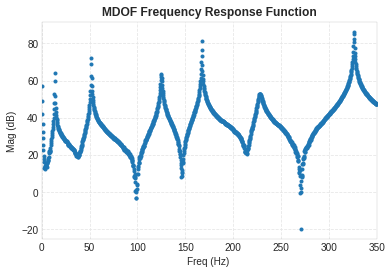

In [5]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/frf1.mat')

H= mat_contents['frf1']
Frequency = mat_contents['freqencies']
fig=plt.figure()
plt.title('MDOF Frequency Response Function', fontweight='bold')
plt.plot(Frequency,20*np.log10((H)),'.')
plt.xlabel('Freq (Hz) ')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=350, xmin=0)
plt.grid(True)
plt.show()


## Half Power (3 dB) Method to estimate Damping ratio:

To calculate the damping, 3 dB method can be used by picking one peak at a time. But, the accuracy of the result using this method depends on level of damping that the peak has.

If the damping is very high, the the resonance in frequency domain is going to be wide, in that case it will be easy to go down accurately measure 3 dB band width. Otherwise,  it would be difficult to estimate 3 dB band width accurately because the next point after or before the peak may be down by 7 or 8 or 9 dB. This is apparent in the above plot, after verifying by zooming in, only the 5th mode's damping can be very well estimated using this method.

![Ideal System(no noise)](img/threedB)(Reference for the figure: [Siemens Corp. Seminar](https://community.plm.automation.siemens.com/t5/Event-Collateral/Modal-Analysis-and-FEA-Test-Correlation/ta-p/435288))



#### Demonstration of Half Power Method, applying on mode 5 of the above FRF

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


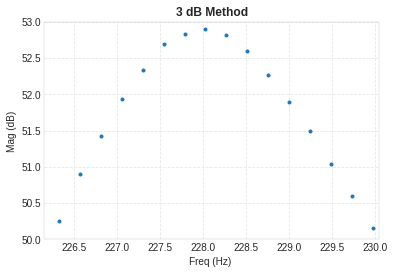

In [6]:
%matplotlib inline
fig=plt.figure()
plt.title('3 dB Method', fontweight='bold')
plt.plot(Frequency,20*np.log10((H)),'.')
plt.xlabel('Freq (Hz) ')
plt.ylabel('Mag (dB)')
xmax=230.05
xmin=226.15
plt.xlim(xmax=230.05, xmin=226.15)
plt.ylim(ymax=53, ymin=50)
plt.grid(True)

plt.show()

In [7]:
fo=228.05
f1= xmin
f2= xmax
Q=(fo)/(f2-f1)
Zeta=1/(2*Q)
Zeta


0.008550756413067321

**Note:** 
- This obtained Zeta for mode 5, can later be compared with the curve fitting results to verify.


- 'Q' is Quality factor, it describes whether a system is heavily or lightly damped. So, the wider the peak, the higher the damping and the lower will be the Quality factor.

## Impulse Response Function:



It describes how the structure decays over time when impacted. The following is a SDOF system but in reality, it would not be a single wave decaying when impacted, there would be number of them superimposed on one another. If it is a SDOF impulse response function, then frequency can be calculated by looking at the period of a complete oscillation, the decay gives us the damping and magnitude indicates the strength of the signal, it's the same information that an FRF provides. 
![Ideal System(no noise)](img/sdof1)
![Ideal System(no noise)](img/sdofeqn)



(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))



### Demonstration of IRF (MDOFsystem):

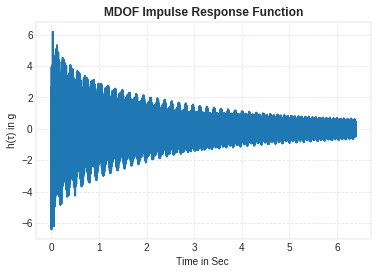

In [8]:
%matplotlib inline


mat_contents=sio.loadmat('SystemAnalysis/1.mat')

Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
H = mat_contents['Hf_chan_2']


Time = mat_contents['Time_domain']
h = mat_contents['Time_chan_2']
             
fig=plt.figure()
plt.title('MDOF Impulse Response Function', fontweight='bold')
plt.plot(Time, (h))

plt.xlabel('Time in Sec ')
plt.ylabel('h(τ) in g')
plt.grid(True)

plt.show()





## Impulse response - Frequency weighting: (to estimate Damping ratio)

The impulse response from all the resonance combined gives a mixed decay curve not usable for an estimation of a specific resonance decay. The mixed decay curve is shown below:


**Note:** The reason behind putting the data in log scale is that the oscillation with exponential decay in linear scale becomes a straight line on the log scale that way it would be easier to calculate the decay if it had only one resonance, by just drawing a straight line joining the peaks of that resonance.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


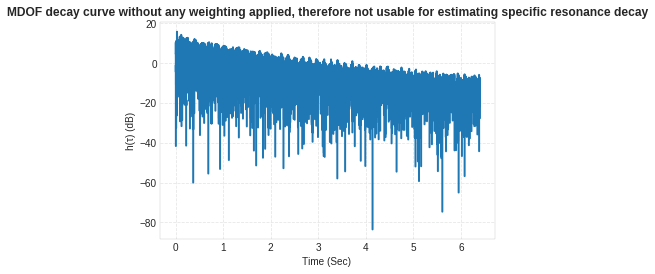

In [9]:
%matplotlib inline
fig=plt.figure()
plt.title("MDOF decay curve without any weighting applied, therefore not usable for estimating specific resonance decay", fontweight='bold')
plt.plot(Time, 20*np.log10(h))
plt.xlabel('Time (Sec) ')
plt.ylabel('h(τ) (dB)')
plt.grid(True)

plt.show()

**Note: MDOF decay curve without any weighting applied shown above, is not usable for estimating specific resonance decay.**

However, if it is possible to do some filtering over one resonance to eliminate the others from the impulse response calculation then that will give a nice straight line. 

**Note: It is still a confusing thing to implement in Python. Python or Vibration Testing Experts may do this hard coding with ease. I would like to see someone fill this gap. So, as of now, this remains as an information in this notebook but this will be implemented in a while**

** Figure below gives the idea of applying weighting using a software**

![Ideal System(no noise)](img/weighting)


(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))


So, in the figure, observe the decay that corresponds to 8.7 dB on a dB scale that's for one time constant for the decay. 


**Reasons of using the weighting:**

- In the frequency domain, when a resonance has very little damping then the shape of the resonance would be very narrow, in that case, it would be difficult to estimate 3 dB band width accurately because the next point after or before the peak may be down by 7 or 8 or 9 dB.


- For a short resonance with very little damping, even if curve fitting can be done in a smart way, it becomes difficult. However, in the time domain, it is not an issue when there is very little damping, only thing that happens would be that the decay would be for a longer time. Hence, damping can be accurately measured in the time domain by applying the filter to see only one resonance at a time .


- The opposite is true if the damping is very high the resonance in frequency domain is going to be wide, in that case it will be easy to go down accurately measure 3 dB band width. In the time domain, delta t error over time τ is very significant, so that's not a good way to calculate damping in this case.

**Feasibility of applying such a filter:**

It is important to keep in mind that here the main idea is to filter out all other resonances except the one chosen with a little window in the frequency domain as shown in the figure above but this method is only possible when the frequency response shows nice clean resonances that are well separated which means they are decoupled. Like in complex structures where they might have a few resonance at low frequency which are fine but when going up in frequency the modes get more and more closer to each other and that would be a mess. So, it is not feasible to use filters in that case to separate resonances. 

## Transducers and Exciters used:

A minimum of two channels are required to measure the signals coming out of the sensors simultaneously to do modal testing. Typically, Channel-1 corresponds to the impact hammer/electromagnetic shaker and Channel-2 to the accelerometer.

### Accelerometers: 

Accelerometers measure the frequencies at which the structure is naturally vibrating. 


Accelerometers are very important in the process of data collection, there is nothing worst than using a pretty good transducer for a wrong job because that will not result in good data and could destroy the transducer if exceeds the range.


### Which one should be used?


**These are the Important Considerations to chose an optimum transducer**:

**1. Type:** 

There are three main types of accelerometers: capacitive MEMS, piezoelectric, and piezoresistive. The accelerometer's data sheet will, or should, tell the exact type because picking the right accelerometer type for any application can make all the difference.  Generally a capacitive MEMS accelerometer is best for motion sensing applications (think human motion which is relatively slow/low frequency); piezoelectric is best for vibration; and piezoresistive is best for shock testing.

**Figure below shows a bunch of accelerometers used in different applications**
![Ideal System(no noise)](img/accels)


(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))

**Piezoelectric Accelerometer:**
**Basic idea behind using piezoelectric ceramic element:** This element behaves like a quartz (pure quartz is used in standard reference accelerometers, less sensitivity but very stable) when applied compressive or shear stress then it 
generates a high-impedance, electric charge proportional to the applied force, and thus, proportional to the acceleration. Shear design is most commonly used. In simple words, an accelerometer works with a quartz or ceramic crystal inside, as the structure vibrates the mass inside the accelerometer compresses the crystal that in turn creates an electric charge which can be amplified and read.

**Very Important Note:**  As most of the times, vibration sensors are piezoelectric ICP or CCLD or IEPE (these are just different names but all are the same) type where sensors are connected to signal conditioners, going through the data acquisition system. However, now a days, everything like the signal conditioning, the power supply for the sensors, etc, are built inside the analyzer. 

**Acronyms: ICP: Integrated Circuit Piezo Electric, CCLD: Constant Current Line Drive, IEPE: Integrated Electronics PiezoElectric**

**Figure below shows a bunch of factors that would result in bad data collection, although only the one's rounded in red are most common in the Experimental Modal Analysis keeping in mind the fact that the testing would be done in Laboratory Environment **
![Ideal System(no noise)](img/envieffectss1)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))


**2. Weight:**

Every accelerometer is also a mass-spring system. Therefore, one big factor while doing modal analysis is Mass Loading(remember, Mass Loading is cumulative), so, if the dynamic mass of the accel is significant then that will change the natural frequencies of the system. Research says accelerometer mass has to be less than one tenth of mass of the system, that would be a good compromise to avoid major error in the recording of natural frequencies of the system. 


**Figure below shows an accelerometer mounted on a Mass-spring system**
![Ideal System(no noise)](img/massloading1)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))


**3. Sensitivity:** 

Sensitivity of an accelerometer defines at what rate the sensor converts mechanical energy into an electric signal (the output); and this will define the acceleration measurement range of the accelerometer.  Sensitivity is usually expressed as mV/g. Desired sensitivity depends on the level of the signal that is needed to be measured.  If interest lies in small vibrations then a higher sensitivity will be desirable to provide a cleaner signal (higher signal to noise ratio). The price to pay for a higher sensitive accelerometer is it's weight.

**Figure below illustrates how Weight, Sensitivity, Frequency range, and Measurement range of Accel relates to one another**
![Ideal System(no noise)](img/sensitivity1)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))

**4. Mounting:**

A stud in theory is the best method to mount an accelerometer but as sometimes when it's not possible then super glue, adhesive tape, bees wax, dental cement, magnetic base, double sided tape, tri-axial blocks etc., are used. Stud mounting is better because, it is important to know that whatever mounting technique is being used, it always reduces little bit of the specification of the accelerometer which means loosing a little bit of the high frequency capability so experts always advice to use stud mounting if possible as it gives better results comparatively.

**5. Cables:**

Rattling of cables on the structure, and interception with electric wires would cause noise that results in bad quality data as they are uncorrelated vibration.

**6. Others:** 

Other important considerations are Frequency response or Bandwidth, Measurement range, Noise, Resolution, Filtering, uni or triaxial etc.

**In Summary:**

The desirable accelerometer for modal analysis would be as light weight as possible to minimize mass loading, with high sensitivity, good phase response to correct frequency characteristics etc.

#### TEDS Accelerometers:

TEDS stands for **Transducer Electronic Data sheet**, a chip that is embedded in the accelerometer containing all the Accel's information include Model Type number, Serial number, Sensitivity, Manufacture and more.

So, with TEDS transducers, all the relevant information is read from the chip and automatically entered in the database measurement setup avoiding mistakes and saving time. 


#### Validation:



This is a regular way of calibrating the accelerometer if it is dropped on the ground, the calibrator is usually standardized to check for 159.2 Hz frequency (1000 rad/sec) and 1g (10 meter per square second) acceleration.

![Ideal System(no noise)](img/calib)

#### Other types of Accelerometers:

There are some companies that use laser vibrometers or laser accels, which are non-contact response sensors. These have there own advantages, one of them being no mass loading. However, it come with a compromise as they are very expensive.

#### Demonstration of Validating the Accelerometer used:

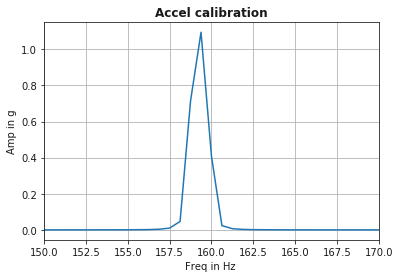

In [63]:
%matplotlib inline


mat_contents=sio.loadmat('accelcalibration/acclecalibration.mat')

Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
H = mat_contents['Lin_Spec_1']



             
fig=plt.figure()
plt.title('Accel calibration', fontweight='bold')
plt.plot(Frequency, H)

plt.xlabel('Freq in Hz ')
plt.ylabel('Amp in g')
plt.xlim(xmax=170, xmin=150)
plt.grid(True)

plt.show()

### Impact Hammers: (Non-attached)

Impact Hammers are used to hit the structure with a measured force, they come in different sizes(1 pound, 3 pounds, 12 pounds and even bigger). The tip of the hammer can be unscrewed from the load cell and be replaced. That's the way the duration of the impact is controlled, and that pulse duration is inversely proportional to the Frequency bandwidth.

**Figure below shows different sizes of the Hammer. However, they can be much bigger depending on the size of the structure being excited**

![Ideal System(no noise)](img/hammers)




(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))



Magnitude and pulse duration depends on:

**1. Weight of hammer**

**2. Hammer tip (steel, plastic or rubber)**

**3. Dynamic characteristics of surface**

**4. Velocity at impact**




**Figure shows idealized case of an impulse excitation in time domain and it's frequency response being flat until infinity but in real life the frequency response is going to die-off after exciting some range of frequencies, which is illustrated in the next section :**

![Ideal System(no noise)](img/idealimpulse)(Reference for the figure: [Siemens Corp. Seminar](https://community.plm.automation.siemens.com/t5/Event-Collateral/Modal-Analysis-and-FEA-Test-Correlation/ta-p/435288))




#### Demonstration of the impact with real data, Soft Vs Hard:

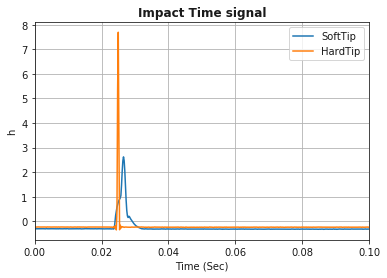

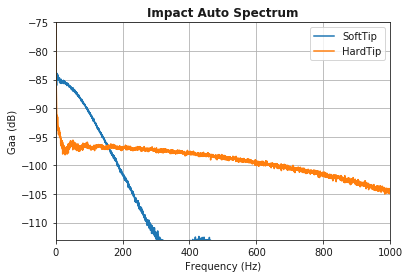

In [64]:
%matplotlib inline
mat_contents=sio.loadmat('hammer/metaltip.mat')
Frequency= mat_contents['Freq_domain']
Metaltipimpactspec = mat_contents['PSD_chan_1']

Time = mat_contents['Time_domain']
Metaltipimpacttime = mat_contents['Time_chan_1']

Frequency= mat_contents['Freq_domain']
Metaltipimpactspec = mat_contents['PSD_chan_1']

mat_contents=sio.loadmat('hammer/plastictip2.mat')
Frequency= mat_contents['Freq_domain']
rubbertipimpactspec = mat_contents['PSD_chan_1']
Time = mat_contents['Time_domain']
rubbertipimpacttime = mat_contents['Time_chan_1']

Frequency= mat_contents['Freq_domain']
rubbertipimpactspec = mat_contents['PSD_chan_1']


fig=plt.figure()
plt.title('Impact Time signal', fontweight='bold')
plt.plot(Time, rubbertipimpacttime, label='SoftTip')
plt.plot(Time, Metaltipimpacttime, label='HardTip')
plt.xlabel('Time (Sec)')
plt.ylabel('h')
plt.grid(True)
plt.xlim(xmax=.1, xmin=0)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('Impact Auto Spectrum', fontweight='bold')
plt.plot(Frequency, 20*np.log10(abs(rubbertipimpactspec)), label='SoftTip')
plt.plot(Frequency, 20*np.log10(abs(Metaltipimpactspec)), label='HardTip')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gaa (dB)')
plt.grid(True)
plt.xlim(xmax=1000, xmin=0)
plt.ylim(ymax=-75, ymin=-113)
plt.legend()
plt.show()



**Observations:** 

- It can be clearly seen that the narrower the duration of impact, the longer the spectrum in the frequency domain called broad band excitation. And the longer the duration of impact, the narrower the spectrum that is the spectrum rolls-off quickly. 


- The softer tip excites lower frequencies better than the harder tip, and the harder tip excites higher frequencies better.


- For the experiment on the wing structure, the softer tip is not appropriate since it drops at about 300 Hz. However, the hard tip tends to agree because there is fairly equal amount of energy across the frequency of interest. Therefore, tips play a major role in this process.


**Very Important Note:** The reason for viewing the hammer auto spectrum in dB is because there is always a roll-off requirement in terms of dB. For instance, if the professor suggests 6 dB as the roll-off requirement then (considering the hard tip case above on the structure) it is only valid up to a frequency range of about 800 Hz. If the frequency range of interest to excite the structure is much higher then either the tip needs to be much stiffer than that had been used or use a shaker. For instance, usually when doing impact testing on a brake disk a pencil hammer with a steel tip is used which will excite upto 20 KHz for that structure.


**Advantages of the Hammer impact:** Speed, No fixturing, No variable mass loading, Portable and highly suitable for field work, relatively inexpensive, useful for determining shaker and support locations.


**Disadvantages:** High crest factor(underestimates the peak) which means possibility of driving structure into non-linear behavior, Tip performance is often overlooked, Not good for very large structures, Repeatable hammer strikes require 'calibrated elbow'.

**Note:** Metal tip when used on metallic structures can indent the structure, and goes non-linear. So, the impact needs to be really soft.





#### Validation:  

When there is a known mass with an accelerometer mounted on it and is impacted to get the FRF which is acceleration divided by force or one over the mass (F=m*a). 
This kind of test should give us the combined mass of the accelerometer and the calibrated mass. 
Care must be taken in maintaining consistency of units, it's easy in the SI system where the mass is in KGs, the measurement in meters and the force in Newtons. Should notice the phase to be flat if every thing is good.

**Figure below gives good idea to set up a test**
![Ideal System(no noise)](img/hamrvalidation)[Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))


**Other applications:** Hammers are also used for conducting floor foundation studies which means by hitting the floor with the hammer trying to understand transmissibility and resonances of the floor.

#### Demonstranting Double hit and the resulting ASD:

/home/sainag/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


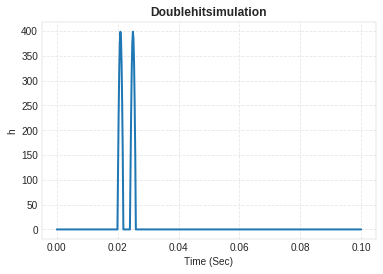

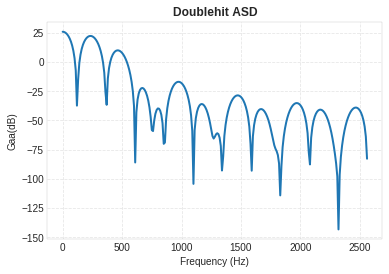

In [10]:
time= np.linspace(0,0.1,513).reshape(1,-1)
force= vt.hammer_impulse(time,imp_time=0.02,imp_duration=0.002,doublehit=True,dh_delta=0.04)
fig=plt.figure()
plt.title('Doublehitsimulation', fontweight='bold')
plt.plot(time.T, force.T)
plt.xlabel('Time (Sec)')
plt.ylabel('h')
plt.grid(True)
plt.legend()
plt.show()

[freq,Pff]=vt.asd(force,time,windowname="none")
freq= freq.reshape(1,257)

fig=plt.figure()
plt.title('Doublehit ASD', fontweight='bold')
plt.plot(freq.T, 20*np.log10(abs(Pff.T)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gaa(dB)')
plt.grid(True)
plt.legend()
plt.show()

#### Ramifications of a double hit in an actual test:


The oscillations in the Hammer Auto spectrum occur due to double or multiple hits. This would add additional noise to the FRF. Peaks at natural frequencies can still be seen, however, additional fake peaks also appear in the FRF which would be confusing. And the mode shapes of the structure will look weird as those oscillation in the Hammer Auto spectrum adds extra contributions. Hence, double hits are not at all a compromise.  

#### Setting up the Hammer:



- The first thing is to determine how high of an impact that's intended to be generated, the idea being the identification of which level is above noise. However, the impact has to only be sufficiently high that they don't easily trigger on softer hits. So, before starting the test, running a free test and determining the trigger threshold would be  a good idea.


- **Hysteresis:** The hysteresis is quite optional, it prevents multiple triggers when the threshold is crossed. So, hysteresis may not be critical. Usually, 1/5th of the trigger level can be used for hysteresis. For instance, if trigger set up at 10 N then 2 N hysteresis would be fine.


- **Pre-trigger samples:** It is important to always make sure that the rise of the impact signal shall not be missed. Essentially, the entire impact pulse should be seen. This can be done by going back in time and getting data before triggering. That's called Pre-trigger, and a good rule of thumb is to fix that value to 5% of the block size which means 5% before trigger and 95% after the trigger.



#### Weighting Function for impact excitation: 

The purpose of the force window is to improve the signal-to-noise ratio of the measured input by eliminating the noise on the signal following the duration of the impact and also the noise on the signal before the impact.

**Figure gives an idea of how the window(in red) takes in only the pulse(in green) and zeros the rest of the signal thereby preventing any noise**
![alt](img/transient)


(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))

#### Common doubt while doing impact testing using a hammer:

Impact testing using a hammer, is just hitting or exciting the structure with it. It is a common concern whether it makes a difference if we hit the structure with lower force versus higher force. Although, it does matter sometimes when the structure is non-linear, for a linear system, it doesn't matter what level of excitation is used as the output will scale with the input, that is, when the force is doubled then the response will also double, this is because of the known fact that FRF is the ratio of output over input. 

However, if the structure is non-linear like the rubber where the input does not scale with the output then the relationship between the two wouldn't hold, in this case the impact testing is not the best technique to use. The linearity check is very well demonstrated with the real data on the wing in the later sections using random excitation.

### Electro-Magnetic Shakers (attached)

Electro-magnetic shaker is like a loud speaker with a cone because these are built in the same way consisting of magnet, coil and suspension which drives them. For instance, a bigger shaker can play music but it will play like a poor speaker without a cone. Basically, once it has a magnetic field and an AC current is run through that field, it will give an AC force which is an oscillation or vibration that comes out of the shaker.

Two equations to remember about shakers are: 

**1. F= l.i.b, where l is the length of the wire in the magnetic field, i is the current and b is the magnetic field** 


**2. F= m.a**

From the two equations, it is known that the acceleration got out of the shaker will be proportional to the current that is coming from the amplifier that drives the shaker. So, shaker always comes with an amplifier. The test signal comes out of the analyzer to shaker via amplifier. Some shakers come with air cooling systems which allow the shakers to drive at higher force levels.

There are two types of shakers: **1. Modal Shakers and 2. General Purpose Shakers**

#### Modal Shakers

Excitation using modal shakers can give better results, more consistency when compared to the impact hammer.There have been number of methods over the years to excite the structure using a shaker. 


The shaker can be mounted horizontally for the excitation in horizontal direction. For vertical excitation, usually it is put on the floor or on the stack of ply-wood so that the structure can excite well, but horizontally it is so difficult to do that. That is the reason stand is provided to the shakers.

It is also true to mount it at some angle in order to excite all the three degrees of freedom at a time, the base stand which holds the shaker together allows to rotate the shaker to get proper alignment when mounting it to the structure.

They have a robust design, can take beating for many years, and they come in different sizes.

**Figure below shows different sizes of Modal shaker**


![alt](img/shakers)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))



**Shaker specifications include:**  Force rate, Frequency range, Max. rated travel (inch peak-to-peak), Armature effective mass, weight with trunnion, Power Amplifier Type, DC static Centering Unit optional.


**Important things to know while Connecting shaker to a structure:**

**Picking the right excitation points:**


- Lot of times, pre-testing is done with a hammer hitting across different point on the structure making sure the excitation point chosen doesn't blind any mode for the frequency range of interest.


**Stinger:**


- The thing to keep in mind is that when physically attaching  a shaker to the structure, the force transducer goes to the structure not on the shaker because the stringer which is attached or tied together between a force transducer and shaker is a filter to a degree and if the force transducer is before the stinger then it doesn't measure what goes on to the structure. So, it has to be on the structure.



- The goal of the stringer is to send all the force to the structure in the axis of interest, the stringers are designed to be infinitely stiff in the axial direction but allows cross motion as much as required in order to not prevent the structure from deforming one way or the other. So, these are the two requirement with the stringer, allow cross motion but being infinitely stiff in it's axial direction.


- To summarize above two points, the shakers can go up to thousands of hertz based on the length and rigidity of the stringer axially. A shorter and more rigid stringer can excite much higher frequencies. But, a lot of times higher frequencies may not be of interest, it depends on the type of testing being done. For instance, if a structure needs to be tested at 3000 Hz, then it would be a little bit of a challenge, in this case a metal stinger have to be used and it should not be more than half a meter in length, it's basically a trial and error to achieve that frequency range. If the stinger is a Nylon stringer then there may be a roll-off at the lower frequencies, therefore, material of the stringer also play a major role in achieving the higher frequencies.



- Some shakers have the thru-hole feature where the stringer can go through the body of the shaker in-out, it can be locked using a chuck and collet system. This feature solved the problem of attaching the stringer both on the shaker side and the structure side.



**Alignment:**


- Shaker alignment with the structure is a very important aspect, all the force transducers used in the modal testing are uni-axial. So, the excitation force is always only in one direction, due this reason any type of misalignment in the set up means putting a side load into the structure but it is not being measured, this would be an issue of error. Hence, it is important to make sure the shaker is properly aligned.



**Force Applied:**


- When it comes to the force applied, it is important to try distributing the force if possible, this way it can prevent not to have extremely high force at only one point and not any where else, that is the reason behind using more number of shakers.



**Weight:**


- The shaker interior has a coil called the armature which has some physical characteristics due to it's weight. So, when attached to the structure that may add weight resulting in mass loading. That is one of the reasons shakers are normally used on very large objects so that the weight of the armature is not significant. To avoid this, there are also a low weight armature and those are good modal shakers which have magnesium armature that is light and stiff.  


**Others:**


- Another thing we see about shaker is that, the attachment point is very small. The armature and head is designed for modal but not for fatigue testing. And, it is not ideal to use general purpose shakers for modal.


#### Modal Test set-up challenge:

**Case 1:** The ideal mounting method is the shaker being supported to produce force to an object which is floating. 

**Case 2:** Both the shaker and the object are floating.

**Case 3:** This is not a good idea as both are supported and the shaker is placed under the structure vertically, here the force transmits back. One should make sure that isolation is good to the force injecting into the structure and only goes to force transducer so that it measures well. Therefore, it is important to not have force behind the force transducer, this will give bad coherence resulting in bad results.


**Figure below gives a good idea of proper mounting technique**
![alt](img/shaker1)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))



**Experts Advice when asked for which way is better?:** Sometimes, shaker can be suspended and sometimes, the structure is free-free and sometime both are in free-free condition. It depends on the best compromise again, one has to make sure that the boundary-condition is not affecting the test result. In a perfect world, we want the structure to be free-free but sometimes there is no other way so the shaker is suspended, in this case the shaker would be pushing against the structure and that is one of the reasons to use the force transducer on the structure as it measures the input force that go into the structure and the response due to that excitation. So, the reason for this is if we think of a rigid body diagram it says that force behind the transducer doesn't matter. 



### Shaker mounting correction for the actual experiment on the wing structure:

By reasoning from above theory, for the experiment on the wing structure, even though it was not possible to have the perfect boundary condition, I was able to isolate the forces into the structure. This issue was sorted out while doing the experiment, a close look at the first picture in the  notebook gives an idea of how the shaker resembles the third case in the figure above, and when that arrangement was used the coherence was never good. Since in our case the structure is clamped at one end and excitation has to be vertical, the shaker was placed on a thermocol for establishing free-free condition that closely resemble the reverse of the Case-1. But it still worked out perfectly.

**Figure below shows mounting method used for the modal test, what's exactly made is a proof mass actuator that is using the inertial load of the shaker to provide the force, this arrangement work equally well. It also mitigated the problems of the stringer bending side-to-side **

![alt](img/shaker)





**Advantages of the Shakers:** Repeatable due to electronic control, Wide range of excitations, Can excite very small thru very large structures, More automated test.


**Disadvantages:** More equipment required than hammer, Skilled operators necessary to supervise test, A lot of setup time required, Shaker issues such as: stringers, mounting of shaker, proper shaker selection.



#### Four steps to Modal Analysis with a shaker


**Step 1:** Excitation of the structure at one point by shaker with force transducer


**Step 2:** Response measured at a number of points


**Step 3:**  FRF’s between excitation point and measurement points calculated


**Step 4:** Modes of structure identified



#### Free Mass Validation: 



The same validation technique used for the impact hammer can be used with Shaker which is comparatively difficult. Test should witness that the phase and the FRF are flat or zero, if that is not the case then there may be a problem. 

**Figure below gives good idea to set up a test**
![alt](img/freemass)


(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))

### Force Transducers:

When measuring the excitation forces into the structure, there are basically two options to use:

**1. The force transducer, and 2. The impedance head transducer**

**1. The force transducer:** 

It only measures the force that is given to the structure using the shaker and the stringer. 

**2. The impedance head transducer:** 

The impedance head is an interesting sensor because one of the important FRF while doing modal testing is called the Driving Point FRF which means the excitation and the response are at the same point on the structure. So, this sensor has the accelerometer and the force transducer inside the same sensor, this makes it really easy to measure the driving point FRF. 


This is very useful especially if using more than one shaker then it would be easier also to conduct the reciprocity check, which means if we have two shakers on the structure then energy can be given at one point and the measurement can be taken from the other point, if the averaging assumption is true then when the force is given at one point the response has to be same at both the two points. 

Both the driving point test and the reciprocity test were conducted and are explained in the later sections.

### Types of Excitations possible with the shaker:

#### 1. Sine Excitation:

Sine excitation runs at one amplitude and one frequency which means picking one point on the input and one on the output and that's what is being measured below.

This is also called Sine dwell test, generally used to excite the structure at it's natural frequencies for a while to observe at what levels the resonant frequencies can be handled.


#### Demonstration of Sine Excitation on the wing with 13.5 Hz Frequency at 6.128 Peak Amplitude:

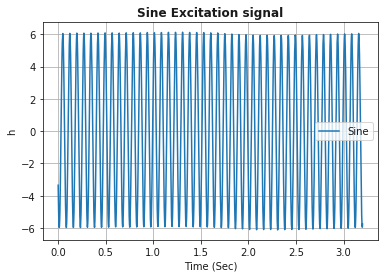

In [66]:

%matplotlib inline
mat_contents=sio.loadmat('sine/Sine.mat')


Gaa = mat_contents['PSD_chan_1']
Gbb = mat_contents['PSD_chan_2']
Time = mat_contents['Time_domain']
Sine = mat_contents['Time_chan_1']

mean = sum(Sine)/len(Sine)
Sine= Sine-mean

fig=plt.figure()
plt.title('Sine Excitation signal' , fontweight='bold')
plt.plot(Time, Sine, label='Sine')

plt.xlabel('Time (Sec)')
plt.ylabel('h')
plt.grid(True)

plt.legend()
plt.show()

Peak= np.max(Sine)

Peak_to_Peak= 2*Peak

RMS = np.max(Sine)/np.sqrt(2)

In [67]:
Peak

6.1286235

In [68]:
Peak_to_Peak

12.257246971130371

In [69]:
RMS

4.3335912259822775

In [70]:
Crest_factor_of_Sine_wave = np.max(Sine)/RMS
Crest_factor_of_Sine_wave

1.4142135623730951

#### Other possibilities with Sine Excitation:



With just Sine excitation, non-linearities of the structure is not taken into account. However, for non-linear studies measuring from low amplitudes and then increase it until a complete picture arrives, this will take long time because if for instance, 10 amplitudes per frequency times 400 frequencies then that counts to 4000 measurements, this can be either be done by writing the program or by collecting the data by accumulating all of that.

#### Sin Sweep across wide range of frequencies:

With Sine sweep across wide range of frequencies, **Modal Analysis can be performed without any signal processing issues.**

**Figure below show the time domain look of the sine sweep signal**

![alt](img/sinesweep1)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))

** Giving broadband excitation:** 

**Figure below demonstrates the broad band excitation of the sine sweep auto spectrum**

![alt](img/sweepauto1)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))
   - Sine wave swept slowly through the frequency range of interest
   - Quasi-stationary condition
    
**Advantages:**
    
   - Low Crest Factor
   - High Signal/Noise ratio
   - Input force well controlled
   - Study of non-linearities possible

**Disadvantages:**
    
   - Very slow
   - No linear approximation of non-linear system

#### 2. Random Excitation:

**Interesting facts about random excitation:**

- Using random excitation by definition means all the frequencies are present, there is no deterministic components, if zoomed-in no separations would be found. Amplitude and phase change randomly.


- Pure random noise can have excursion that are very high. So, normally it is required to limit the crest factor out of the generator to as limit.


- Interesting thing about random noise is that it can linearize slightly non-linear system. And averaging can reduce the random error. So, random excitation needs more averaging.


- One can easily tailor the range of the frequencies interested to excite and also zoom and move it at a different locations. So, it is convenient to excite only the frequency range of interest and ignoring others thereby not wasting energy out of the shaker. Knowing the frequency range tells where to put all the power and that is an advantage of control.


- It is really important to use Hanning Window while using random excitation as it would have leakage issue arising every time. This will be addressed in the Leakage section.


**Note:** when the structure is excited with the miniature shaker, the signal that comes out is called random noise. However, it's random excitation. Noise minimized here is external vibration or forces that are not coming out of the generator that disturb our measurement. So, that uncorrelated contribution from environmental vibration will be  reduce by averaging.

#### Demonstration of Random Excitation:

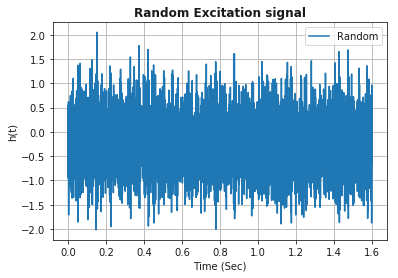

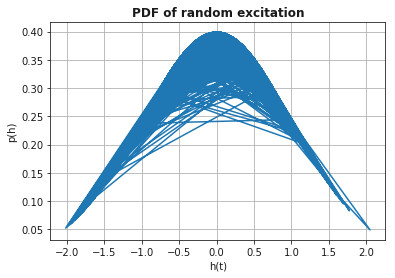

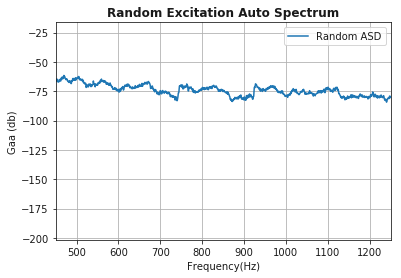

In [71]:
from scipy.stats import norm
%matplotlib inline
mat_contents=sio.loadmat('UsingShaker/1.mat')

Freq = mat_contents['Freq_domain']
Gaa = mat_contents['PSD_chan_1']
Gbb = mat_contents['PSD_chan_2']
Time = mat_contents['Time_domain']
Random = mat_contents['Time_chan_1']

fig=plt.figure()
plt.title('Random Excitation signal', fontweight='bold')
plt.plot(Time, Random, label='Random')
plt.xlabel('Time (Sec)')
plt.ylabel('h(t)')
plt.grid(True)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('PDF of random excitation', fontweight='bold')
plt.plot(Random, norm.pdf(Random))
plt.xlabel('h(t)')
plt.ylabel('p(h)')
plt.grid(True)
plt.show()


fig=plt.figure()
plt.title('Random Excitation Auto Spectrum', fontweight='bold')
plt.plot(Freq, 20*np.log10(Gaa), label='Random ASD')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Gaa (db)')
plt.grid(True)
plt.xlim(xmax=1250, xmin=450)
plt.legend()
plt.show()

**Modal Analysis can be performed using Random Excitation as well but should be careful with signal processing issues.**

**In summary:**

- Random variation of amplitude and phase  ==>  Averaging will give optimum linear estimate in case of non-linearities.


- Characterized by power spectral density (Gaa) and amplitude probability density (p(h))


- Can be band limited according to frequency range of interest 


- Signal not periodic in analysis time  ==>  Leakage in spectral estimates

**Advantages:**

- Best linear approximation of system


- Zoom


- Fair Crest Factor


- Fair Signal/Noise ratio

**Disadvantages:**

- Leakage


- Averaging needed (slower)

#### 3. Burst Random Excitation:

In Burst random, the signal is zero at the beginning and zero at the end, the vibration decays by itself. So, this avoid leakage significantly without windowing thereby helping to get good coherence. 

#### Demonstration of Burst Random Excitation:

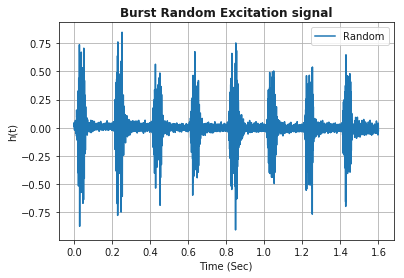

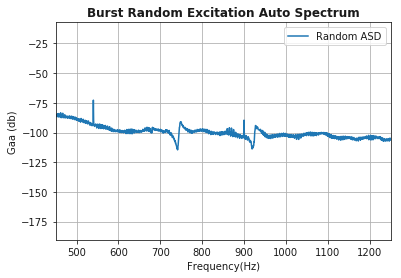

In [72]:

%matplotlib inline
mat_contents=sio.loadmat('burstrandom/18b.mat')

Freq = mat_contents['Freq_domain']
resp = mat_contents['Hf_chan_2']
Gaa = mat_contents['PSD_chan_1']
Gbb = mat_contents['PSD_chan_2']
Time = mat_contents['Time_domain']
Random = mat_contents['Time_chan_1']

mean = sum(Random)/len(Random)
Random= Random-mean

fig=plt.figure()
plt.title('Burst Random Excitation signal', fontweight='bold')
plt.plot(Time, Random, label='Random')
plt.xlabel('Time (Sec)')
plt.ylabel('h(t)')
plt.grid(True)
plt.legend()
plt.show()


fig=plt.figure()
plt.title('Burst Random Excitation Auto Spectrum', fontweight='bold')
plt.plot(Freq, 20*np.log10(Gaa), label='Random ASD')
plt.xlabel('Frequency(Hz)')
plt.ylabel('Gaa (db)')
plt.grid(True)
plt.xlim(xmax=1250, xmin=450)
plt.legend()
plt.show()


**Modal Analysis can be performed using this kind of excitation as well**

**Characteristics of Burst Random signal:**
    
   - Gives best linear approximation of nonlinear system
   
   
   - Works with zoom

**Advantages:**

   - Best linear approximation of system
   
   
   - No leakage (if rectangular time weighting can be used)
   
   
   - Relatively fast

**Disadvantages:**
   
   - Signal/noise and crest factor not optimum
   
   
   - Special time weighting might be required


#### 4. Pseudo Random Excitation:

Pseudo random is like a collection of sine waves at one amplitude. It's not purely random signal, considered as fake random. Therefore, unless there is a trust of how the structure works and is linear, better not to use Pseudo random excitation. Although, it is quick and has advantage of zooming in and move it at different locations.

So, it's basically the block of random signal repeated every T, this may not be seen well in the demonstrated real data.

**Figure below give an idea of the signal, as it is difficult to see this phenomena in the real data demonstrated below**

![alt](img/pseudo)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))

#### Demonstration of Pseudo Random Excitation:

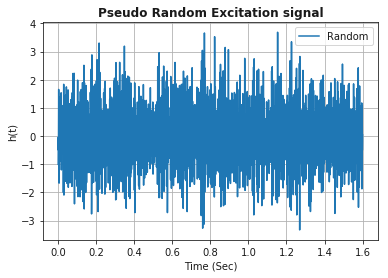

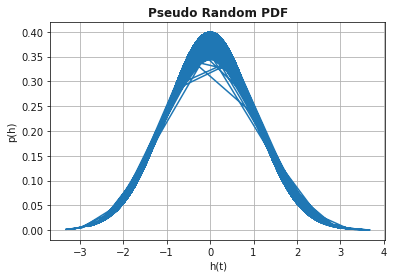

In [73]:
%matplotlib inline
mat_contents=sio.loadmat('pseudorandom/1Pseudo.mat')

Freq = mat_contents['Freq_domain']
Gaa = mat_contents['PSD_chan_1']
Gbb = mat_contents['PSD_chan_2']
Time = mat_contents['Time_domain']
Random = mat_contents['Time_chan_1']

mean = sum(Random)/len(Random)
Random= Random-mean

fig=plt.figure()
plt.title('Pseudo Random Excitation signal', fontweight='bold')
plt.plot(Time, Random, label='Random')
plt.xlabel('Time (Sec)')
plt.ylabel('h(t)')
plt.grid(True)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('Pseudo Random PDF', fontweight='bold')
plt.plot(Random, norm.pdf(Random))
plt.xlabel('h(t)')
plt.ylabel('p(h)')
plt.grid(True)
plt.show()



**Unless we know the system is linear this kind of excitation may not be a good preference for doing Modal Analysis**


**In summary**

- Block of a random signal repeated every T


- Time period equal to record length T
  - Line spectrum coinciding with analyzer lines
  - No averaging of non-linearities
  
  
- Characterized by power/RMS (Gaa) and amplitude probability density (p(h))


- Can be band limited according to frequency range of interest


- Time period equal to T ==> No leakage if Rectangular weighting is used

**Advantages:** 
    
 - No leakage
 
 
 - Fast
 
 
 - Zoom
 
 
 - Fair crest factor
 
 
 - Fair Signal/Noise ratio

** Disadvantages:**

  - No linear approximation of non-linear system

#### Excitation technique: Important Considerations while selecting the type of excitation to proceed with:


- Application


- Non-linearities


- Speed of test


- Leakage (analysis)


- Dynamic range


- Crest factor


- Noise at input and/or output


- Equipment available

#### Guidelines for choice of excitation technique:


- For studying of non-linearities: Swept sine excitation


- For slightly non-linear system: Random excitation


- For perfectly linear system: Pseudo random excitation


- To minimize leakage: Burst random excitation


- For fields measurements: Impact excitation


- For high resolution field measurements: Random impact excitation

## Other Excitation Techniques

**Operational Excitations:**

Sometimes, it may be difficult to excite the structure with a hammer, for instance, to conduct a modal on a bridge, aircraft flying etc, it is better to use the operational excitation by assuming the linear input and measuring the output. Wind excitation can also come under operational excitation.


**Unusual excitations:**

This include loud speakers, gun shot, explosion etc. For example, if we want to understand how the rocket performs structurally in the outer space, speakers can be used surrounding it, to send acoustic excitations in order to understand those modes in that condition. One of such tests named as DFAT (Direct Field Acoustic Test).


## Dual Channel FFT Analysis:

**What is really happening in the DAQ and the corresponding software while data collection?**

Assume channel.A corresponds to excitation and Channel.B to response, first step is to gather time data through the A/D converter and anti-aliasing filter, then do Fourier transformation to get a fourier spectrum and as averaging is being done signals multiply by themselves giving Gaa and Gbb (Autospectrum, has no phase) whose inverse fourier transform gives Auto correlation(Raa and Rbb). Both the signals from Fourier spectrum are brought together to calculate the Cross-spectrum(Gab) where phase is preserved. 
With the cross spectrum and the auto spectrum, the system calculates the FRF and the Coherence which are valuable functions. The other functions are not quite often used in Modal. Essentially, the FRF, the Coherence and the Impulse response(by taking inversed fourier transform of Frequency Response) are the major outcomes. 




**Figure shows the chart which makes it all clear**


![alt](img/dual)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))



**Note:** This chart has not been changed since 30 years. However, the number of channels have been considerably increased. From one excitation - one response to one excitation - multiple response to multiple excitation - multiple response. 

 





**Advantages of Dual-channel FFT Analysis:**

* Phase information is available. Phase gives complete description of the structure and it will let validate by doing proper animation as well.


* Effects of noise are minimized through AVERAGING. 


* A controlled input signal is not needed. So, controlling the excitation amplitude and frequency tightly is not a requirement because if the force spectrum is going up and down within like 20-30 dB, it's not a big deal because the transducer has a large dynamic range and also the front end (160 dB typically) so we can measure every thing accurately. The response will follow the excitation profile to some degree. And once we combine the two different signals together they will normalize.


* Easy tool to use once it is known how to set up the Analyzer.


* Extension, for instance to Modal Analysis.

**Pitfalls of Dual-channel FFT Analysis:**

* Leakage


* A linear system is assumed


###  Leakage:

 

It is the result of underestimating the peak either at the valley or at the resonance.

** To prevent leakage:**

-    Use optimum time weighting function


-    Increase the resolution


-    Choose optimum excitation


#### 1. Using Optimum time weighting function:



 It is a result of not having time data acquisition until infinite time. However, in reality, there is the beginning and the end. So, it is important to add some weighting to prevent leakage.


**Ideal Case**: It almost never happens for a signal like sine wave containing even number of cycles which means that the beginning and the end of time is continuous. Because the FFT process takes that time data block, loop it and analyze constantly so it looks perfectly continuous and thats the ideal case which do not require windowing to prevent leakage. If window is added to that case then that would over estimate damping making the mode look wider than it should be.

**Figure shows how windowing an ideal signal would over estimate the damping parameter**


![alt](img/idealcase1)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))


**Real cases require window to prevent leakage to some extent**: Real world time data is collected as a block which has a size and is not continuous at the beginning and the end. When FFT is done then there will be a drop in amplitude, poor spectrum filter profile. So, it requires weighting functions to control leakage as much as possible.  

**Figure shows how windowing helps in preventing leakage**
![alt](img/realcase1)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))

#### Demonstration of windowing with Exponential for Impact time response and Hanning for Random response:

expwin is untested


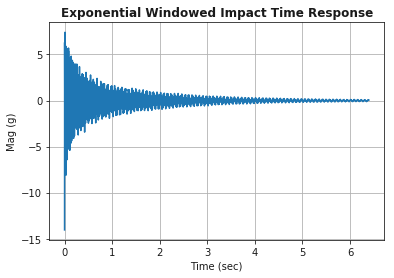

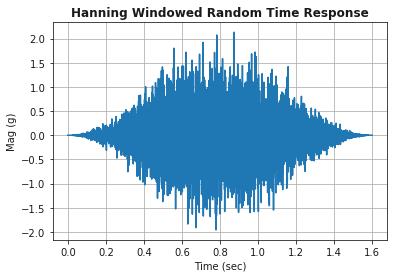

In [74]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
a=vt.expwin(len(Time_data),ts=2)
Time_data= np.transpose(Time_data)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
windowedsig= np.transpose(rawresponse1)*a

fig=plt.figure()
plt.title('Exponential Windowed Impact Time Response', fontweight='bold')
plt.plot(Time_data.T, windowedsig.T)
plt.xlabel('Time (sec)')
plt.ylabel('Mag (g)')
plt.grid(True)

mat_contents=sio.loadmat('linearitycheck/high.mat')
Time_data= mat_contents['Time_domain'] 
Time_data= np.array(Time_data)
a=vt.hanning(len(Time_data))
averagedsig= mat_contents['Time_chan_2']
Time_data= np.transpose(Time_data)

averagedsig = np.array(averagedsig)
windowedsig= np.transpose(averagedsig)*a
fig=plt.figure()
plt.title('Hanning Windowed Random Time Response', fontweight='bold')
plt.plot(Time_data.T, windowedsig.T)
plt.xlabel('Time (sec)')
plt.ylabel('Mag (g)')
plt.grid(True)

#### Demonstrating window effecting the spectrum as explained above:

expwin is untested


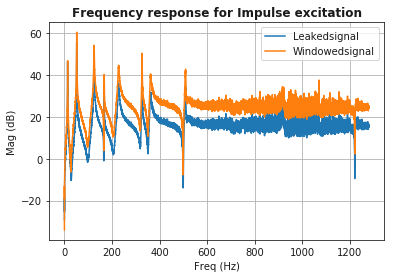

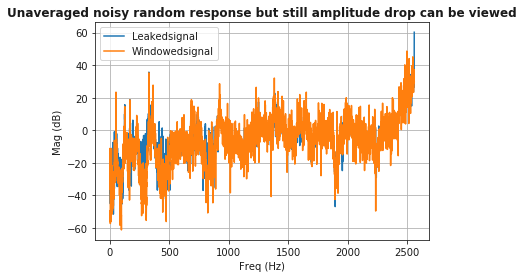

In [75]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
a=vt.expwin(len(Time_data))
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
windowedresponse1= np.transpose(rawresponse1)*a

x=np.array([rawresponse1]).reshape(1,16384,1)

xwindowed=np.array([windowedresponse1]).reshape(1,16384,1)

f=np.array([rawimpact1]).reshape(1,16384,1)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")
[freq,Pff]=vt.asd(f,Time_data,windowname="none")
[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

[freq,Pxxwindowed]=vt.asd(xwindowed,Time_data,windowname="none")
[freq,Pxfwindowed]=vt.crsd(f,xwindowed,Time_data,windowname="none")

Pxx= np.array([Pxx]).reshape(1,8193)

freq=np.array([freq]).reshape(1,8193)

freq=np.array(freq)
H1=np.conj(Pxf/Pff)
H1=np.array([H1]).reshape(1,8193)
H1=np.array(H1)

H1windowed=np.conj(Pxxwindowed/Pxfwindowed)
H1windowed=np.array([H1windowed]).reshape(1,8193)

FRFs= np.column_stack((H1,H1windowed))
FRFs=np.array(FRFs)


fig = plt.figure()
ax = plt.subplot(111)
ax.plot(freq.T, 20*np.log10(abs(H1)).T, label='Leakedsignal')
ax.plot(freq.T, 20*np.log10(abs(H1windowed)).T, label='Windowedsignal')
plt.title('Frequency response for Impulse excitation', fontweight='bold')
plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
ax.legend()
plt.grid(True)
plt.show()

mat_contents=sio.loadmat('linearitycheck/high.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
a=vt.hanning(len(Time_data))
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']

rawresponse1 = np.array(rawresponse1)
windowedresponse1= np.transpose(rawresponse1)*a


x=np.array([rawresponse1]).reshape(1,8192,1)


xwindowed=np.array([windowedresponse1]).reshape(1,8192,1)

f=np.array([rawimpact1]).reshape(1,8192,1)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")
[freq,Pff]=vt.asd(f,Time_data,windowname="none")
[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

[freq,Pxxwindowed]=vt.asd(xwindowed,Time_data,windowname="none")
[freq,Pxfwindowed]=vt.crsd(f,xwindowed,Time_data,windowname="none")

Pxx= np.array([Pxx]).reshape(1,4097)

freq=np.array([freq]).reshape(1,4097)
freq=np.array(freq)
H1=np.conj(Pxf/Pff)
H1=np.array([H1]).reshape(1,4097)
H1=np.array(H1)
H1windowed=np.conj(Pxxwindowed/Pxfwindowed)
H1windowed=np.array([H1windowed]).reshape(1,4097)
FRFs= np.column_stack((H1,H1windowed))
FRFs=np.array(FRFs)


fig = plt.figure()
ax = plt.subplot(111)
ax.plot(freq.T, 20*np.log10(abs(H1)).T, label='Leakedsignal')
ax.plot(freq.T, 20*np.log10(abs(H1windowed)).T, label='Windowedsignal')
plt.title('Unaveraged noisy random response but still amplitude drop can be viewed', fontweight='bold')
plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
ax.legend()
plt.grid(True)
plt.show()

#### Exponential weighting:



Basically, with exponential window, some decay can be added without killing the whole signal. Exponential window can also be avoided if more time is allowed for the measurement. It works both way, either compensate for the weighting later or measure more time, as it is demonstrated and explained below:

#### Demonstration of exponential window over a SDOF impulse response function:

expwin is untested


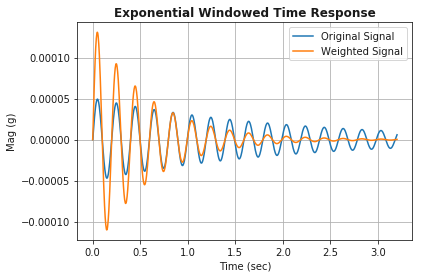

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10


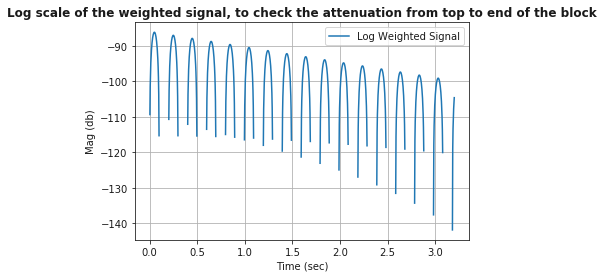

In [76]:
sys = vt.so2ss(np.array([[1]]),np.array([[1]]),np.array([[1000]]),
               np.array([[1]]),np.array([[1]]), np.array([[0]]), np.array([[0]]))
sys = ctrl.ss(*sys)
U = np.zeros((1,1000))
U[0,0]=1
X0=np.array([[0],[0]])
T = np.linspace(0,3.2,1000)
T, yout, xout = ctrl.forced_response(sys,U=U,T=T,X0=X0)


a=vt.expwin(len(T),ts=0.75)
windowedsig= np.transpose(yout)*a
T= T.reshape(1,1000)

fig=plt.figure()
plt.title('Exponential Windowed Time Response', fontweight='bold')

plt.plot(T.T,yout.T, label='Original Signal')
plt.plot(T.T, windowedsig.T, label= 'Weighted Signal')

plt.xlabel('Time (sec)')
plt.ylabel('Mag (g)')
plt.grid(True)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('Log scale of the weighted signal, to check the attenuation from top to end of the block', fontweight='bold')
plt.plot(T.T, 20*np.log10(yout.T), label= 'Log Weighted Signal')

plt.xlabel('Time (sec)')
plt.ylabel('Mag (db)')
plt.grid(True)
plt.legend()
plt.show()

**Importance of viewing in Log Scale:** 

If the weighted signal is converted to log scale, then the amount of attenuation from the top to the end of the block can be seen, the rule of thumb could be if there is less than or equal to 50 dB attenuation from the top to the end then it's good enough to apply weighting. So,  too much external weighting to the signal could kill the good signal, so it's better to not apply weighting. The log graph plotted above shows that there is around 20 dB attenuation that can be good value to have which means that the beginning and the end are pretty close and that would minimize leakage when weighting is applied. 

**Correction:**
- The goal of exponential window is to fit the entire signal inside the window, which means that the amplitude at the end is zero. 


- With exponential weighting of the output signal, the measured time constant will be too short and the calculated decay constant and damping ratio therefore too large. A correction for exponential weighting is required as shown below.

**Figure below shows both the weighted and the true signal along with the correction factor for damping that needs to be applied**
![alt](img/weighting1)


![alt](img/compensation1)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))


**Note:** 
- In addition to choosing exponential window, it is important to keep in mind that measuring for too short duration could result in loosing good data by accident.


- The common mistake is to say that damping is added to the signal when windows are used but it's not damping, it actually adding decay to the signal.

### Very Important points to keep in mind while doing impact testing if the primary goal is FE model updating:


- If the main reason for doing modal analysis using impact testing is for FE correlation then it is important to avoid windowing. Instead of using a window, one has to make sure that the full sinusoidal signal is captured inside the time window. If the structure is heavily damped then this process of capturing full sinusoidal content is quite easy as it takes less time. However, for lightly damped structures, it takes more time for the signal to die-off completely, even in that case it is better to measure for longer time to capture full sinusoid rather than using a window. Because the window makes the FRF peaks appear wider, there by increasing the damping ratio value. This would not result in good MAC with FEA, as the experimental damping values are added to the FE model due to the known fact that Finite elements don't represent damping well. 



- It is important to keep in mind that recording data for too long even after the signal dies-off, over kill the data, but that doesn't change the result anyway and is just waste of time.

**Note:** Uniform, rectangular and no window are just different names but they are all the same



#### 2. Leakage due to low Resolution: 



 when resolution is low, that means there are less points to represent the curves digitally and these points need not necessarily be at the maximum. So, this could cause a reduction in amplitude underestimating the peak either at the resonance or the valley or both. 


Hence, in order to reduce the leakage due the resolution it has to be increased which means data needs to be measured for longer period of time. Leakage can also be reduced by choosing H2 for resonance and H1 for the anti-resonance.


#### Demonstrating leakage due to resolution with Random Excitation:


- Shaker was ran in random mode and seen the impact of different acquisition settings on the coherence and noticed how this can have significant changes to the system.


- Initialized the test by setting a safe voltage level for the shaker by scrolling the bar up and down to adjust in terms of percentage for security reasons, here 100% was used and it's fine to use full voltage if the sytem is considerably big to shake with that high force. However, if a satellite is being tested which costs millions of dollar then care must be taken.


- So, the pure random excitation upto 2KHz was used with a poor frequency resolution of 8Hz which means the measurement had been for 1/8th of a second. 


- Then, ran  the random again as a second case for 1.6 seconds which is 1/1.6 Hz resolution which is higher. And the demonstration and observations are explained below:

(100, 300)

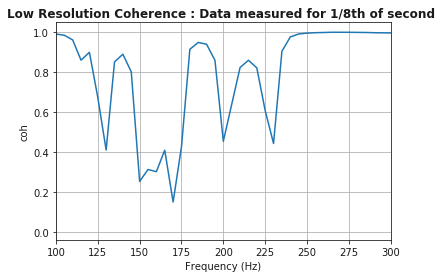

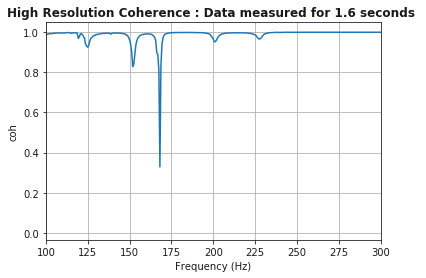

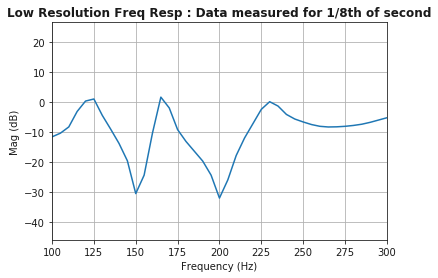

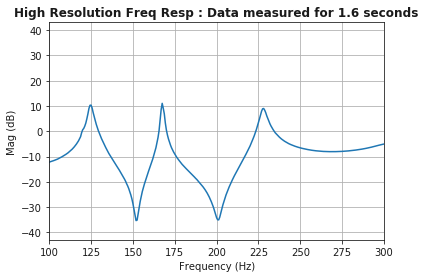

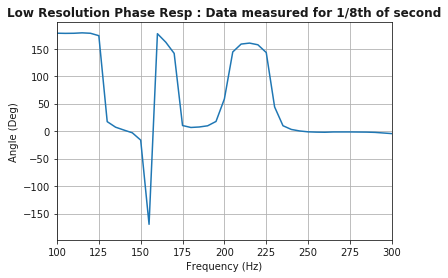

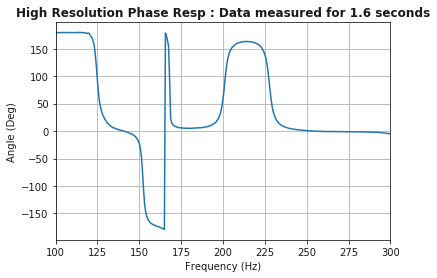

In [77]:
%matplotlib inline
mat_contents=sio.loadmat('Resolution/highresolution.mat')
Frequencyhigh= mat_contents['Freq_domain']
Frequencyhigh= np.array(Frequencyhigh)
#Frequency= np.transpose(Frequency)
Highresolutionresponse = mat_contents['Hf_chan_2']
Highresolutionresponse = np.array(Highresolutionresponse)
coh = mat_contents['Hf_coh_chan_2']
cohhighresolution = np.array(coh)

mat_contents=sio.loadmat('Resolution/Lowresolution.mat')
Frequencylow= mat_contents['Freq_domain']
Frequencylow= np.array(Frequencylow)
lowresolutionresponse = mat_contents['Hf_chan_2']
lowresolutionresponse = np.array(lowresolutionresponse)
coh = mat_contents['Hf_coh_chan_2']
cohlowresolution = np.array(coh)

fig=plt.figure()
plt.title('Low Resolution Coherence : Data measured for 1/8th of second ', fontweight='bold')
plt.plot(Frequencylow, cohlowresolution)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid(True)
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('High Resolution Coherence : Data measured for 1.6 seconds ', fontweight='bold')
plt.plot(Frequencyhigh, cohhighresolution)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid(True)
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('Low Resolution Freq Resp : Data measured for 1/8th of second', fontweight='bold')
plt.plot(Frequencylow, 20*np.log10(abs(lowresolutionresponse)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('High Resolution Freq Resp : Data measured for 1.6 seconds', fontweight='bold')
plt.plot(Frequencyhigh, 20*np.log10(abs(Highresolutionresponse)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('Low Resolution Phase Resp : Data measured for 1/8th of second', fontweight='bold')
plt.plot(Frequencylow, np.degrees(np.angle(lowresolutionresponse)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Angle (Deg)')
plt.grid(True)
plt.xlim(xmax=300, xmin=100)

fig=plt.figure()
plt.title('High Resolution Phase Resp : Data measured for 1.6 seconds', fontweight='bold')
plt.plot(Frequencyhigh, np.degrees(np.angle(Highresolutionresponse)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Angle (Deg)')
plt.grid(True)
plt.xlim(xmax=300, xmin=100)





**Observations:**
- It can be seen that the FRFs are not clean and look rugged at low resolution and coherence has big drops at resonances. So, it has very poor definition around the resonance because of very few points there. This is also apparent in phase plots.


- As the FRF plotted here corresponds to H1, there is no significant leakage at anti-resonances.





**Important Note:** 


- The resolution can be changed even after measuring the data when there is a long enough measurement, they can always be down sampled but cannot be up sampled.

#### 3. Choosing optimum excitation:

**Basic things to understand before being able to avoid leakage due to excitation:**

**Trigger level for an impact:** The trigger level sets the voltage level such that when the impact exceeds it, the DAQ starts recording. However, if the data starts recording right at the trigger level, then the initial part of the impact will be missed and that will cause leakage. In order to avoid this, pre-trigger needs to be set.


**Pre-trigger:** It essentially allow to set and record the buffer time before hitting the voltage trigger level by adding that to the acquisition making sure any part of the impact is not being missed. The rule of thumb was already addressed in the hammers section above, that a good rule of thumb is to fix that value to 5% of the block size which means 5% before trigger and 95% after the trigger. Pre-trigger also avoid distorted FRF.

Therefore, it is important to keep in mind that the Pre-trigger and the observation window stops the leakage.



## Tests for validation of data:



**1. Coherence**


**2. Linearity**


**3. Reciprocity**


**4. Drive Point**


### 1. Coherence: (Input-Output Relation):

This is a rule to always make sure the coherence is "1" or very close to 1 at the resonance. Coherence tells us how good is the measurement in terms of linearity, quality of the impact, and noise. So, it's a very valuable function. 

***Note***: Do not be too concerned if the coherence is something less than "1" at the anti-resonance.

**Figure below shows the Ideal system with coherence 1**
![Ideal System(no noise)](img/Idealsystem)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))

**Figure below shows the Influence of noise that damage the FRF, thereby lowering the coherence**
![Ideal System](img/Influenceofnoise1)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))



#### Averaging: 



If there is little bit of unwanted environmental noise, that means the magnitude of the vector A or B or both would go bigger or smaller, this can be seen in their respective auto spectrum.

**Input Auto spectrum:** Auto spectrum means signal multiplied to it's own complex conjugate. So, when input noise M is multiplied by itself becomes correlated and the noise contribution add to the true input signal. 



![Alt](img/Saa)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))



**Output Auto spectrum:** Any of the auto spectrum includes noise contribution. Here N is output noise.



![Ideal System(no noise)](img/Sbb)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))



**Cross-Spectrum:** The cross spectrum can get the true signal as noise will keep canceling out through averaging. Because every time we multiply two signals that are uncorrelated like noise, the averaging result would be zero because the phase and amplitude both are random. The phase is preserved in the cross-power, which is the reason for doing multiple averages with multiple hammer hits or shaker. So, an FRF is a cross power, we multiply the response times the reference complex conjugate.



![Ideal System(no noise)](img/Sab)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))






### How many number of averages to be taken in impact test:

 Depends on level of noise present during the test. In case of the wing structure, the accelerometer sensitivity was 100 mv/g, the structure is not so big and the vibration due to impact(using hammer) was sufficient to get a cleaner signal. So, only three data sets were averaged. However, for a transducer with 1 mv/g on a big structure and small excitation level, there is a very little vibration. So, the noise is going to be significant in amplitude compared to vibration, this will be problematic. 

In that case not many options exist, so we might use FRF estimators assuming that could solve the issue. This is demonstrated and explained below.

#### Demonstration of three data sets being averaged to reduce noise:

(0, 350)

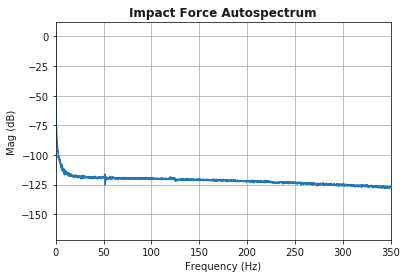

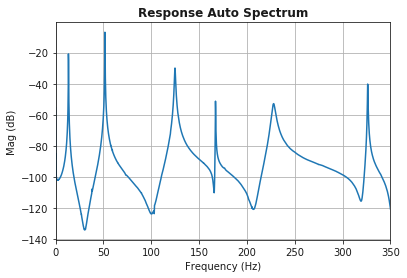

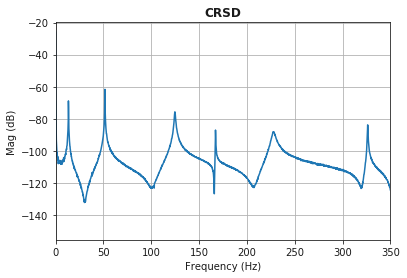

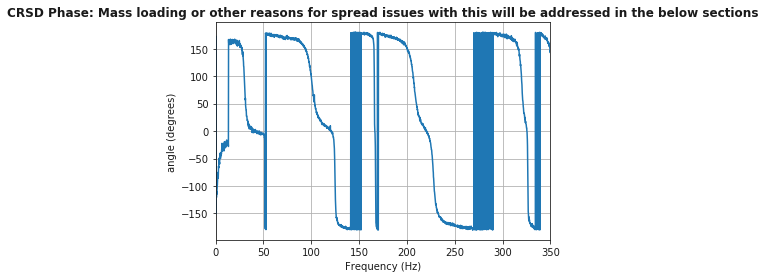

In [78]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
mat_contents=sio.loadmat('modaldata/rawdata_2.mat')
rawimpact2 = mat_contents['Time_chan_1']
rawimpact2 = np.array(rawimpact2)
rawresponse2= mat_contents['Time_chan_2']
rawresponse2 = np.array(rawresponse2)
mat_contents=sio.loadmat('modaldata/rawdata_3.mat')
rawimpact3 = mat_contents['Time_chan_1']
rawimpact3 = np.array(rawimpact3)
rawresponse3= mat_contents['Time_chan_2']
rawresponse3 = np.array(rawresponse3)

x= np.column_stack((rawresponse1,rawresponse2,rawresponse3))
x=np.array([x]).reshape(1,16384,3)

f= np.column_stack((rawimpact1,rawimpact2,rawimpact3))
f=np.array([f]).reshape(1,16384,3)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")

[freq,Pff]=vt.asd(f,Time_data,windowname="none")

[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

freq=np.array([freq]).reshape(1,8193)


fig=plt.figure()
plt.title('Impact Force Autospectrum', fontweight='bold')
plt.plot(freq.T, 20*np.log10(abs(Pff)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('Response Auto Spectrum', fontweight='bold')
plt.plot(freq.T, 20*np.log10(abs(Pxx)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('CRSD', fontweight='bold')
plt.plot(freq.T, 20*np.log10(abs(Pxf)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('CRSD Phase: Mass loading or other reasons for spread issues with this will be addressed in the below sections', fontweight='bold')
plt.plot(freq.T, np.degrees(np.angle(Pxf).T))
plt.xlabel('Frequency (Hz)')
plt.ylabel('angle (degrees)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)


#### FRF Alternative Estimators:  



If the coherence is good then either H1 or H2 can be chosen, the default FRF is H1. 

**Figure below shows a more accurate estimator table used for different compromises that the system has to under go because of signal processing issues**

![alt](img/estimates1)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))


#### Demonstration of H1, H2, Coherence:

(0, 350)

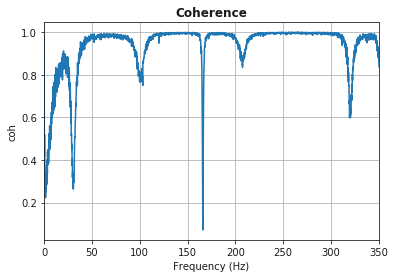

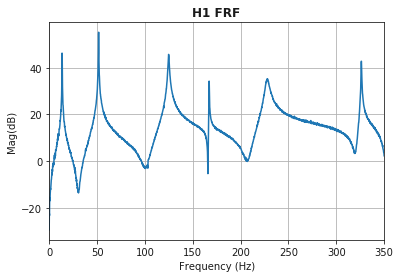

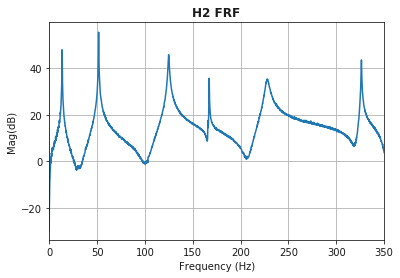

In [79]:
H1=np.conj(Pxf/Pff)
H2=Pxx/Pxf
coh=(Pxf*np.conj(Pxf)).real/Pxx/Pff

fig=plt.figure()
plt.title('Coherence', fontweight='bold')
plt.plot(freq.T, coh.T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('H1 FRF', fontweight='bold')
plt.plot(freq.T, 20*np.log10(abs(H1)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag(dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('H2 FRF', fontweight='bold')
plt.plot(freq.T, 20*np.log10(abs(H2)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag(dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)


**Observations:**  

- Observing that the coherence obtained which is almost 0.9 at resonances but hit spots where the coherence is low and that would happen at the anti-resonances. Depending on how the modes add or subtract,  the FRF can have these deep valleys and these deep valleys indicate that there is very little vibration, so small, we may be very close to the environmental noise and coherence tells that. However, it's not bad to have low coherence at anti-resonance. 


- Closer look at H1 and H2 proves the fact that one is good at anti-resonance and one at resonance.




#### Typical reasons for Low Coherence: 


*** Difficult measurements:***
- Noise in measured output signal


- Noise in measured input signal


- Other inputs not correlated with measured input signal



*** Bad measurements:***
- Leakage


- Time varying systems


- At node point, signal to noise ratio will be low


- Frequency range of excitation, after energy roll-off nothing is good


- Not putting enough energy to excite


- Non-linearities of system


- DOF-jitter

### 2. Linearity Checks:



A structure's FRF is independent of the level of excitation if it is linear. So, the Linearity check is done by exciting the structure at various levels obtaining the same values for the FRF.

**Figure below give an idea of how linearity check works**
![alt](img/Linearity1)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))


The general assumption while doing modal analysis is that the system is linear. However, that is not always true. So, it is important to check the linearity of the system.


#### Averaging of the random signal:

 The averaging is also very useful when the excitation used is random, which means that the excitation varies in amplitudes randomly, and the response will follow. The input-output relation should be a straight line if the system is linear (double the excitation, double the response). And if we have some random errors going every where then averaging would give the best fit for the relationship.

#### Demonstration of linearity check with three different levels of random excitation or noise:

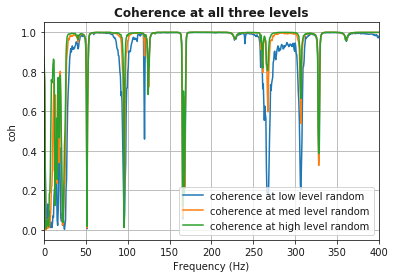

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


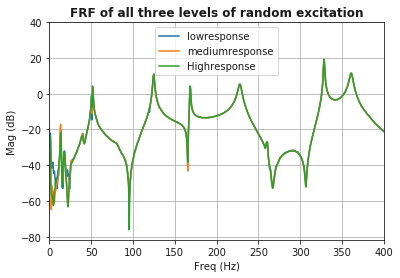

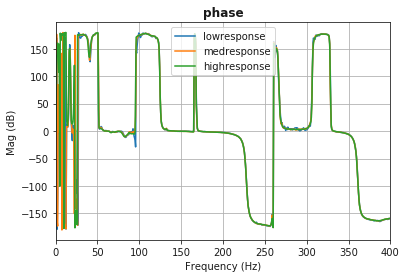

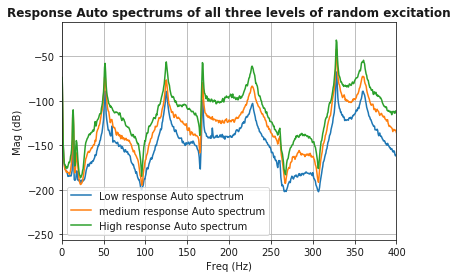

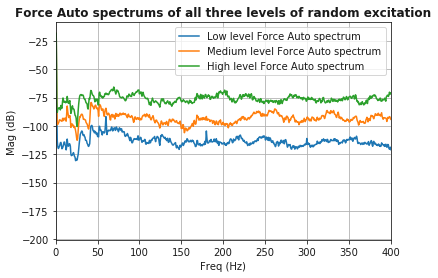

In [80]:
%matplotlib inline
mat_contents=sio.loadmat('linearitycheck/high.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
Highresponse = mat_contents['Hf_chan_2']
Highresponse = np.array(Highresponse)
PSDHighresponse = mat_contents['PSD_chan_2']
PSDHighresponse = np.array(PSDHighresponse)
PSDHighLevelRandom = mat_contents['PSD_chan_1']
PSDHighLevelRandom = np.array(PSDHighLevelRandom)
coh = mat_contents['Hf_coh_chan_2']
Highcoh = np.array(coh)

mat_contents=sio.loadmat('linearitycheck/med.mat')

mediumresponse = mat_contents['Hf_chan_2']
mediumresponse = np.array(mediumresponse)
PSDmediumresponse = mat_contents['PSD_chan_2']
PSDmediumresponse = np.array(PSDmediumresponse)
PSDmediumLevelRandom = mat_contents['PSD_chan_1']
PSDmediumLevelRandom = np.array(PSDmediumLevelRandom)
coh = mat_contents['Hf_coh_chan_2']
Medcoh = np.array(coh)

mat_contents=sio.loadmat('linearitycheck/low.mat')

lowresponse = mat_contents['Hf_chan_2']
lowresponse = np.array(lowresponse)
PSDlowresponse = mat_contents['PSD_chan_2']
PSDlowresponse = np.array(PSDlowresponse)
PSDlowLevelRandom = mat_contents['PSD_chan_1']
PSDlowLevelRandom = np.array(PSDlowLevelRandom)
coh = mat_contents['Hf_coh_chan_2']
Lowcoh = np.array(coh)

FRFs= np.column_stack((lowresponse,mediumresponse,Highresponse))
VibAutospectrum= np.column_stack((PSDlowresponse,PSDmediumresponse,PSDHighresponse))
ForceAutospectrum= np.column_stack((PSDlowLevelRandom,PSDmediumLevelRandom,PSDHighLevelRandom))
coh= np.column_stack((Highcoh, Medcoh, Lowcoh))
coh= np.array(coh)
FRFs=np.array(FRFs)
VibAutospectrum=np.array(VibAutospectrum)
ForceAutospectrum=np.array(ForceAutospectrum)

fig=plt.figure()
plt.title('Coherence at all three levels', fontweight='bold')
plt.plot(Frequency, Lowcoh,label='coherence at low level random')
plt.plot(Frequency, Medcoh,label='coherence at med level random')
plt.plot(Frequency, Highcoh,label='coherence at high level random')
plt.xlim(xmax=400, xmin=0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid(True)
plt.legend()
plt.show()


fig=plt.figure()
plt.title('FRF of all three levels of random excitation', fontweight='bold')

plt.plot(Frequency,20*np.log10(lowresponse), label='lowresponse')
plt.plot(Frequency, 20*np.log10(mediumresponse), label= 'mediumresponse')
plt.plot(Frequency, 20*np.log10(Highresponse), label= 'Highresponse')

plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=400, xmin=0)
plt.grid(True)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('phase', fontweight='bold')
plt.plot(Frequency, np.degrees(np.angle(lowresponse)), label='lowresponse')
plt.plot(Frequency, np.degrees(np.angle(mediumresponse)), label='medresponse')
plt.plot(Frequency, np.degrees(np.angle(Highresponse)), label='highresponse')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.legend()
plt.xlim(xmax=400, xmin=0)
plt.show()

fig=plt.figure()
plt.title('Response Auto spectrums of all three levels of random excitation', fontweight='bold')

plt.plot(Frequency,20*np.log10(PSDlowresponse), label='Low response Auto spectrum')
plt.plot(Frequency, 20*np.log10(PSDmediumresponse), label= 'medium response Auto spectrum')
plt.plot(Frequency, 20*np.log10(PSDHighresponse), label= 'High response Auto spectrum')

plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=400, xmin=0)
plt.grid(True)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('Force Auto spectrums of all three levels of random excitation', fontweight='bold')

plt.plot(Frequency,20*np.log10(PSDlowLevelRandom), label='Low level Force Auto spectrum')
plt.plot(Frequency, 20*np.log10(PSDmediumLevelRandom), label= 'Medium level Force Auto spectrum')
plt.plot(Frequency, 20*np.log10(PSDHighLevelRandom), label= 'High level Force Auto spectrum')

plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=400, xmin=0)
plt.grid(True)
plt.legend()
plt.show()


**Observations:**
 
 
 - We can see at all the levels of the excitation the FRF remains constant which means the system exhibits linear behavior. However, zooming in closely we can find rugged edges in the FRF which is not good at all. 
 
 
 - If we look at the coherence we can choose the best FRF by zooming in, notice that the green signal looks better which is at high level force. So, coherence looks much better with sufficient amount of force.

### 3. Reciprocity Checks:



"Maxwell's Reciprocity Theorem" simply stated, a measurement with the excitation at point A and response at point B is equal to the measurement with excitation at point B and the response at point A. So, if the structure is linear then the reciprocity will be good.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f34df2c40f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f34df56de48>)

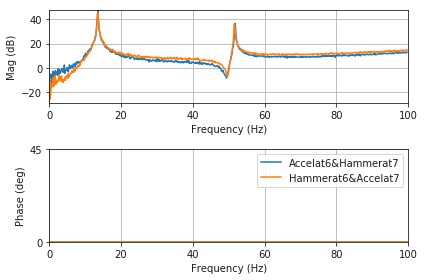

In [81]:
%matplotlib inline
mat_contents=sio.loadmat('reciprocity/accelat6&hammerat7/3.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
FRFat6 = mat_contents['Hf_chan_2']
FRFat6 = np.array(FRFat6)

mat_contents=sio.loadmat('reciprocity/hammerat6&accelat7/1-1.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
FRFat7 = mat_contents['Hf_chan_2']
FRFat7 = np.array(FRFat7)

FRFs= np.column_stack((FRFat6,FRFat7))
FRFs=np.array(FRFs)

vt.frfplot(Frequency,abs(FRFs),freq_min=0,freq_max=100,type=1,legend=['Accelat6&Hammerat7','Hammerat6&Accelat7'])



### 4. Check of Drive Point Measurement:



**Drive point:** 

It is the measured response at the excitation point. Looking at the FRF below, it can be seen that before every resonance there is an anti-resonance all the time, it is consistent. 




#### Demonstration using real data and explanation of Why is it the case,  is below: 

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


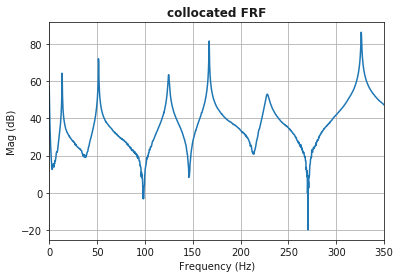

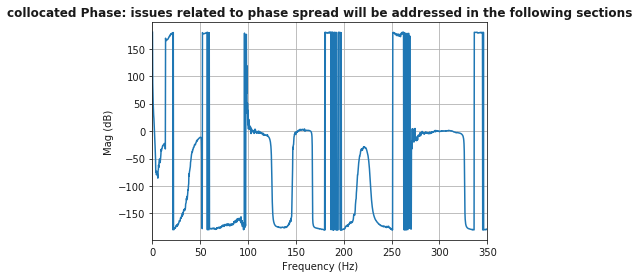

In [82]:
mat_contents=sio.loadmat('modaldata/frf1.mat')
h1 = mat_contents['frf1']
h1 = np.array(h1)
mat_contents=sio.loadmat('modaldata/freqencies.mat')
f = mat_contents['freqencies']
f = np.array(f)
fig=plt.figure()
plt.title('collocated FRF', fontweight='bold')
plt.plot(f, 20*np.log10(h1))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)
plt.show()

fig=plt.figure()
plt.title('collocated Phase: issues related to phase spread will be addressed in the following sections', fontweight='bold')
plt.plot(f, np.degrees(np.angle(h1)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)
plt.show()


**Observations from the FRF and Why is it the case ?**

- At anit-resonances the phase went up and hit 180 degrees. So, at that point, the two amplitudes are same but one is out-of-phase with the other and because it is out-of-phase, they end up with a subtraction. And that is the reason there are anti-resonances before every other resonance. 


- If we excite anywhere else on the structure except the drive point then it would be sometimes in-phase and sometimes out-of-phase. However, at driving point every resonance is in-phase with each other because they are all pushed with same force in the same direction and when out-of-phase then that is the anti-resonance.


- Depending on the phase of the transducer, they can all be either down or up but will be in the same direction.


## Even Experts Have Difficulty:

**Case Study1:** 

- There was a test object that was sent to a group of Test Engineers to conduct a test to extract FRF and we can see below are the results plotted together that the spread was quite significant considering the math is still the same.

![alt](img/experts1)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))



**Case Study2: GARTEUR "Round Robin" Test: Level 4 DTA**

- An aeroplane like specimen was sent to many labs and they were asked to test it for natural frequency and damping. It was found that there was 30% variation in the damping ratio, 4% variation in the resonance frequency. And when they computed a mathematical model for flutter, 13% variation was observed.


- So, we can observe that it is very easy to make a mistake in the damping measurement. We have to be very careful about that.
![alt](img/Garteur1)(Reference for the figure: [Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018))

**Note:** Under the auspices of Group of Aeronautical Research and Technology in Europe (GARTEUR): Twelve experienced GVT units from all of Europe performed the above modal test of the same test specimen. (ref. NLR TP 97086U, 1996) 

## In Summary: Tips and Tricks for best results:



- **Verify measurement chain integrity prior to test:**
  1. Transducer calibration
  2. Mass Ratio calibration


- **Verify suitability of input and output transducers:**
  1. Operating ranges(frequency, dynamic range, phase response)
  2. Mass loading
  3. Mounting
  4. Sensitivity to environmental effects
  5. Stability


- **Verify suitability of test set-up:**
  1. Transducer positioning and alignment 
  2. Pre-test: rattling, boundary conditions, rigid body modes, signal-to-noise ratio, linear approximation, excitation   signal, repeated roots, maxwell reciprocity, force measurement, exciter-input transducer-stringer-structure connection


- **Remember:**
  1. Quality FRF measurements are the foundation of experimental modal analysis
  

- **Select the Proper Resolution:**
  1. High resolution = Longer time block
  2. When hammer testing time block is critical!
 

- **Use the Right Window:**
  1. Hammer Testing: Uniform or Transient/Exponential Window
  2. Shaker Testing: Uniform or Hanning based in excitation
  3. Apply decay correction on Exponential window
  

- **Pay Attention to Coherence:**
  1. The higher the better
  2. If we have poor coherence, retest the point
  

- **Keep track of the DOFs:**
  1. Each measurement is a Degree of Freedom
  2. Direction and location information is critical

## Actual Testing and Analysis:

### Boundary Conditions -  What are the Goals?

When conducting modal testing, it is important to consider the boundary conditions. The case here had the wing clamped at one end. However, there is no such thing as a clamped beam because the clamp is moving which contradicts the fact of having fixed slope and fixed displacement, as in reality neither one is zero. 


When it comes to FE analysis, any boundary condition can be simulated with the modern tools available. Therefore, FE analysis boundary condition can be Free-Free.


In testing world, boundary conditions can be arranged to closely represent the free-free condition. So, it is an important aspect for a test engineer to consider how to simulate the free-free, typically, using some sort of soft spring elastic cord, bungee cord, piece of foam, some times pneumatic suspensions like air bags, etc. 


A better insight on the challenges during correlating the test and the FE are with boundary conditions, let us consider, for instance, instead of a free-free system, the test object is mounted on isolaters with damping, in that case, impedance measurements are done across the mounts using correlation to get the mount values as close as possible in order to use that in the FE model as boundary condition. So, the test based boundary conditions with FE model a lot of times are hard to model, for instance, hydro-mounts in testing.  But using the test technique as the boundary condition in the FE model would make it more accurate.


The most important thing to keep in mind is that under free-free condition, rigid body modes are also obtained in both the FE simulation and the testing. In FEA, all the rigid body modes would appear at zero hertz. However, in testing, rigid body modes will be relatively close to zero hertz but not at zero hertz, they will be below 10 Hz. These rigid body modes will have negligible effect on flexible mode, typically, a long period of frequencies where the FRF may not have any sort of modes after the rigid body modes and before hitting the first flexible mode and this line is known as "Mass Line".


**Note:** There are basically 6 rigid body modes, 3 translations and 3 rotations along x,y and z.

### Pre-Test Analysis: Determining the number of points to use on the structure:


**For the Wing Structure being used:**

- Building an FE model would be a good way to start with, as the FEA can help us to determine the number of points to mathematically separate all modes.


- So, at first creating a beam model by choosing number of nodes and elements that would represent the number of modes of interest. If we look at the results there is this third dynamic mode which will not be seen in the experimental results as sensor is uniaxial, so we neglect it when we calculate MAC later.


- If we see below, we can see 18 points are enough to be able to map all six mode shapes that we are interested in.


- Therefore, it is important to know how many points to put on the structure and also most importantly, the locations of those points on the structure. The concept of MAC would be addressed in the later section, basically, we would look for a good MAC (obtained with enough data points at good locations on the test structure) to make sure the results are accurate in the test, however, a Pre-test analysis on a FE model in a commercial software would give us the locations of the accelerometers based on the complexities in the model such as welds, localized deformations (we need more accles close to one another where the localized deformation may exist, in order to differentiate the mode shapes between those points in that region), etc., as well as the frequency range of interest. This way, in the test, the accel points and their locations need not be chosen by a trial and error method until a good MAC is obtained.  


**Note:** In real world, the tests are done in free-free conditions and the same boundary conditions are applied for FE model, hence, the results would include number of rigid body motions but they are all of no interest, only dynamic flexible modes that deform are more important.


#### Demonstration of how the reduced K and M matrix (using Guyan) pulled out from the Beam model to find out the mode shapes:

In [83]:
%matplotlib inline
mat_contents=sio.loadmat('FEmodaldata/WingBeamforMAC.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbm = K.todense()
Mbm = M.todense()
omega, zeta, PsiBM = vt.sos_modal(Mbm, Kbm)
Psi_1 = PsiBM
mode1=Psi_1[:,0]
mode2=Psi_1[:,1]
mode3=Psi_1[:,3]
mode4=Psi_1[:,4]
mode5=Psi_1[:,5]
mode6=Psi_1[:,6]
Psi_2BM= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))
omegaBM = [omega[0],omega[1],omega[2],omega[3],omega[4],omega[6]]
omegaBM

[11.214728919133529,
 48.724845725614983,
 94.961906540415697,
 119.36969102607624,
 202.28950337721446,
 320.77102270414338]


![alt](img/Beammodelmode1.jpg)  ![alt](img/Beammodelmode2.jpg)  ![alt](img/Beammodelmodeextra.jpg)  
![alt](img/Beammodelmode3.jpg)  ![alt](img/Beammodelmode4.jpg)  ![alt](img/Beammodelmode5.jpg)  
![alt](img/Beammodelmode6.jpg)

### Steps in Real world Pre-Test analysis:

**Step1:** Use FE model to pick some initial accelerometer locations.



**Step2:** Use MAC(a measure of how well mode shapes are correlated) to assure that accelerometer locations are sufficient to uniquely identify all modes from FEM Normal Modes Analysis. If the MAC matrix shows large off-diagonal terms, indicating that several modes are non-uniquely identified then more accelerometers are required to guarantee a good test.



**Step3:** Commercial software like LMS Virtual Lab etc., can locate additional accelerometers to meet requested MAC criterion.



**Step4:** New MAC  matrix can be verified, which must show all modes uniquely identified. That is indicated by reduction of off-diagonal terms.



**Step5:** Creating the geometry for testing and continuing with testing which is in the following section

 ### Creating the Geometry of the wing using OpenModal:

The geometry does not need to be a precise reproduction of the DUT. The geometry is only needed for the visualization of the mode shape. 

So, we don't  need to have the geometry that represent the wing exactly. An open source experimental modal analysis software called "OpenModal" was used to create a 18 consistent points joined by lines and surfaces to roughly represent the top view of the wing structure. 
 

 
 ![alt](img/wingmodel)

### DOF setup for the roving impact method: (SISO)

With the Roving Hammer excitation the one reference Accelerometer was kept at a fixed location 1 and the hammer is used to impact at all the DOF identified in the the negative z direction. All those FRF will be used for the modal analysis post- process calculation.


**Important Note:**


We can also have two response accelerometers placed in two of the corners which means there would be another row. The reason for this is sometimes one position of the accelerometer may not be ideal for all the frequencies in that case the second one could be useful. There are also other reasons for that which will be addressed in the later sections but this is one possible reason.

#### Quality of the data check: done of all the FRFs, here demonstrating only one:

This is like a repeat, this has already been demonstrated in the pre-test above. Basically, the pre-test allows to try different excitation scenario and pick the best. The softer tip was not an appropriate since it drops before 200 Hz and so the coherence was poor starting at 250 Hz. The hard tip tends to agree well. And that is demonstrated below:

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0, 350)

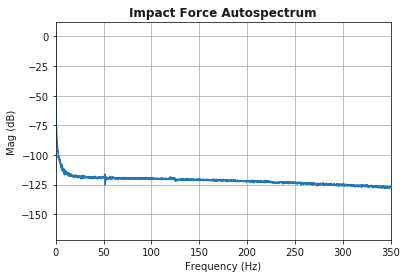

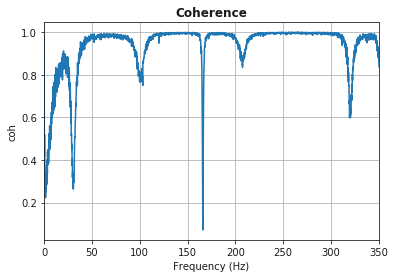

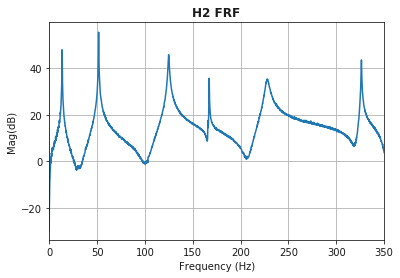

In [84]:
%matplotlib inline
mat_contents=sio.loadmat('modaldata/rawdata_1.mat')
Time_data= mat_contents['Time_domain']
Time_data= np.array(Time_data)
Time_data= np.transpose(Time_data)
rawimpact1 = mat_contents['Time_chan_1']
rawimpact1 = np.array(rawimpact1)
rawresponse1= mat_contents['Time_chan_2']
rawresponse1 = np.array(rawresponse1)
mat_contents=sio.loadmat('modaldata/rawdata_2.mat')
rawimpact2 = mat_contents['Time_chan_1']
rawimpact2 = np.array(rawimpact2)
rawresponse2= mat_contents['Time_chan_2']
rawresponse2 = np.array(rawresponse2)
mat_contents=sio.loadmat('modaldata/rawdata_3.mat')
rawimpact3 = mat_contents['Time_chan_1']
rawimpact3 = np.array(rawimpact3)
rawresponse3= mat_contents['Time_chan_2']
rawresponse3 = np.array(rawresponse3)

x= np.column_stack((rawresponse1,rawresponse2,rawresponse3))
x=np.array([x]).reshape(1,16384,3)

f= np.column_stack((rawimpact1,rawimpact2,rawimpact3))
f=np.array([f]).reshape(1,16384,3)

[freq,Pxx]=vt.asd(x,Time_data,windowname="none")

[freq,Pff]=vt.asd(f,Time_data,windowname="none")

[freq,Pxf]=vt.crsd(f,x,Time_data,windowname="none")

freq=np.array([freq]).reshape(1,8193)


fig=plt.figure()
plt.title('Impact Force Autospectrum', fontweight='bold')
plt.plot(freq.T, 20*np.log10((Pff)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag (dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)

H1=np.conj(Pxf/Pff)
H2=Pxx/Pxf
coh=(Pxf*np.conj(Pxf)).real/Pxx/Pff

fig=plt.figure()
plt.title('Coherence', fontweight='bold')
plt.plot(freq.T, coh.T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)

fig=plt.figure()
plt.title('H2 FRF', fontweight='bold')
plt.plot(freq.T, 20*np.log10((H2)).T)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Mag(dB)')
plt.grid(True)
plt.xlim(xmax=350, xmin=0)


### DOF setup for the Fixed shaker method: 

With the Shaker excitation, typically one or more shakers are fixed at well selected locations after pretesting with hammer to make sure that location is not a node at any natural frequencies that we are measuring and one or several accelerometers can be roved along all the DOF on the wing during the measurement sequence. 

Whether we have one output (SISO) or multiple output (SIMO), the math is always the same. It's one response with one force which is two channels, and we just repeat it many times only because there are multiple accelerometers. However, every one of them are two channel calculations.

With enough hardware all the DOF could be acquired in one measurement.

#### Quality of the data check: done of all the FRFs, here demonstrating only one:

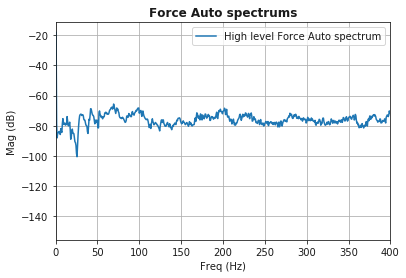

/home/sainag/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


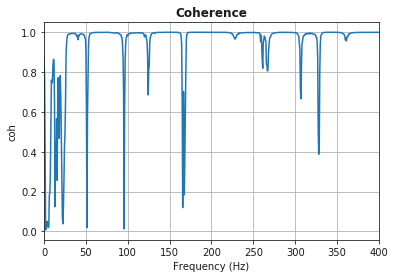

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


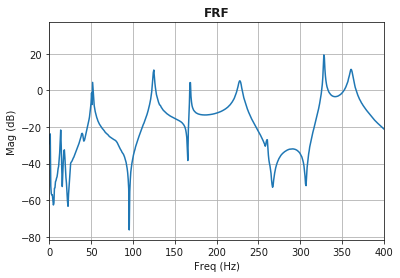

In [85]:
%matplotlib inline
mat_contents=sio.loadmat('linearitycheck/high.mat')
Frequency= mat_contents['Freq_domain']
Frequency= np.array(Frequency)
Highresponse = mat_contents['Hf_chan_2']
Highresponse = np.array(Highresponse)
PSDHighresponse = mat_contents['PSD_chan_2']
PSDHighresponse = np.array(PSDHighresponse)
PSDHighLevelRandom = mat_contents['PSD_chan_1']
PSDHighLevelRandom = np.array(PSDHighLevelRandom)
coh = mat_contents['Hf_coh_chan_2']
Highcoh = np.array(coh)



fig=plt.figure()
plt.title('Force Auto spectrums', fontweight='bold')

plt.plot(Frequency, 20*np.log10(PSDHighLevelRandom), label= 'High level Force Auto spectrum')

plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=400, xmin=0)
plt.grid(True)
plt.legend()
plt.show()

fig=plt.figure()
plt.title('Coherence', fontweight='bold')

plt.plot(Frequency, Highcoh)
plt.xlim(xmax=400, xmin=0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('coh')
plt.grid(True)
plt.legend()
plt.show()


fig=plt.figure()
plt.title('FRF', fontweight='bold')


plt.plot(Frequency, 20*np.log10(Highresponse))

plt.xlabel('Freq (Hz)')
plt.ylabel('Mag (dB)')
plt.xlim(xmax=400, xmin=0)
plt.grid(True)
plt.legend()
plt.show()




**Observations:** 

- FRF looks rugged and at the low frequencies the coherence is not good. Therefore, impact results look much better than the random excitation results for the frequency range of interest from 0-350Hz. 

#### Data collected from impact test:

In [86]:
mat_contents=sio.loadmat('modaldata/frf1.mat')
h1 = mat_contents['frf1']
h1 = np.array(h1)
mat_contents=sio.loadmat('modaldata/frf2.mat')
h2 = mat_contents['frf2']
h2 = np.array(h2)
mat_contents=sio.loadmat('modaldata/frf3.mat')
h3 = mat_contents['frf3']
h3 = np.array(h3)
mat_contents=sio.loadmat('modaldata/frf4.mat')
h4 = mat_contents['frf4']
h4 = np.array(h4)
mat_contents=sio.loadmat('modaldata/frf5.mat')
h5 = mat_contents['frf5']
h5 = np.array(h5)
mat_contents=sio.loadmat('modaldata/frf6.mat')
h6 = mat_contents['frf6']
h6 = np.array(h6)
mat_contents=sio.loadmat('modaldata/frf7.mat')
h7 = mat_contents['frf7']
h7 = np.array(h7)
mat_contents=sio.loadmat('modaldata/frf8.mat')
h8 = mat_contents['frf8']
h8 = np.array(h8)
mat_contents=sio.loadmat('modaldata/frf9.mat')
h9 = mat_contents['frf9']
h9 = np.array(h9)
mat_contents=sio.loadmat('modaldata/frf10.mat')
h10 = mat_contents['frf10']
h10 = np.array(h10)
mat_contents=sio.loadmat('modaldata/frf11.mat')
h11 = mat_contents['frf11']
h11 = np.array(h11)
mat_contents=sio.loadmat('modaldata/frf12.mat')
h12 = mat_contents['frf12']
h12 = np.array(h12)
mat_contents=sio.loadmat('modaldata/frf13.mat')
h13 = mat_contents['frf13']
h13 = np.array(h13)
mat_contents=sio.loadmat('modaldata/frf14.mat')
h14 = mat_contents['frf14']
h14 = np.array(h14)
mat_contents=sio.loadmat('modaldata/frf15.mat')
h15 = mat_contents['frf15']
h15 = np.array(h15)
mat_contents=sio.loadmat('modaldata/frf16.mat')
h16 = mat_contents['frf16']
h16 = np.array(h16)
mat_contents=sio.loadmat('modaldata/frf17.mat')
h17 = mat_contents['frf17']
h17 = np.array(h17)
mat_contents=sio.loadmat('modaldata/frf18.mat')
h18 = mat_contents['frf18']
h18 = np.array(h18)
mat_contents=sio.loadmat('modaldata/freqencies.mat')
f = mat_contents['freqencies']
f = np.array(f)

#### Data collected from random excitation test:

In [87]:
mat_contents=sio.loadmat('UsingShaker/1.mat')
response1 = mat_contents['Hf_chan_2']
response1 = np.array(response1)
mat_contents=sio.loadmat('UsingShaker/2.mat')
response2 = mat_contents['Hf_chan_2']
response2 = np.array(response2)
mat_contents=sio.loadmat('UsingShaker/3.mat')
response3 = mat_contents['Hf_chan_2']
response3 = np.array(response3)
mat_contents=sio.loadmat('UsingShaker/4.mat')
response4 = mat_contents['Hf_chan_2']
response4 = np.array(response4)
mat_contents=sio.loadmat('UsingShaker/5.mat')
response5 = mat_contents['Hf_chan_2']
response5 = np.array(response5)
mat_contents=sio.loadmat('UsingShaker/6.mat')
response6 = mat_contents['Hf_chan_2']
response6 = np.array(response6)
mat_contents=sio.loadmat('UsingShaker/7.mat')
response7 = mat_contents['Hf_chan_2']
response7 = np.array(response7)
mat_contents=sio.loadmat('UsingShaker/8.mat')
response8 = mat_contents['Hf_chan_2']
response8 = np.array(response8)
mat_contents=sio.loadmat('UsingShaker/9.mat')
response9 = mat_contents['Hf_chan_2']
response9 = np.array(response9)
mat_contents=sio.loadmat('UsingShaker/10.mat')
response10 = mat_contents['Hf_chan_2']
response10 = np.array(response10)
mat_contents=sio.loadmat('UsingShaker/10.mat')
response11 = mat_contents['Hf_chan_2']
response11 = np.array(response11)
mat_contents=sio.loadmat('UsingShaker/12.mat')
response12 = mat_contents['Hf_chan_2']
response12 = np.array(response12)
mat_contents=sio.loadmat('UsingShaker/13.mat')
response13 = mat_contents['Hf_chan_2']
response13 = np.array(response13)
mat_contents=sio.loadmat('UsingShaker/14.mat')
response14 = mat_contents['Hf_chan_2']
response14 = np.array(response14)
mat_contents=sio.loadmat('UsingShaker/15.mat')
response15 = mat_contents['Hf_chan_2']
response15 = np.array(response15)
mat_contents=sio.loadmat('UsingShaker/16.mat')
response16 = mat_contents['Hf_chan_2']
response16 = np.array(response16)
mat_contents=sio.loadmat('UsingShaker/17.mat')
response17 = mat_contents['Hf_chan_2']
response17 = np.array(response17)
mat_contents=sio.loadmat('UsingShaker/18.mat')
response18 = mat_contents['Hf_chan_2']
response18 = np.array(response18)

Frequency= mat_contents['Freq_domain']

f1 = np.array(Frequency)

## Mode Shape

Excitation in which a system is affected under a specific frequency. In simple words, mode shape is how the structure moves at a particular frequency. As we go up in frequency, the mode shapes are going to be a more complex and localized.

One more thing to keep in mind and most commonly confused is the difference between node and anti-node shown in the figure below:

 ![alt](img/node) (Reference for the figure: [Siemens Corp. Seminar](https://community.plm.automation.siemens.com/t5/Event-Collateral/Modal-Analysis-and-FEA-Test-Correlation/ta-p/435288))

 
 - Purple point represent the anti-node, which means the position of maximum displacement.
 
 
 
 - Green point represent the node, which means the place where the displacement is zero for a given mode shape. 
 
** Note:** Phase plays the major role in animating the mode shapes, and it is always relative to some other point on the structure or the input force given which is termed as reference. So, based on the behavior of the system at particular frequency each point on the structure can either move in-phase or out-of-phase relative to the reference.

### Measurement Validation: done with OpenModal Gui:

**Major Difference between just peak picking and full-blown modal analysis:** One has to keep in mind that there is no way that one can get accurate mode shapes in every case just using only peak picking. Here in this case, the structure is not very complex as all the modes in the FRF are well separated so they don't have much surrounding influences. However, in real world, there will be very closely spaced modes where the energy from those two modes build up into one peak looking like a single mode and these can only be separated using curve fitting by using different testing techniques. This will be addressed in later sections.


- **Animate the data via the "Function Animation":** Here, the cursor just looks at amplitude and phase at every location and plots movement of each point relative to one another choosing one mode at a time. So, using raw data, we can also click in between two resonance and have the linear combination of the two, but it makes more sense when we take the cursor to the peaks. Function animation is also called as method of animating mode shapes by **"SDOF Peak Picking"**.


- These mode shapes can be compared later with the original mode shapes obtained from curve fitting. 


- The FRF shown below in the peak picking method is the envelop of all the 18 FRFs.


 ![alt](img/11)  ![alt](img/12)  ![alt](img/13)  ![alt](img/14)  ![alt](img/15)  ![alt](img/16)

**Important Note:** - Since the resonances of interest from 0 to 350 Hz are nice and clean, the method of peak picking holds good. However, one has to keep in mind that not every structure is like that, in fact, most structures don't behave like the case here. So, we use suitable way to curve fit.

## Curve Fitting

- In early days, the curve fit was done only for one resonance and one measurement at a time, it would take long time for the analysis. Today, curve fitters are Multiple degree of freedom curve fitters which curve fit multiple resonances all at once, that is better because it takes into account the influence of one on the other and in our case we still have extremely easy data set because every peak is well separated. However, in some FRF, it is difficult to determine what is happening. So, they need to be able to curve fit multiple resonances at a time and it is global because it does every measurement together.


- Now, we have FRFs and to be able to create our mathematical model and decompose this MDOF system in individual SDOF systems through the curve fitting. The goal is to measure sufficiently large number of points on the structure to be able to characterize the Mode shapes, each resonance has it's own unique mode shape. . 

**Rule of which curve fitter to use:** There are no rules, curve fitting, as much science as it is an art. We need to learn, experiment to see which one does the better job for the given conditions, so there no fixed rules. However, one important thing to keep in mind is that the band that needs to be choosen for determining the frequency range of interest to curve fit should start and end at a valley, it should never cut through resonant frequency.

### Curve Fitting Techniques:



**Single Degree of Freedom (SDOF)**


- **SDOF Polynomial**


- Circle Fit


**Multi Degree of Freedom (MDOF)**


- **MDOF Polynomial**


- **Complex Exponential**


- Direct Parameter


- Polyreference


- ...................
 
 

## MDOF_CF (Single mode) Curve Fitter in Vibration Testing Tool box:



**Note from the Author of the curve fitter:** FRF are columns comprised of the FRFs presuming single input, multiple output z and nf are the damping ratio and natural frequency (Hz) u is the mode shape. Only one peak may exist in the segment of the FRF passed to sdofcf. No zeros may exist within this segment. If so, curve fitting becomes unreliable.

This curvefit has to be validated using the Sdofcf later to visualize for the best possible fit

In [88]:

TF= np.column_stack((h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18))
[Damping1,naturalfreq1,U1]=vt.mdof_cf(f,TF,40,70)
[Damping2,naturalfreq2,U2]=vt.mdof_cf(f,TF,165,255)
[Damping3,naturalfreq3,U3]=vt.mdof_cf(f,TF,470,560)
[Damping4,naturalfreq4,U4]=vt.mdof_cf(f,TF,640,730)
[Damping5,naturalfreq5,U5]=vt.mdof_cf(f,TF,890,980)
[Damping6,naturalfreq6,U6]=vt.mdof_cf(f,TF,1290,1390)
Damping = Damping1, Damping2, Damping3, Damping4, Damping5, Damping6
Naturalfreq = naturalfreq1, naturalfreq2, naturalfreq3, naturalfreq4, naturalfreq5, naturalfreq6
Psi_1 = np.array(U1)
Psi_2 = np.array(U2)
Psi_3 = np.array(U3)
Psi_4 = np.array(U4)
Psi_5 = np.array(U5)
Psi_6 = np.array(U6)
Psi_1=np.column_stack((Psi_1,Psi_2,Psi_3,Psi_4,Psi_5,Psi_6))
Psi_abs = np.abs(Psi_1)*np.real(np.sign(Psi_1))
Psi_1 = Psi_abs

### Validation of MDOF(Single mode) curve fitting using SDOF Curve Fitter:



This is important to check whether the bounds set for the MDOF_CF(Single mode) gives the best curve fit by satifying all the rules, this is only possible by visualizing each degree of freedom curve fit making sure that there is no anti-resonance or zeros within the bound set. It is a slow process and another compromise for good results.



#### Visually validating the curve fit  for first six modes of the FRF at point 1:

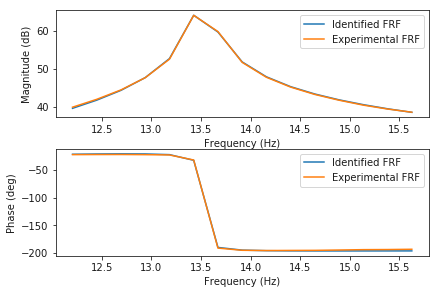

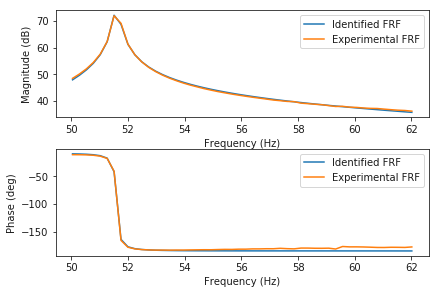

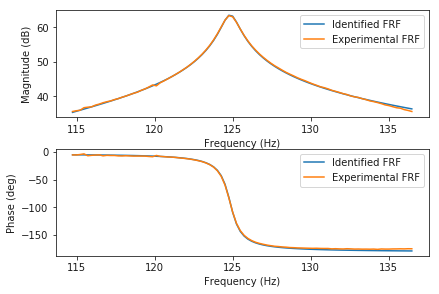

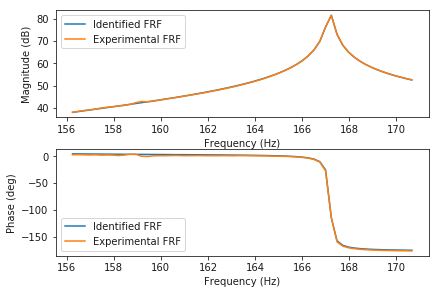

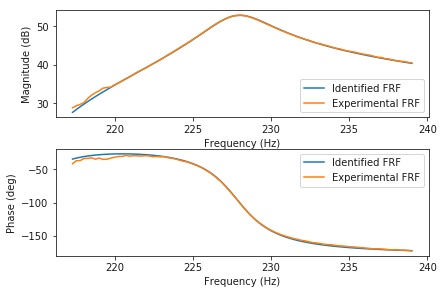

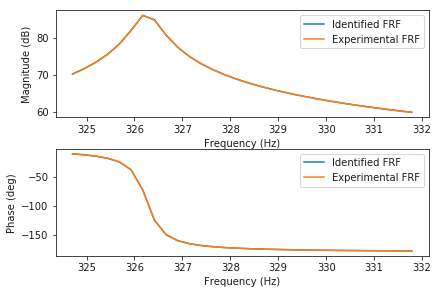

In [89]:
%matplotlib inline
vt.sdof_cf(f,h1,50,65)
vt.sdof_cf(f,h1,205,255)
vt.sdof_cf(f,h1,470,560)
vt.sdof_cf(f,h1,640,700)
vt.sdof_cf(f,h1,890,980)
vt.sdof_cf(f,h1,1330,1360)
plt.show()

**Observation:** 

- Curve fit looks normal for all the modes.


#### Visually validating FRF at point 2:

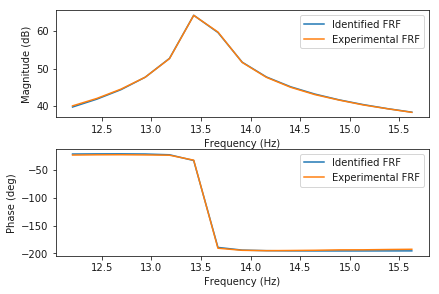

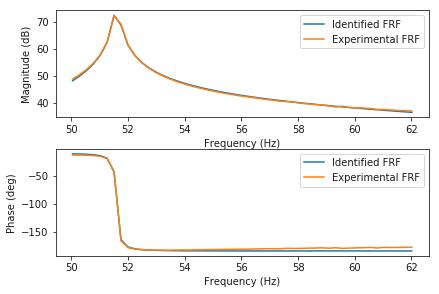

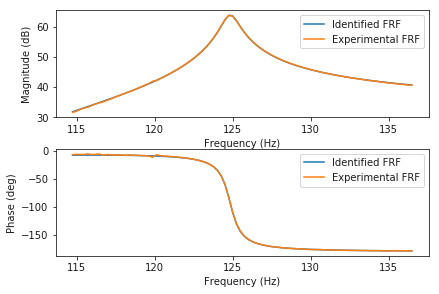

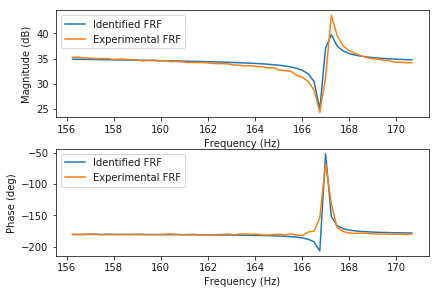

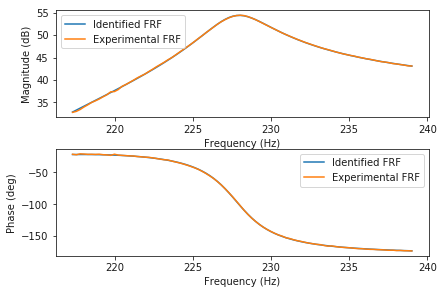

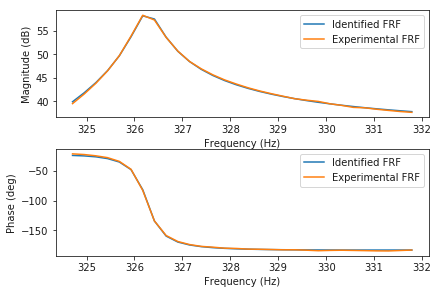

In [90]:
%matplotlib inline
vt.sdof_cf(f,h2,50,65)
vt.sdof_cf(f,h2,205,255)
vt.sdof_cf(f,h2,470,560)
vt.sdof_cf(f,h2,640,700)
vt.sdof_cf(f,h2,890,980)
vt.sdof_cf(f,h2,1330,1360)
plt.show()

**Observations:**

- Curve fit for mode 4 looks bad but still the bounds are not adjusted because there is no Mode 4 at point 2 as it would not move in torsion. So, it's a node. Ajusting it to fit well and using that value for other FRFs may not be reliable. Hence, no changes were made to adjust curve fit.


- Mode 6 bound had anti-resonance, and the curve fit looked unreliable. So, it is corrected by changing the min limit from 1290 to 1330. This is also corrected for rest of the FRFs.

#### Visually validating FRF at point 3:

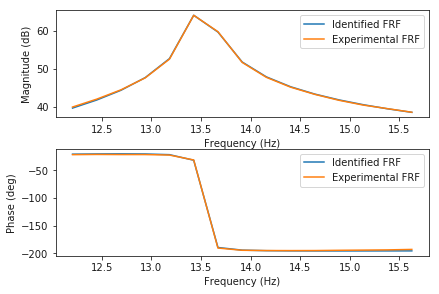

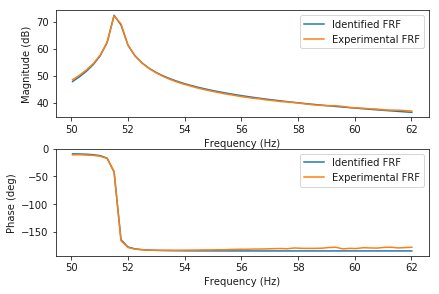

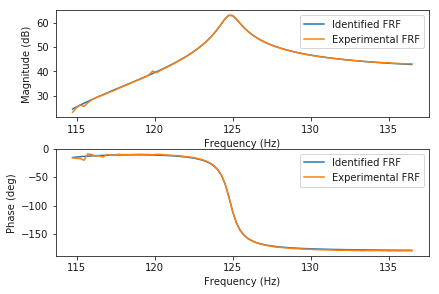

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


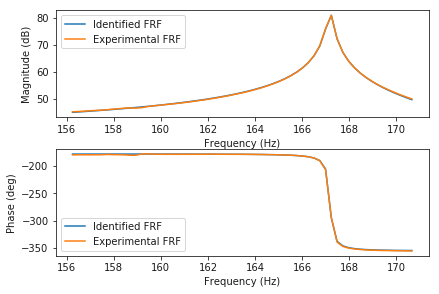

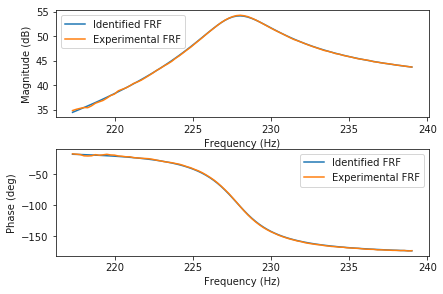

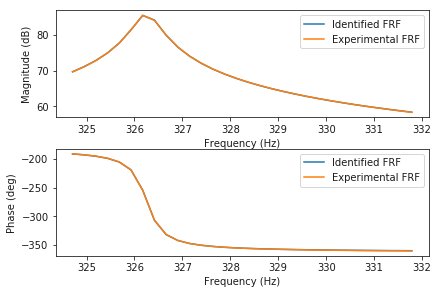

In [91]:
%matplotlib inline
vt.sdof_cf(f,h3,50,65)
vt.sdof_cf(f,h3,205,255)
vt.sdof_cf(f,h3,470,560)
vt.sdof_cf(f,h3,640,700)
vt.sdof_cf(f,h3,890,980)
vt.sdof_cf(f,h3,1330,1360)
plt.show()

**Observation**

- All the modes are very well curve fitted.

#### Visually validating FRF at point 4:

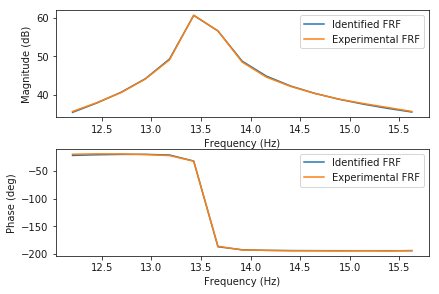

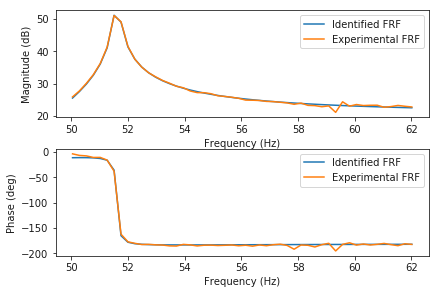

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


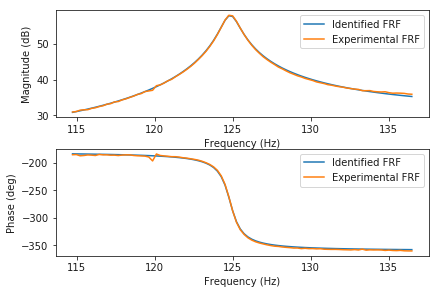

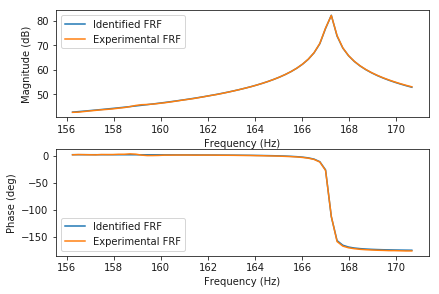

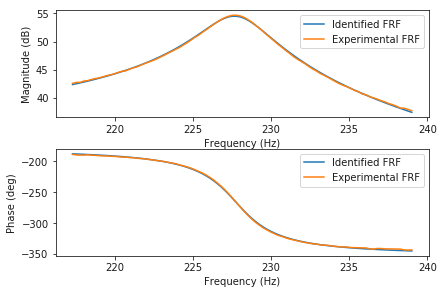

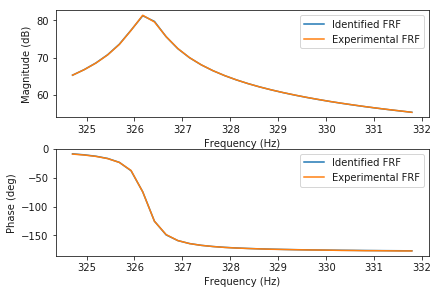

In [92]:
%matplotlib inline
vt.sdof_cf(f,h4,50,65)
vt.sdof_cf(f,h4,205,255)
vt.sdof_cf(f,h4,470,560)
vt.sdof_cf(f,h4,640,700)
vt.sdof_cf(f,h4,890,980)
vt.sdof_cf(f,h4,1330,1360)
plt.show()

**Observations:**

- Mode 1 bound had anti-resonance, and the curve fit looked unreliable. So, it is corrected by changing the min limit from 165 to 205. This is also corrected for rest of the FRFs.

#### Visually validating FRF at point 5:

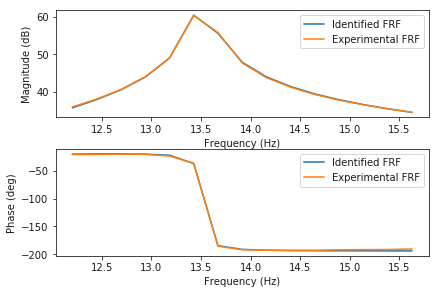

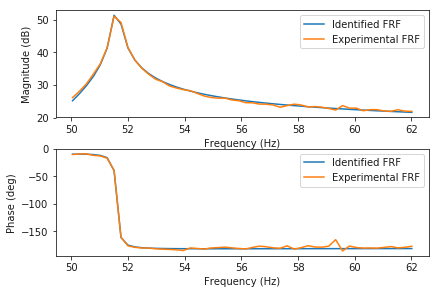

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


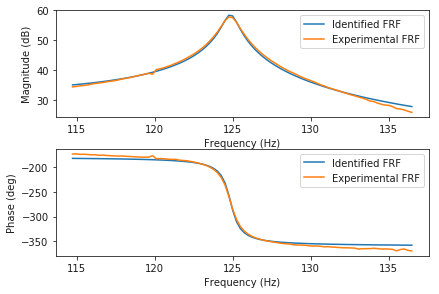

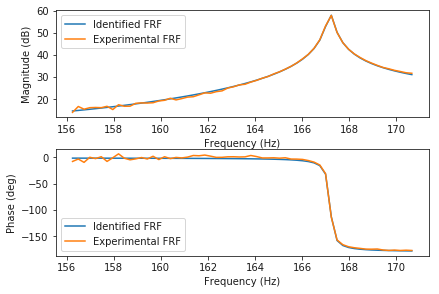

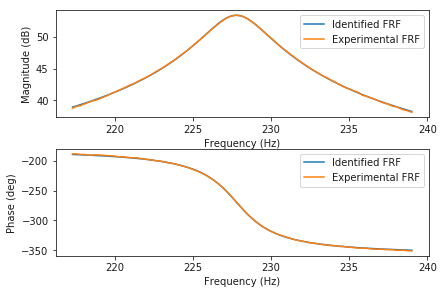

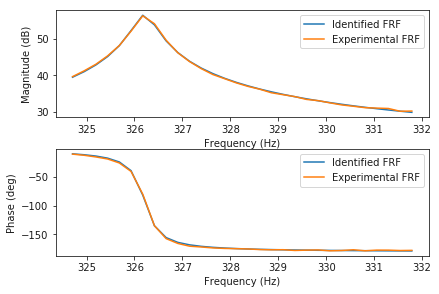

In [93]:
%matplotlib inline
vt.sdof_cf(f,h5,50,65)
vt.sdof_cf(f,h5,205,255)
vt.sdof_cf(f,h5,470,560)
vt.sdof_cf(f,h5,640,700)
vt.sdof_cf(f,h5,890,980)
vt.sdof_cf(f,h5,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.

#### Visually validating FRF at point 6:

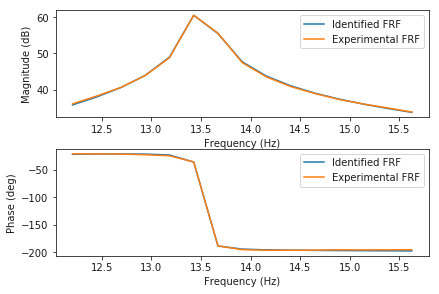

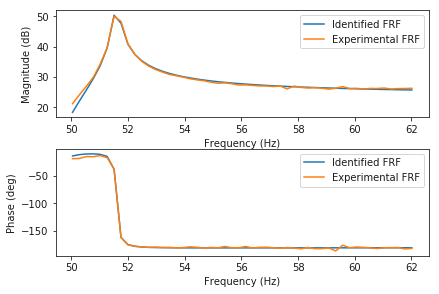

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


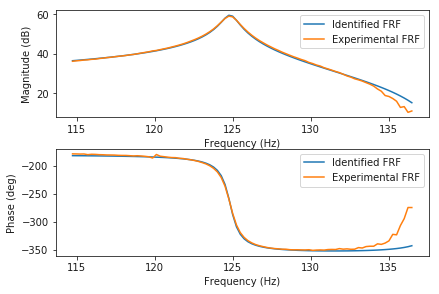

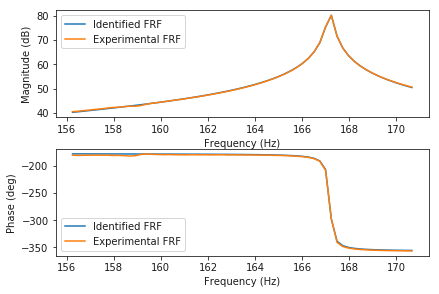

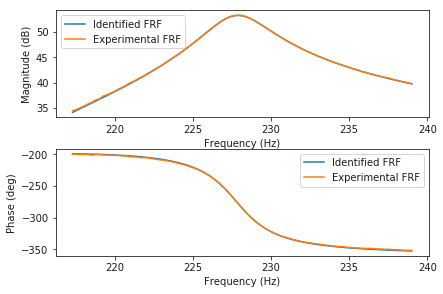

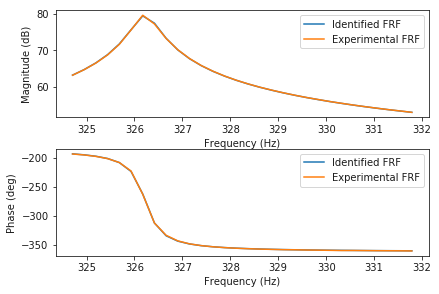

In [94]:
%matplotlib inline
vt.sdof_cf(f,h6,50,65)
vt.sdof_cf(f,h6,205,255)
vt.sdof_cf(f,h6,470,560)
vt.sdof_cf(f,h6,640,700)
vt.sdof_cf(f,h6,890,980)
vt.sdof_cf(f,h6,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.

#### Visually validating FRF at point 7:

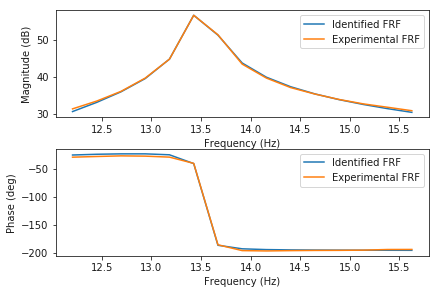

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


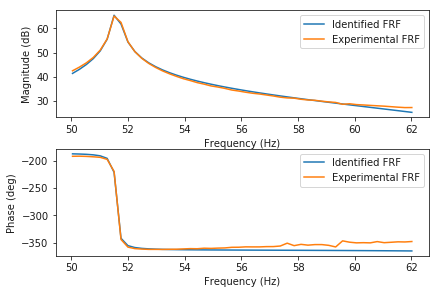

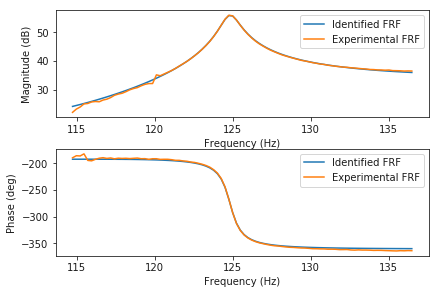

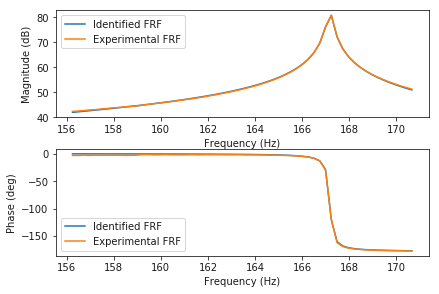

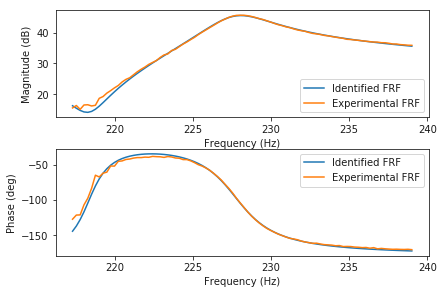

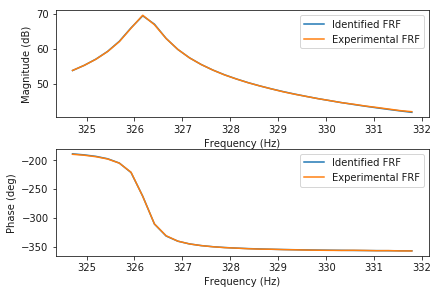

In [95]:
%matplotlib inline
vt.sdof_cf(f,h7,50,65)
vt.sdof_cf(f,h7,205,255)
vt.sdof_cf(f,h7,470,560)
vt.sdof_cf(f,h7,640,700)
vt.sdof_cf(f,h7,890,980)
vt.sdof_cf(f,h7,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.

#### Visually validating FRF at point 8:

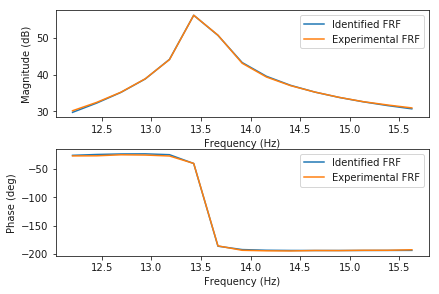

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


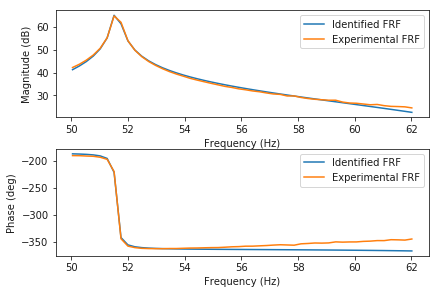

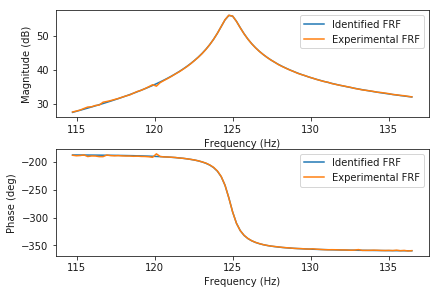

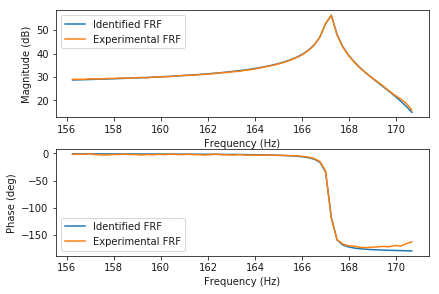

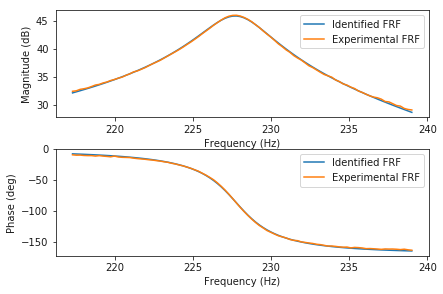

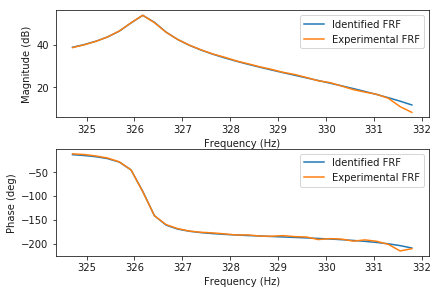

In [96]:
%matplotlib inline
vt.sdof_cf(f,h8,50,65)
vt.sdof_cf(f,h8,205,255)
vt.sdof_cf(f,h8,470,560)
vt.sdof_cf(f,h8,640,700)
vt.sdof_cf(f,h8,890,980)
vt.sdof_cf(f,h8,1330,1360)
plt.show()

**Observations:**

- Mode 6 bound had anti-resonance, and the curve fit looked unreliable. So, it is corrected by changing the max limit from 1390 to 1360. This is also corrected for rest of the FRFs.


- Mode 4 bound had anti-resonance, and the curve fit looked unreliable. So, it is corrected by changing the max limit from 730 to 700. This is also corrected for rest of the FRFs.

#### Visually validating FRF at point 9:

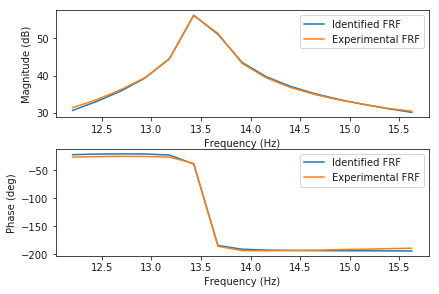

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


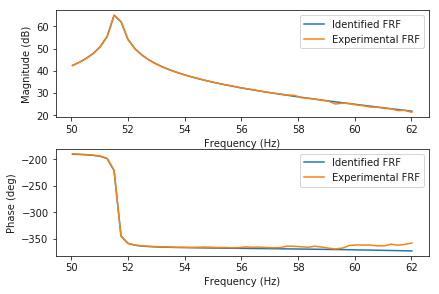

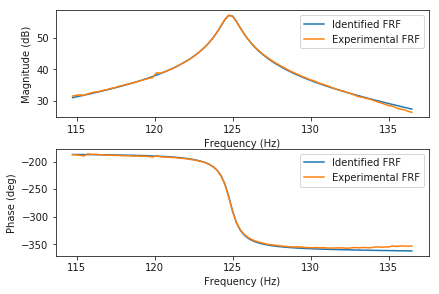

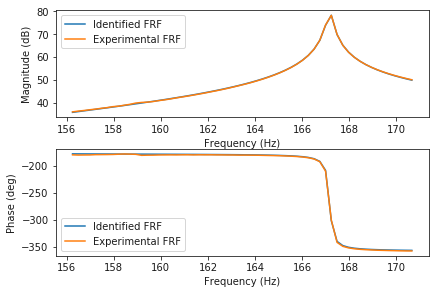

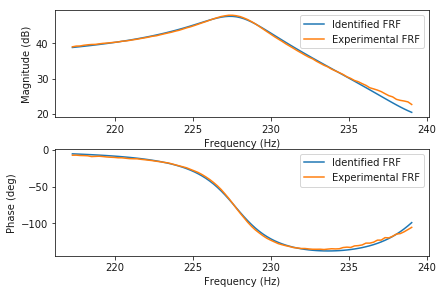

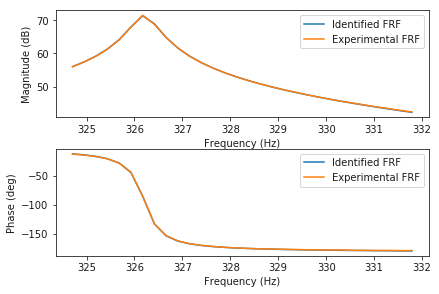

In [97]:
%matplotlib inline
vt.sdof_cf(f,h9,50,65)
vt.sdof_cf(f,h9,205,255)
vt.sdof_cf(f,h9,470,560)
vt.sdof_cf(f,h9,640,700)
vt.sdof_cf(f,h9,890,980)
vt.sdof_cf(f,h9,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.

#### Visually validating FRF at point 10:

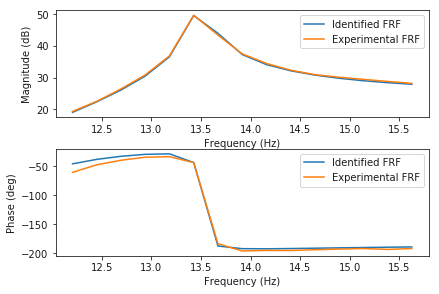

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


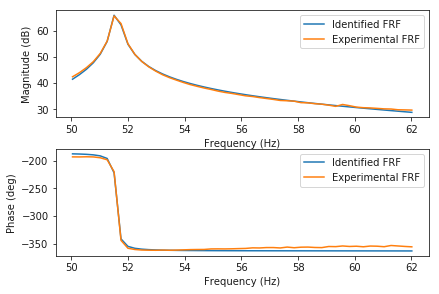

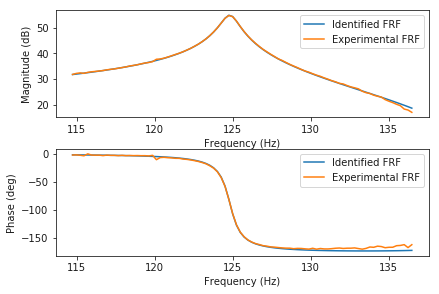

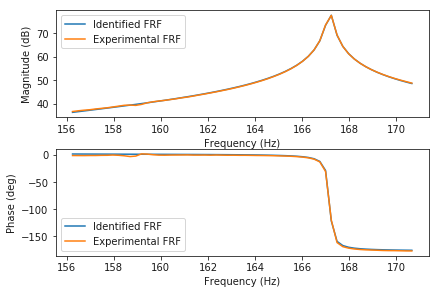

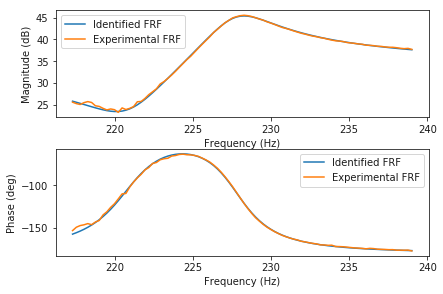

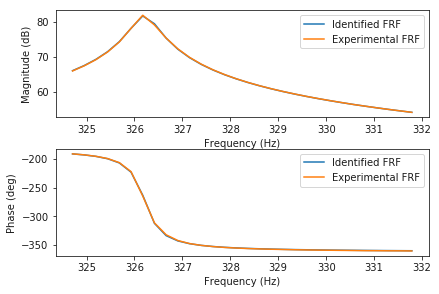

In [98]:
%matplotlib inline
vt.sdof_cf(f,h10,50,65)
vt.sdof_cf(f,h10,205,255)
vt.sdof_cf(f,h10,470,560)
vt.sdof_cf(f,h10,640,700)
vt.sdof_cf(f,h10,890,980)
vt.sdof_cf(f,h10,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.

#### Visually validating FRF at point 11:

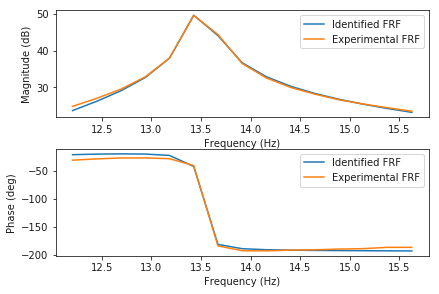

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


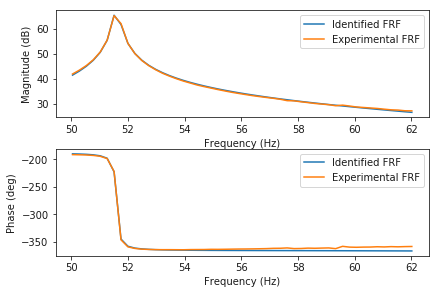

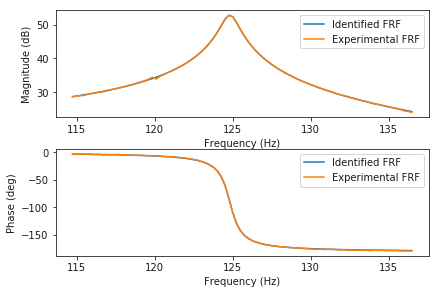

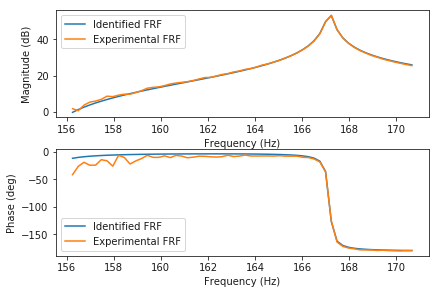

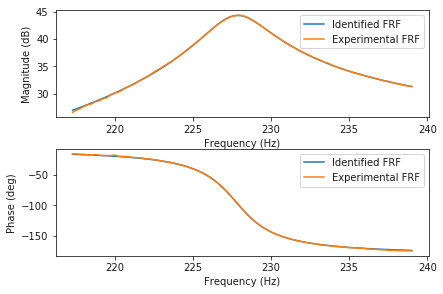

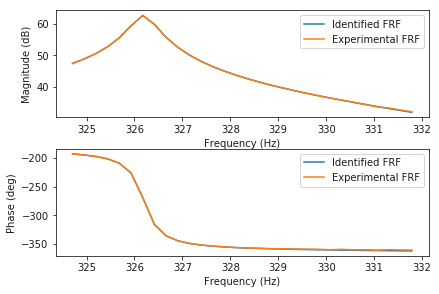

In [99]:
%matplotlib inline
vt.sdof_cf(f,h11,50,65)
vt.sdof_cf(f,h11,205,255)
vt.sdof_cf(f,h11,470,560)
vt.sdof_cf(f,h11,640,700)
vt.sdof_cf(f,h11,890,980)
vt.sdof_cf(f,h11,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.

#### Visually validating FRF at point 12:

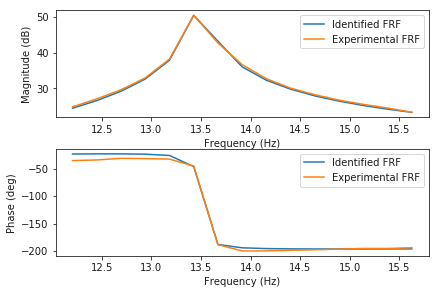

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


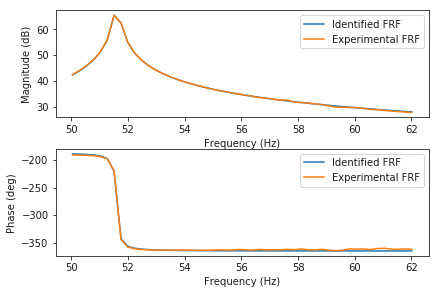

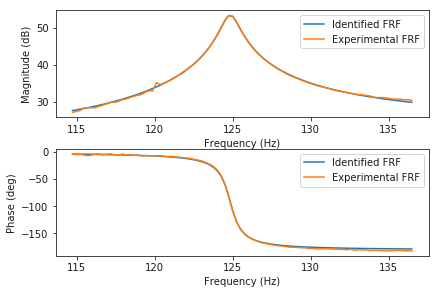

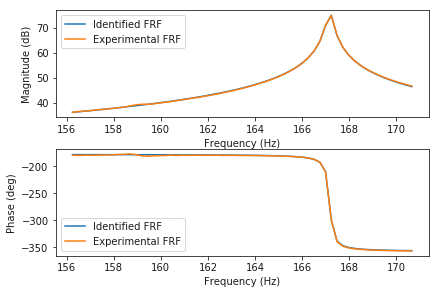

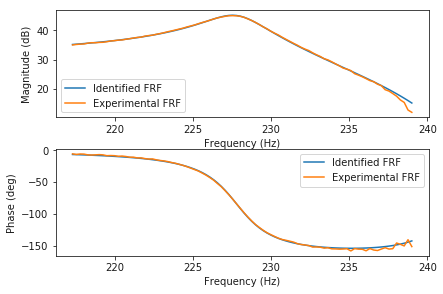

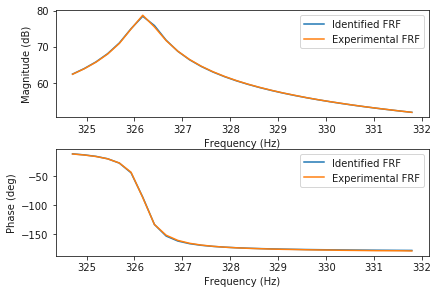

In [100]:
%matplotlib inline
vt.sdof_cf(f,h12,50,65)
vt.sdof_cf(f,h12,205,255)
vt.sdof_cf(f,h12,470,560)
vt.sdof_cf(f,h12,640,700)
vt.sdof_cf(f,h12,890,980)
vt.sdof_cf(f,h12,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.

#### Visually validating FRF at point 13:

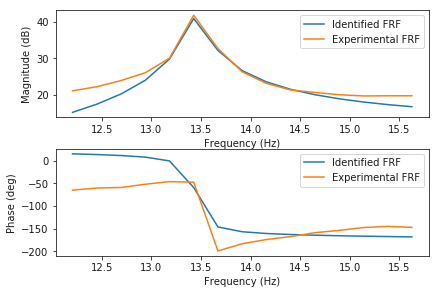

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


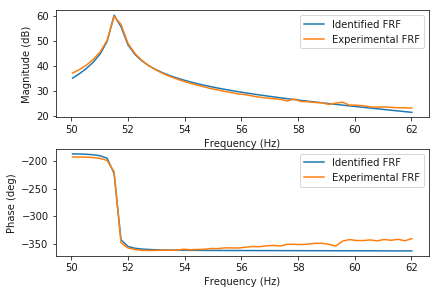

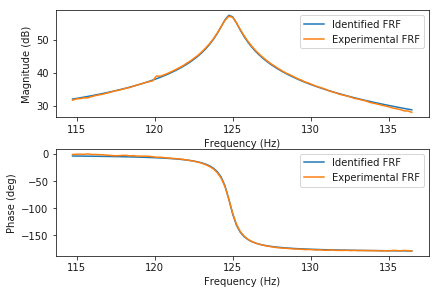

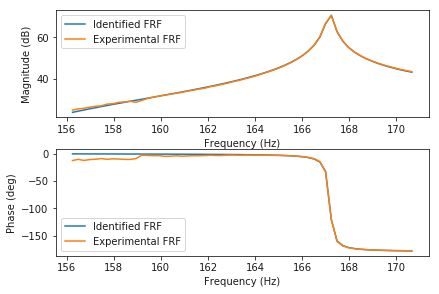

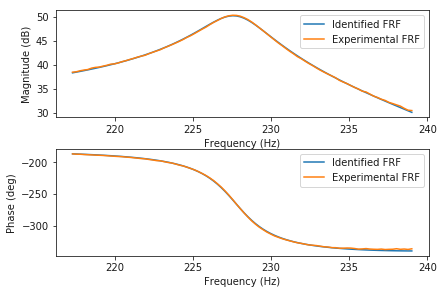

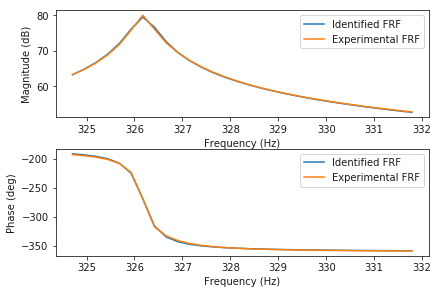

In [101]:
%matplotlib inline
vt.sdof_cf(f,h13,50,65)
vt.sdof_cf(f,h13,205,255)
vt.sdof_cf(f,h13,470,560)
vt.sdof_cf(f,h13,640,700)
vt.sdof_cf(f,h13,890,980)
vt.sdof_cf(f,h13,1330,1360)
plt.show()

**Observations:**

- Mode 1 bound had anti-resonance, and the curve fit looked unreliable. So, it is corrected and made look better by changing the max limit and min limit from 70 to 65 and 40 to 50. This is also corrected for rest of the FRFs.

#### Visually validating FRF at point 14:

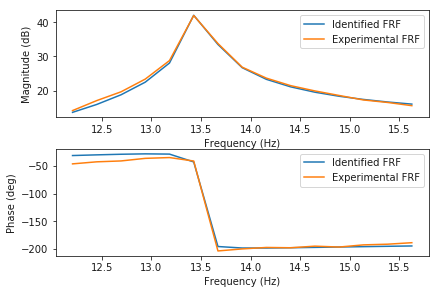

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


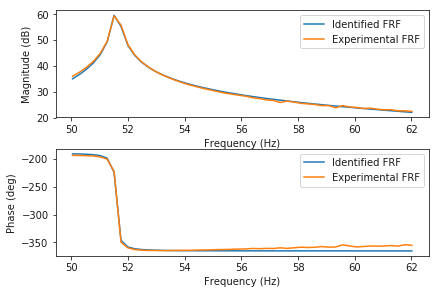

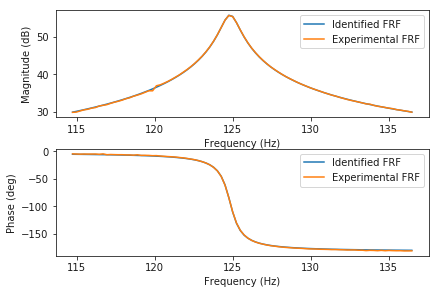

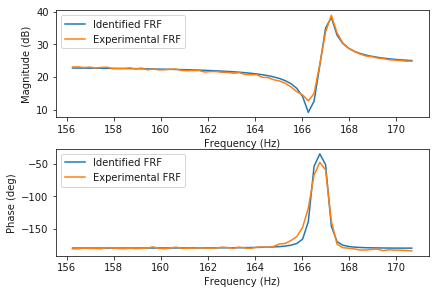

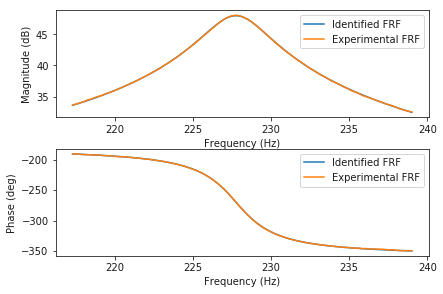

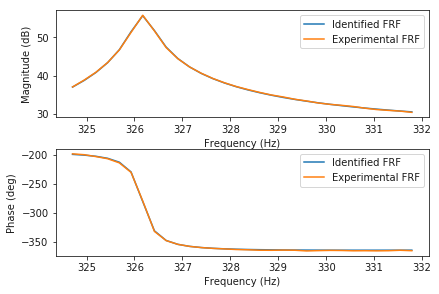

In [102]:
%matplotlib inline
vt.sdof_cf(f,h14,50,65)
vt.sdof_cf(f,h14,205,255)
vt.sdof_cf(f,h14,470,560)
vt.sdof_cf(f,h14,640,700)
vt.sdof_cf(f,h14,890,980)
vt.sdof_cf(f,h14,1330,1360)
plt.show()

**Observation:**

- Curve fit for mode 4 looks bad but still the bounds are not adjusted because there is no Mode 4 at point 14 as it would not move in torsion. So, it's a node. Ajusting it to fit well and using that value for other FRFs may not be reliable. Hence, no changes were made to adjust curve fit.

#### Visually validating FRF at point 15:

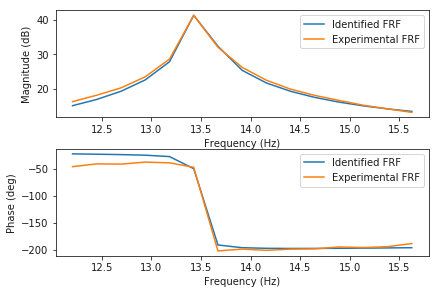

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


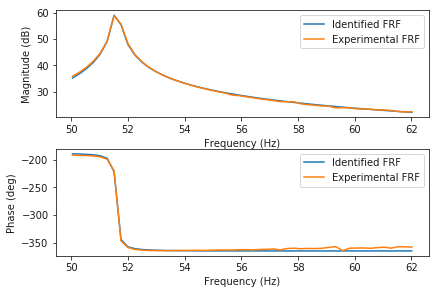

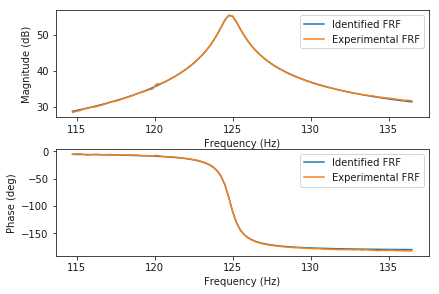

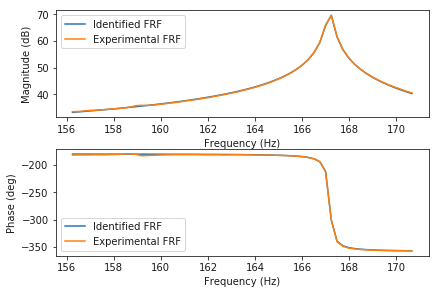

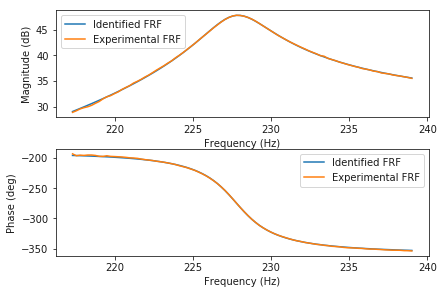

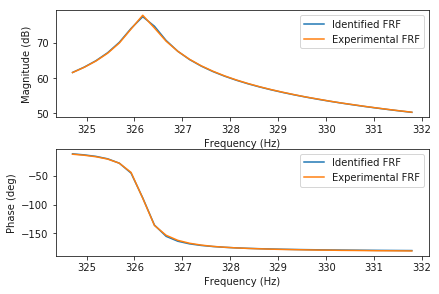

In [103]:
%matplotlib inline
vt.sdof_cf(f,h15,50,65)
vt.sdof_cf(f,h15,205,255)
vt.sdof_cf(f,h15,470,560)
vt.sdof_cf(f,h15,640,700)
vt.sdof_cf(f,h15,890,980)
vt.sdof_cf(f,h15,1330,1360)
plt.show()

**Observations:**

- Curve fit looks fine.



#### Visually validating FRF at point 16:

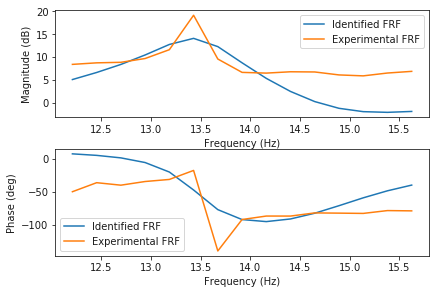

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


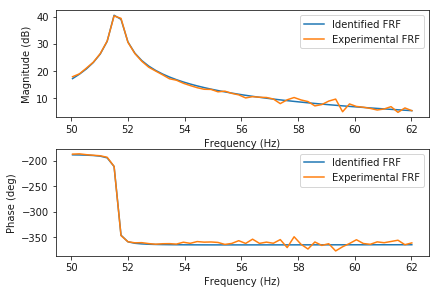

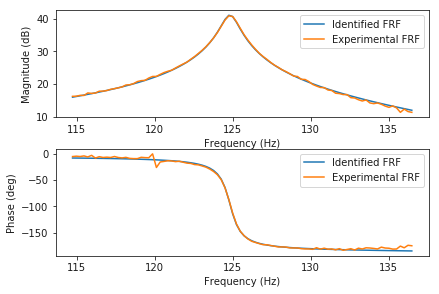

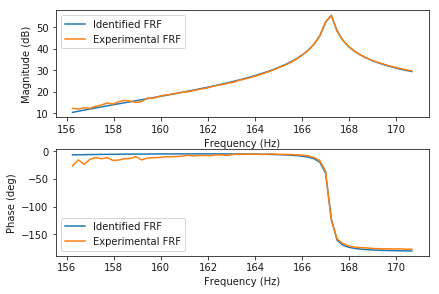

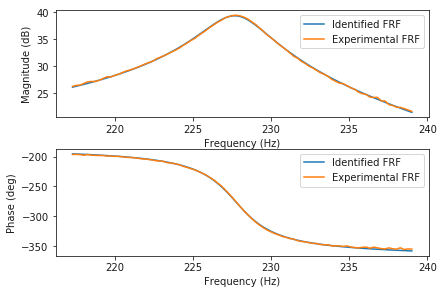

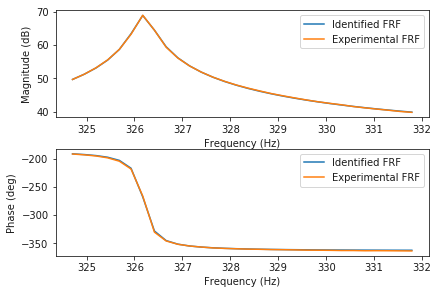

In [104]:
%matplotlib inline
vt.sdof_cf(f,h16,50,65)
vt.sdof_cf(f,h16,205,255)
vt.sdof_cf(f,h16,470,560)
vt.sdof_cf(f,h16,640,700)
vt.sdof_cf(f,h16,890,980)
vt.sdof_cf(f,h16,1330,1360)
plt.show()

**Observation:**
- Curve fit for mode 1 looks bad but still the bounds are not adjusted because there is no Mode 1 at point 16 as it would not move in torsion. So, it's a node. Ajusting it to fit well and using that value for other FRFs may not be reliable. Hence, no changes were made to adjust curve fit.



#### Visually validating FRF at point 17:

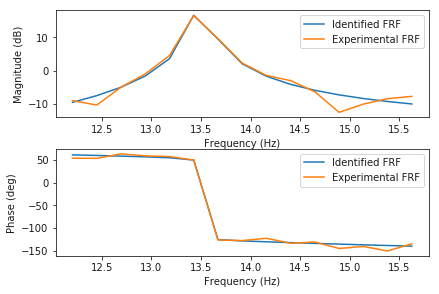

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


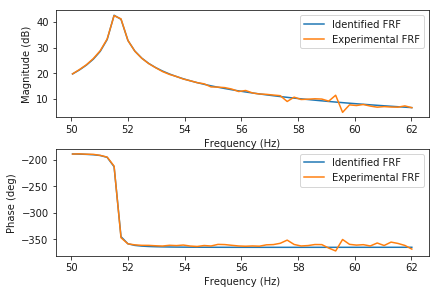

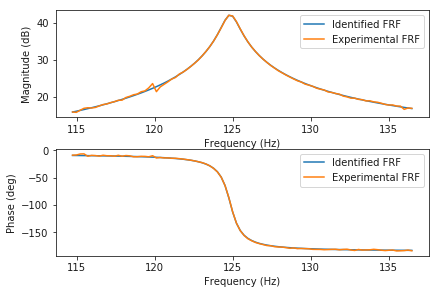

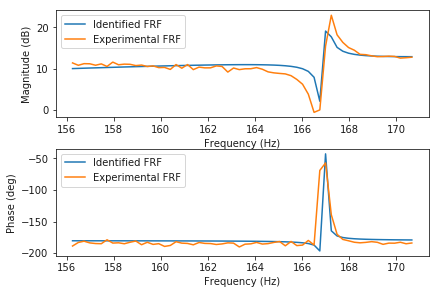

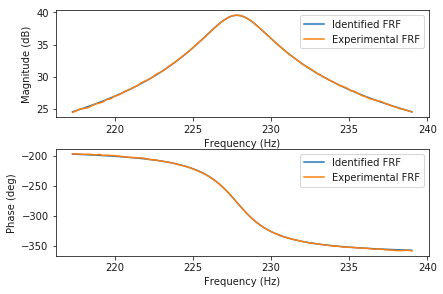

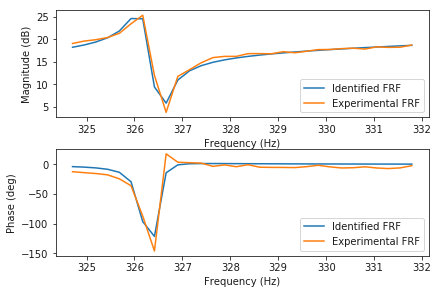

In [105]:
%matplotlib inline
vt.sdof_cf(f,h17,50,65)
vt.sdof_cf(f,h17,205,255)
vt.sdof_cf(f,h17,470,560)
vt.sdof_cf(f,h17,640,700)
vt.sdof_cf(f,h17,890,980)
vt.sdof_cf(f,h17,1330,1360)
plt.show()

**Observation:**
- Curve fit for mode 4 and 6 looks bad but still the bounds are not adjusted because there is no Mode 4 and Mode 6 at point 17 as it would not move in torsion. So, it's a node. Ajusting it to fit well and using that value for other FRFs may not be reliable. Hence, no changes were made to adjust curve fit.



#### Visually validating FRF at point 18:

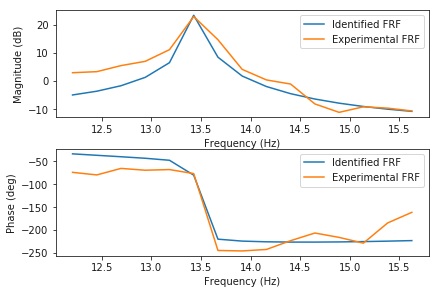

/home/sainag/Desktop/vibrationtesting/vibrationtesting/identification.py:165: RuntimeWarning: invalid value encountered in sqrt
  2 * np.real(a[0]) * np.real(rs[0]))


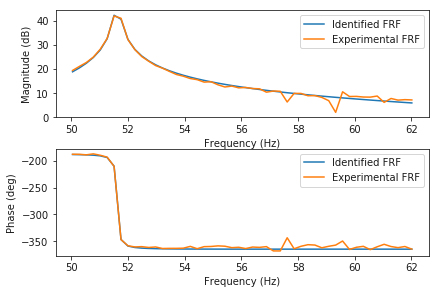

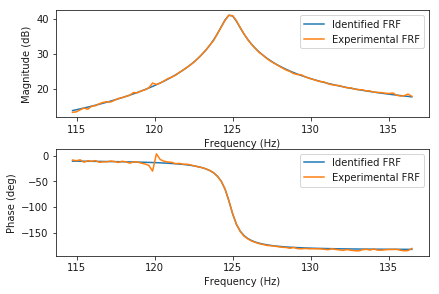

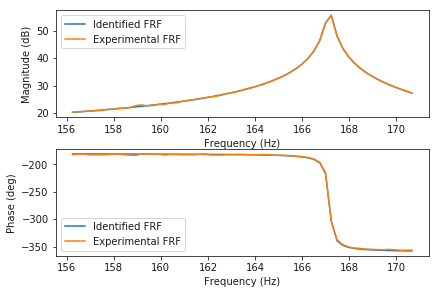

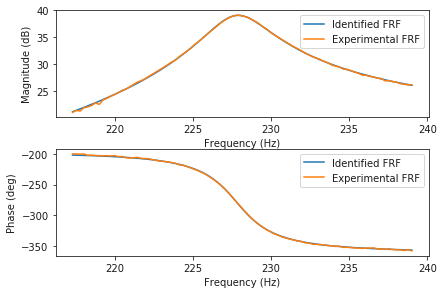

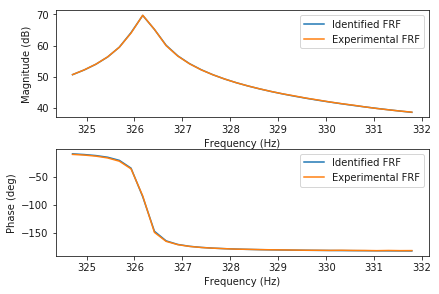

In [106]:
%matplotlib inline
vt.sdof_cf(f,h18,50,65)
vt.sdof_cf(f,h18,205,255)
vt.sdof_cf(f,h18,470,560)
vt.sdof_cf(f,h18,640,700)
vt.sdof_cf(f,h18,890,980)
vt.sdof_cf(f,h18,1330,1360)
plt.show()

**Observation:**
- Curve fit for mode 1 looks bad but still the bounds are not adjusted because there is no Mode 1 at point 18 as it would not move in first bending. So, it's a node. Ajusting it to fit well and using that value for other FRFs may not be reliable. Hence, no changes were made to adjust curve fit.



### Result obtained from MDOF_CF (Single mode) Curve fitting before corrections:

#### Natural Frequencies before correction:

In [107]:
Naturalfreq


(13.513592922165163,
 51.604273251933932,
 124.8398698660464,
 167.17723579950587,
 227.77341036394043,
 326.23424885500293)

#### Damping ratios before correction:

In [108]:
Damping

(0.0019655960141334071,
 0.0013533430499988129,
 0.0040876427711924622,
 0.00062339960942436098,
 0.0085864609141319253,
 0.00074951350217168004)

#### Mode shapes before correction:

In [109]:
Psi_1

array([[   390.134823276,   1366.194032079,   2758.767960332,   4315.189543259,   3929.319061154,  11560.800459018],
       [   388.799543996,   1417.578142842,   2864.548595788,     46.166728102,   4674.348736216,    469.961114479],
       [   390.301079663,   1399.340332269,   2668.802033737,  -4026.320930933,   4585.575731666, -10545.110217327],
       [   264.625736211,    128.883968158,  -1481.535101632,   4684.42632799 ,  -4840.849765858,   6526.996728772],
       [   248.010851716,    129.910499007,  -1471.840766532,    291.231048297,  -4199.869211483,    347.592229302],
       [   249.124209741,    115.477188486,  -1681.472674127,  -3727.624724573,  -4101.238789696,  -5126.39864228 ],
       [   156.179733997,   -627.535212874,  -1182.69771731 ,   4044.931860657,   1676.175969996,  -1616.179105312],
       [   145.998813821,   -599.619966806,  -1202.054140314,    256.015195851,   1775.310914897,    253.092723114],
       [   150.716528321,   -611.084712374,  -1328.946528692,  -

### MDOF(Single mode) Curve fitting after correcting bounds:

In [110]:
TF= np.column_stack((h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18))
[Damping1,naturalfreq1,U1]=vt.mdof_cf(f,TF,50,65)
[Damping2,naturalfreq2,U2]=vt.mdof_cf(f,TF,205,255)
[Damping3,naturalfreq3,U3]=vt.mdof_cf(f,TF,470,560)
[Damping4,naturalfreq4,U4]=vt.mdof_cf(f,TF,640,700)
[Damping5,naturalfreq5,U5]=vt.mdof_cf(f,TF,890,980)
[Damping6,naturalfreq6,U6]=vt.mdof_cf(f,TF,1330,1360)
Damping = Damping1, Damping2, Damping3, Damping4, Damping5, Damping6
Naturalfreq = naturalfreq1, naturalfreq2, naturalfreq3, naturalfreq4, naturalfreq5, naturalfreq6
Psi_1 = np.array(U1)
Psi_2 = np.array(U2)
Psi_3 = np.array(U3)
Psi_4 = np.array(U4)
Psi_5 = np.array(U5)
Psi_6 = np.array(U6)
Psi_1=np.column_stack((Psi_1,Psi_2,Psi_3,Psi_4,Psi_5,Psi_6))
Psi_abs = np.abs(Psi_1)*np.real(np.sign(Psi_1))
Psi_1 = Psi_abs

## Using "Least Square Complex Frequency domain method" from OpenModal GUI



The following two paragraphs are directly pasted from the help part for the code lscf.py in OpenModal software:

The LSCF method is an frequency-domain Linear Least Squares estimator optimized  for modal parameter estimation. The choice of the most important algorithm characteristics is based on the results in [1] (Section 5.3.3.) and can be summarized as:- Formulation: the normal equations [1] (Eq. 5.26: [sum(Tk - Sk.H * Rk^-1 * Sk)]*ThetaA=D*ThetaA = 0)are constructed for the common denominator discrete-time model in the Z-domain. Consequently, by looping over the outputs and inputs, the submatrices Rk, Sk, and Tk are formulated through the use of the FFT algorithm as Toeplitz structured (n+1) square matrices. Using complex coefficients, the FRF data within the frequency band of interest (FRF-zoom) is projected in the Z-domain in the interval of [0, 2*pi] in order to improve numerical conditioning. (In the case that real coefficients are used, the data is projected in the interval of [0, pi].) The projecting on an interval that does not completely describe the unity circle, say [0, alpha*2*pi] where alpha is typically 0.9-0.95. Deliberately over-modeling is best applied to cope with discontinuities. This is justified by the use of a discrete time model in the Z-domain, which is much more robust for a high order of the transfer function polynomials.

Solver: the normal equations can be solved for the denominator coefficients ThetaA by computing the Least-Squares (LS) or mixed Total-Least-Squares (TLS) solution. The inverse of the square matrix D for the LS solution is computed by means of a pseudo inverse operation for reasons of numerical stability, while the mixed LS-TLS solution is computed using an SVD (Singular Value Decomposition).

**Using LSCF Curve fitting and Modal parameter estimation, commonly called as Stabilization Diagram** 
![alt](img/LSCF)

The above curve fitting was done using OpenModal GUI. 

All the 18 individual FRFs are combined to form one single FRF which is referred to as Stabilization diagram. So, it is essentially taking all the FRFs and doing some matrix math by combining all to get one representative Sum FRF. And then we curve fit the stabilization diagram specifying a range of frequencies of interest to determine the location of the modes, the natural frequencies, the damping and the mode shapes. 

The max order is given as thirty, which means 30 iterations. The number of iterations depends on the repeatability of the results iteration after iteration. Usually, we can stop at 3rd or 4th iteration after it becomes stable. If it continues then eventually things start to break down because the system starts to find more and more resonance that don't exist. Therefore, we up the order until a pretty good estimation of stable modes are attained, very lower orders would not guess every mode and the results may not be accurate. The symbol '+' indicates stable poles and frequency values, the yellow dot is an indication of stable damping value.

Apart from the actual FRF and the curve fitter in blue, we can also see response signal in green which is  called as Mode Indicator function. MIF goes through all of the FRFs, here we have 18 which is a very small test, many other tests have hundreds of those. So, here it goes through 18 FRFs and globally determine if we really have a mode at a location or not. Because at some of these measurements  there is no motion, those are called nodes on the structure. Hence, we cannot have just one measurement to determine that.



## Using another MDOF curve fitter "Least Square Complex Exponential Curve Fitter" 



**LSCE: **

This is the more traditional curve fitter usually most softwares use. This curve fitter can curve fit all the resonances at a time which is better because it takes into account the influence of one mode on the other. In this case, no complexity in the data set observed because every peak is well seperated. However, some FRFs are very difficult to determine what is happening and in that case a global curve fitter which curve fits multiple resonances at a time would be a better option to choose.

The Least-Squares Complex Exponential method (LSCE), is the extension of the Complex Exponential method (CE) to a global procedure. It is therefore a SIMO method, processing simultaneously several IRFs obtained by exciting a structure at one single point and measuring the responses at several locations. With such a procedure, a consistent set of global parameters (natural frequencies and damping factors) is obtained, thus overcoming the variations obtained in the results for those parameters when applying the CE method on different IRFs.



![alt](img/LSCE)

**Important Observations:**

**Mass loading error (in order to mass load used 499 mv/g accel, sensitivity directly proportional to weight of accel as discussed in the accel section above):** '+' implies found stable modes and natural frequencies. If we look at the stability diagram, the system split to find two closely spaced modes and natural frequencies. And that is not because of repeated roots, MIF tells this correctly if there are more than two reference accels but a good observation from the stabilization diagram should leave us with a doubt of why would each and every mode split into two. In addition, if we truely had closely spaced modes FE model has to show that as well. Hence, the system split because of the mass loading,  This is because the data set was not good. It is also important to keep in mind that some of these splits might be artifacts of the  model order value being used for the analysis.

This was resolved by getting ride off those split sytem's '+' columns, by selecting the stable modes that make sense which also gives a synthesized FRF to visualize how the data overlays with it, this can be called as model validation where the envelop FRF's and the individual FRF's curve fit is looked at for proper fit, to make sure the model parameter estimates obtained were accurate. The best curve fit depends on the size of the model order used. Therefore, the model order is the only dial that we have in the traditional curve fitters and the rule of thumb for verification is to check the overlay with the synthesized FRF.

The other way to approach this is to do curve fitting differently that is not global like above but local as we already done before. Local means that each measurement is going to be curve fitted one by one.

In order to be sure about the results obtained from curve fitting, three different curve fitter were used to mix and match the results.

### Results from curve fitting using Global curve fitters with mass loading issue :

In [111]:
NaturalfreqGlobalCF=Naturalfreq
NaturalfreqGlobalCF

(13.516125495327145,
 51.602555175851712,
 124.8398698660464,
 167.17677576486767,
 227.77341036394043,
 326.23386712013291)

In [112]:
DampingGlobalCF=Damping
DampingGlobalCF

(0.0017411648392746146,
 0.0012488031601881739,
 0.0040876427711924622,
 0.00062677328877069872,
 0.0085864609141319253,
 0.00074953837145838294)

In [113]:
#Psi_2=Psi_1[:15,:]
Psi_GlobalCF=Psi_1[:15,:]
Psi_Test=Psi_1

## Results from Local curve fitting:

In [114]:
NaturalFreqlocal= 13.516, 51.607, 124.838, 167.175, 227.759, 326.254
NaturalFreqlocal

(13.516, 51.607, 124.838, 167.175, 227.759, 326.254)

In [115]:
Dampinglocal= 0.00164, 0.00119, 0.00413, 0.000614, 0.00875, 0.000729
Dampinglocal

(0.00164, 0.00119, 0.00413, 0.000614, 0.00875, 0.000729)

In [116]:
mat_contents=sio.loadmat('Modeshapedata/1stNaturalFreq15.mat')
U1 = mat_contents['U1']
mat_contents=sio.loadmat('Modeshapedata/2ndNaturalFreq15.mat')
U2 = mat_contents['U2']
mat_contents=sio.loadmat('Modeshapedata/3rdNaturalFreq15.mat')
U3 = mat_contents['U3']
mat_contents=sio.loadmat('Modeshapedata/4rthNaturalFreq15.mat')
U4 = mat_contents['U4']
mat_contents=sio.loadmat('Modeshapedata/5thNaturalFreq15.mat')
U5 = mat_contents['U5']
mat_contents=sio.loadmat('Modeshapedata/6thNaturalFreq15.mat')
U6 = mat_contents['U6']
Psi_1 = np.array(U1)
Psi_2 = np.array(U2)
Psi_3 = np.array(U3)
Psi_4 = np.array(U4)
Psi_5 = np.array(U5)
Psi_6 = np.array(U6)
Psi_1=np.column_stack((Psi_1,Psi_2,Psi_3,Psi_4,Psi_5,Psi_6))
Psi_abs = np.abs(Psi_1)*np.real(np.sign(Psi_1))
Psi_local = Psi_abs

## Analysis Validation

The Validation process consist into 3 steps required to validate modal results to make sure the curve fitting process was done properly and real modes have been selected and that errors like mode duplication due to variable mass loading have been avoided:

- **Animation**


- **AutoMAC**


- **CrossMAC**

### Animation of the curve fit results:

![alt](img/LS01) ![alt](img/LS02) ![alt](img/LS03) ![alt](img/LS04) ![alt](img/LS05) ![alt](img/LS06) 

### Validation with Auto and Cross MAC

### MAC:

The Modal Assurance Criterion (MAC) analysis is used to determine the similarity of two mode shapes:

* If the mode shapes are identical (i.e., all points move the same) the MAC will have a value of one or 100%. 


* If the mode shapes are very different, the MAC value will be close to zero.
 
*Note: A MAC analysis is only looking at the mode shape, it does not compare the frequency value.* 
 
#### MAC Equation:
 
The MAC value between two modes is essentially the normalized dot product of the complex modal vector at each common nodes (i.e., points), as shown in Equation.  It can also be thought of as the square of correlation between two modal vectors φr and φs. Equation below is the Modal Assurance Criterion equation for comparing two mode shapes:



![alt](img/image.png)(Reference for the figure: [Siemens Corp. Seminar](https://community.plm.automation.siemens.com/t5/Event-Collateral/Modal-Analysis-and-FEA-Test-Correlation/ta-p/435288))



If a linear relationship exists (i.e., the vectors move the same way) between the two complex vectors, the MAC value will be near to one. If they are linearly independent, the MAC value will be small (near zero).
 
A complex vector simply includes both amplitude and phase, whereas a real vector is real part only. In Equation, it is also clear that the MAC is not sensitive to scaling, so if all mode shape components are multiplied with the same factor, the MAC will not be affected.

If an experimental modal analysis had 18 different nodes where measurements were made, the mode shape components at all 18 nodes are taken into account to calculate the MAC value, but more importance will be attributed to the higher amplitude node locations.
             


### Auto MAC

#### Test-Test Comparison:

The important thing to remember while doing modal analysis is that, when there is a structure, we need to know how many points along the structure to test. If the number of points are insufficiently guessed then at high frequencies, the mode shapes would essentially look like a rigid body motion or the modes at different frequencies look like the same mode due to not enough points on the structure which is similar to aliasing, when thought of about reading in frequencies by not sampling high enough, the same thing can be done to a structure by not putting enough points to accurately capture a motion. So, one way to check that enough points were used to accurately capture all of the different mode shapes is by using something called the MAC matrix.

This MAC matrix in Auto MAC compares one set of mode shapes to itself. On-diagnonal terms should be 1 and off-diagonal terms should be close to zero for a good MAC.


** What percent is acceptable for an off-diagonal?** There isn't like a cut-off value that is universally accepted. But, by looking at the mode shapes visually, if they appear distinct then that's good enough. It is important to keep in mind that mode shapes get more complex as we go higher in frequencies so to capture those complex localized modes require many accelerometers. For instance, if first 25 modes need to be captured then 18 points would not be sufficient, in this case MAC plays a major role in deciding number of points.


One of the important points which is already addressed in the above sections is that FE analysis can identify exactly how many points are needed on the structure to  prevent spacial aliasing. Usually, in commercial software, we can do a pre-test analysis to figure out the exact locations to put the points on the structure as in real world complex structures often localized deformations are seen.


Therefore, to get a good MAC it is important to know how many points to put on the structure and the locations of those points on the structure, a Pre-test analysis on a FE model in a commercial software would give us the locations of the accelerometers based on the complexity of the structure such as welds, localized deformations, etc., as well as the frequency range of interest. This is discussed in the above sections as **"Steps in real world pre-test analysis"** .



**Note:** The term used of "not enough response points" is called "Spacial Aliasing".*



**Reasons for higher off-diagonal terms in Auto MAC (For Test results):**

- Measurement problem


- Curve fit problem


- Spacial Aliasing





#### Auto MAC for the Local Curve fit results

In [117]:
vt.mac(Psi_local,Psi_local)

array([[ 1.         ,  0.012878134,  0.024564134,  0.021402321,  0.04530025 ,  0.00297411 ],
       [ 0.012878134,  1.         ,  0.05357427 ,  0.003010583,  0.008900821,  0.01555768 ],
       [ 0.024564134,  0.05357427 ,  1.         ,  0.002131827,  0.162034548,  0.00183518 ],
       [ 0.021402321,  0.003010583,  0.002131827,  1.         ,  0.000965057,  0.020653144],
       [ 0.04530025 ,  0.008900821,  0.162034548,  0.000965057,  1.         ,  0.000017919],
       [ 0.00297411 ,  0.01555768 ,  0.00183518 ,  0.020653144,  0.000017919,  1.         ]])

#### Auto MAC for the Global Curve fit results

In [118]:
vt.mac(Psi_GlobalCF,Psi_GlobalCF)

array([[ 1.         ,  0.269073894,  0.102481622,  0.007401745,  0.069646662,  0.003066059],
       [ 0.269073894,  1.         ,  0.304444271,  0.000951484,  0.123910692,  0.004512516],
       [ 0.102481622,  0.304444271,  1.         ,  0.000138272,  0.318991573,  0.000658865],
       [ 0.007401745,  0.000951484,  0.000138272,  1.         ,  0.005198078,  0.166818968],
       [ 0.069646662,  0.123910692,  0.318991573,  0.005198078,  1.         ,  0.001116943],
       [ 0.003066059,  0.004512516,  0.000658865,  0.166818968,  0.001116943,  1.         ]])

**AUTO MAC for Locally curve fitting is much better with low off-diagonal terms compared to Global curve fit results**



In the above case, this is a mode set compared to itself.  The mode set contains six different individual modes, so 36 different MAC values are being calculated. About half the values are redundant –e.g., the MAC value between mode 1 and 3 is the same as between mode 3 and 1.

The first mode shape at 13 Hz is identical to itself, hence a value of 1. Along the diagonal, every mode is identical to itself, 1 to 1 (13 Hz), 2 to 2 (51 Hz), 3 to 3 (121 Hz), etc.

If the off-diagonal MAC values are very low then that means the modes are not coherent to each other, they are completely separated, the accurate word being completely orthogonal(very different).  Ideally, each mode should be uniquely observed and have a different shape than the other modes.  This is the case for this mode set.  

**For Local Curve fit**

The highest off diagonal mode pair is mode 5 compared to mode 3 (and vice versa 3 to 5) with a MAC value of 16%. All the other off-diagonal mode pairs are below 16%. 

**Important Note:** In experimental modal analysis, if instead of 18 points on the wing, the data is only measured in the 9 points then modal analysis is not "wrong". The FRF measurements at these nodes were no different in the 9 point modal versus the 18 point, since the physical structure being tested did not change.  There was simply not enough measurement points to determine the complete mode shape.  This is different than a Finite Element modal analysis where the number of nodes does determine the dynamic behavior.


#### Analysis Validation - Cross Mac



The CrossMac allows to compare two different shape tables obtained by two different curve fitting process. A good diagonal table will show that the two method agrees. Here we compare the Local curve fit with Global Curve fit and both aggress very well. However, not as expected due the issue of mass load with the global curve fitter.

Again off diagonal values should be very low.

In [119]:
vt.mac(Psi_local,Psi_GlobalCF)

array([[ 0.889809878,  0.055193656,  0.058956073,  0.014040708,  0.031198815,  0.002067656],
       [ 0.175763199,  0.929630918,  0.125022088,  0.000474301,  0.03448333 ,  0.008489398],
       [ 0.039119618,  0.178799012,  0.962237434,  0.000375055,  0.22862116 ,  0.001127759],
       [ 0.009763823,  0.00402185 ,  0.000184735,  0.949126268,  0.009918751,  0.084585362],
       [ 0.075319976,  0.058786428,  0.230012177,  0.000227881,  0.954436118,  0.000270986],
       [ 0.007821413,  0.010061935,  0.000838266,  0.072848187,  0.000199366,  0.926332305]])

## Correlation FEM vs Test


#### What is Correlation?




- Correlation is the relationship between two or more things. Correlating is comparing two data sets and establishing a level of coherence or similarity between the two datasets.


- Correlation is a broad term often overloaded in Structural Dynamics. Customer will often refer to correlation when discussing:
        
     - Pretest Planning
     - Model Updating
     - Vector Comparison
     

**Importance of Correlation:**

- The main focus of correlation is getting the FE model to as accurate as possible by doing some design refinement using the test data. Because of the fact that the updated FE model will closely representing the real world, hence, it is used in conducting different analysis such as vibration analysis, loads analysis, acoustics, durability etc., there by developing the model a head of time to be able to withstand the critical real world phenomenon. Therefore, we need to have the base FE model as accurate as possible as far as Mass, Stiffness, Damping, Natural Frequency, and mode shapes.






### Difference between FEM and Test:


- Many more FEM DOF's than Test DOF's
     - More FEM DOF's are required for the model accuracy
        - FEM models are made of nodes and elements
     - Cost, complexity and mass loading limit the number of test DOF's
     
     
- Test DOF's may not be collocated with FEM DOF's


- Test and FEM may have different orientations


- FEM models do not typically incorporate damping


- Test modes typically are complex modes


- Mode Scaling and units can be different 


- A Mass and Stiffness matrix are calculated during the FEM solution


- A Mass, Stiffness and Damping matrix cannot be estimated from a Modal Test


- Boundary Conditions: Fixed or Free-Free?

### Beam Element model: 

A Matlab code was developed to solve different problems using 3D beam/rod/torsion element inside WFEM module by simply creating an input file.  The mode shapes were already shown above with 18 point using this beam element.

### Resulting eigen vectors from FE model:

In [120]:
mat_contents=sio.loadmat('FEmodaldata/WingBeamforMAC.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbm = K.todense()
Mbm = M.todense()
omega, zeta, PsiBM = vt.sos_modal(Mbm, Kbm, damp_diag=0)
Psi_1 = PsiBM
mode1=Psi_1[:,0]
mode2=Psi_1[:,1]
mode3=Psi_1[:,3]
mode4=Psi_1[:,4]
mode5=Psi_1[:,5]
mode6=Psi_1[:,6]

Psi_2BM= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))



### Brick Element model: This model is puposely built bad to see how the auto updating of the model using test data works

Similar to Beam code, an 8 noded Brick element was developed. 


**Note:** Beam model gave better results with lesser mesh compared to Brick model. Thereby saving computational time.


The following are results obtained:

In [121]:
mat_contents=sio.loadmat('FEmodaldata/WingBrickmuchMorMeshedforMAC1.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbr = K.todense()
Mbr = M.todense()
omega, zeta, PsiBR = vt.sos_modal(Mbr, Kbr, damp_diag=0)
Psi_1 = PsiBR
mode1=Psi_1[:,0]
mode2=Psi_1[:,1]
mode3=Psi_1[:,3]
mode4=Psi_1[:,4]
mode5=Psi_1[:,5]
mode6=Psi_1[:,6]

Psi_2BR= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))





![alt](img/Brickmodelmode1.jpg) | ![alt](img/Brickmodelmode2.jpg) | ![alt](img/Brickmodelmode3.jpg) 

![alt](img/Brickmodelmode4.jpg) | ![alt](img/Brickmodelmode5.jpg) | ![alt](img/Brickmodelmode6.jpg)

### FE model Damping:

- Important point to note is that the FE model did not spit out damping values. So, FE model has no damping included. However, damping is one of the important things when it comes to correlating FE models with the Test data. Damping values from the test data will be added to the FE model while correcting the FE model in the later sections.


### FE-FE comparison: Auto MAC

The below off-diagonal MAC values tell how bad the assumptions made were. We can observe that off-diagonal terms for the Brick model look better because of more mesh.


In [122]:
vt.mac(Psi_2BM,Psi_2BM)

array([[ 1.         ,  0.28416901 ,  0.172196744,  0.         ,  0.132407293,  0.         ],
       [ 0.28416901 ,  1.         ,  0.371274112,  0.         ,  0.235979076,  0.         ],
       [ 0.172196744,  0.371274112,  1.         ,  0.         ,  0.379744752,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  1.         ,  0.         ,  0.240949039],
       [ 0.132407293,  0.235979076,  0.379744752,  0.         ,  1.         ,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  0.240949039,  0.         ,  1.         ]])

In [123]:
vt.mac(Psi_2BR,Psi_2BR)

array([[ 1.         ,  0.122984639,  0.041348987,  0.         ,  0.026004283,  0.         ],
       [ 0.122984639,  1.         ,  0.157153609,  0.         ,  0.060581719,  0.         ],
       [ 0.041348987,  0.157153609,  1.         ,  0.         ,  0.168759104,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  1.         ,  0.         ,  0.10115887 ],
       [ 0.026004283,  0.060581719,  0.168759104,  0.         ,  1.         ,  0.         ],
       [ 0.         ,  0.         ,  0.         ,  0.10115887 ,  0.         ,  1.         ]])

FEA-FEA comparison – Several assumptions can be made in the creation of a FEA analysis: Young’s Modulus, boundary conditions, and mass density values to name a few. A MAC analysis can determine the degree to which these assumptions affect the resulting mode shapes.

### DOF Mapping:
    


A DOF Mapping will be calculated using the FEM results and Test shapes. Here each Test node will be mapped to a corresponding FEM node.



#### Extension of modes from Modal Analysis to All DOF of a Finite Element Model after applying Guyan reduction:

Only guyan reduction was applied on the full M and K from the created model using WFEM module(Matlab) to reduce the M and K matrix. SEREP could be applied to reduce the M and K matrices further, however, in this case it would not give accurate results as only 6 mode shapes are retained which would result in a very small 6x6 sized M and K matrices.

In [124]:
mat_contents=sio.loadmat('FEmodaldata/WingBeamforMAC.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbm = K.todense()
Mbm = M.todense()
omega, zeta, PsiBM = vt.sos_modal(Mbm, Kbm, damp_diag=0)
measured = np.array([[1,6,11,16,21,26,31,36,41,46,51,56,61,66,71]])
omegaFE1=np.array([omega[0], omega[1], omega[3], omega[4], omega[5], omega[6]])
Psi_TestBM=vt.mode_expansion_from_model(Psi_local, omegaFE1, Mbm, Kbm, measured)


In [125]:
mat_contents=sio.loadmat('FEmodaldata/WingBrickmuchMorMeshedforMAC1.mat')
K = (mat_contents['Kr'])
M = (mat_contents['Mr'])
Kbr = K.todense()
Mbr = M.todense()
omega, zeta, PsiBR = vt.sos_modal(Mbr, Kbr, damp_diag=0)
measured = np.array([[350, 347, 344, 278, 275, 272, 206, 203, 200, 134, 131, 128, 62, 59, 56]])
omegaFE2=np.array([omega[0], omega[1], omega[3], omega[4], omega[5], omega[6]])
Psi_TestBR=vt.mode_expansion_from_model(Psi_local, omegaFE2, Mbr, Kbr, measured)


So, the alternative to reducing the matrices from the finite element model is to expand the measured mode shape vectors to estimate the data at unmeasured locations. Expanding the measured data invariably involves using the finite element model to fill in the missing data. The vibration testing module in python has the function **mode_expansion_from_model** which does the expansion process for us.


### FE-Test Comparison:

There are basically two steps to compare FE-Test, one is using MAC and the other is using Relative Frequency Difference plot.

**Step 1: MAC**

After collecting Frequency Response Functions (FRFs) on the wing, a MAC analysis was done between the first six experimental test modes and the first six finite element analysis modes. The results are shown below.


In [126]:
vt.mac(Psi_TestBM,Psi_2BM)

array([[ 0.902776121,  0.08397938 ,  0.133234332,  0.000280447,  0.069636931,  0.000567165],
       [ 0.157055975,  0.892874372,  0.1246398  ,  0.000251338,  0.095492976,  0.000255381],
       [ 0.029469884,  0.217923327,  0.896786436,  0.000113918,  0.154537904,  0.000015324],
       [ 0.009130519,  0.00258551 ,  0.001044216,  0.10351289 ,  0.00068626 ,  0.087508   ],
       [ 0.071166016,  0.067331544,  0.34484064 ,  0.000039387,  0.854315037,  0.000332692],
       [ 0.007015925,  0.009076935,  0.000333458,  0.899795777,  0.001109486,  0.124936721]])

In [127]:
vt.mac(Psi_TestBR,Psi_2BR)

array([[ 0.419687707,  0.000826393,  0.002039278,  0.000059746,  0.004514538,  0.000070361],
       [ 0.010436219,  0.383714861,  0.000050142,  0.000000193,  0.001243138,  0.000022064],
       [ 0.038379026,  0.000165336,  0.299634258,  0.000027009,  0.000093382,  0.000075664],
       [ 0.017322709,  0.001122434,  0.000278439,  0.492081088,  0.000266308,  0.014127599],
       [ 0.013926318,  0.069706433,  0.002956606,  0.000573113,  0.236123559,  0.000164655],
       [ 0.004917083,  0.007407191,  0.003720332,  0.005166634,  0.000011543,  0.428847769]])

Looking at the diagonal and off-diagonal of the MAC matrix:

**Beam model observations: **

* Mode swapping issues are visible in the off-diagnal terms of the MAC matrix.


* Diagonal MAC values are not 100%, because the two sets of modes are not identical.


* Modes 4 and 6 are less than 25%, the reason being torsional modes.


* The highest off diagonal mode pair is mode 5 compared to mode 3 (and vice versa 3 to 5) with a MAC value of 34%. All the other off-diagonal mode pairs are below 16%.

**Brick model was purposely built bad to see how the auto updation of FE-model works:**

* Diagonal MAC values are not even 50%, may be because the mode shape locations did not match well.


* Similar to the Beam model, torsional modes have very less diagonal MAC values. 


* The highest off diagonal mode pair is mode 1 compared to mode 3 (and vice versa 3 to 1) with a MAC value of 3%. All the other off-diagonal mode pairs are below 3%.

In this case, the MAC analysis indicates that there is room for improvement in the correlation of the test and FEA. This 
can be done by correcting the M and K from FE model using 'Baruch' method

**Step 2: Relative frequency difference plot**

The frequency difference plot compares the frequencies obtained in the Test and the FE. It tells the difference between the frequencies of both the modes in terms of percentage. 


Looking the plot in percent difference gives us the idea of how close the Test and the FE frequencies are.



Percentage in positive implies that the Test modes are higher than FE and if negative then FE mode is higher.




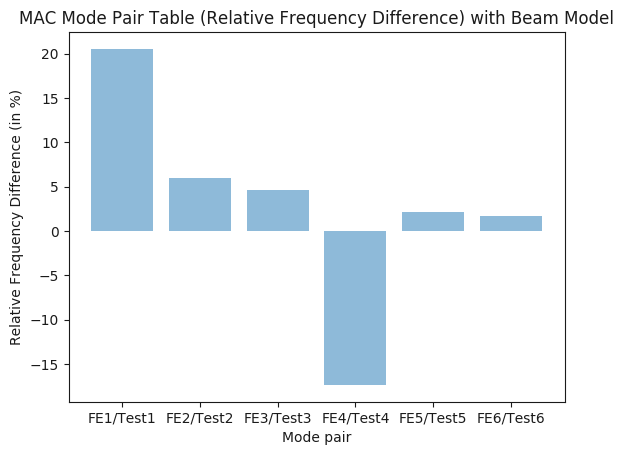

In [128]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

FreqTest=NaturalFreqlocal
FreqFEbeam=omegaFE1
RelativeFreq= ((FreqTest-FreqFEbeam)/FreqFEbeam)*100
RelativeFreq

objects= ('FE1/Test1','FE2/Test2','FE3/Test3','FE4/Test4','FE5/Test5','FE6/Test6')
Freqs= np.arange(len(objects))
plt.bar(Freqs, RelativeFreq, align= 'center', alpha=0.5)
plt.xticks(Freqs, objects)
plt.xlabel('Mode pair')
plt.ylabel('Relative Frequency Difference (in %)')
plt.title('MAC Mode Pair Table (Relative Frequency Difference) with Beam Model')
plt.show()

**Observations:**

- It is noticed that mode by mode the test frequencies are higher than the FEA, except for mode four.

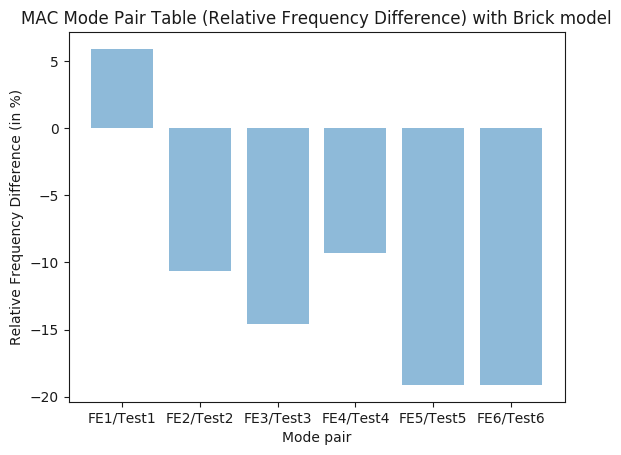

In [129]:
FreqTest=NaturalFreqlocal
FreqFEbrick=omegaFE2
RelativeFreq= ((FreqTest-FreqFEbrick)/FreqFEbrick)*100
RelativeFreq

objects= ('FE1/Test1','FE2/Test2','FE3/Test3','FE4/Test4','FE5/Test5','FE6/Test6')
Freqs= np.arange(len(objects))
plt.bar(Freqs, RelativeFreq, align= 'center', alpha=0.5)
plt.xticks(Freqs, objects)
plt.xlabel('Mode pair')
plt.ylabel('Relative Frequency Difference (in %)')
plt.title('MAC Mode Pair Table (Relative Frequency Difference) with Brick model')
plt.show()

**Observations:**

- It's quite opposite compared to beam model, here, the Test modes are very low compared to the FE brick model excluding the first mode.

### Manual updating of FE model:

There are two kinds of issues in the FE model that can be corrected manually, one is global issue and the other is local issue.

#### Fixing Relative Frequency difference for global errors:



- If we observe the difference plot above, the FE model frequencies for beam is consistently lower mode by mode and for brick, it is consistently higher, this can be due to something globally wrong with the structure. 


- This global error in FE model can be corrected as it is the known fact that to change the natural frequencies of the FE model there are basically two dials, one is Mass and the other is Stiffness. 


- Mass is easy to verify, just by checking the mass of the model matches the mass of the test structure. In case of the FE brick model Mass could be the primary issue, may be FE model mass is lower than the test. That is the reason for higher frequencies compared to the test frequencies.


- For Stiffness correction, as the issue is a global error, just the young's modulus needs to be checked whether it is off by any factor, if so, it needs to be corrected.


- Therefore, if it is global issue, changing the stiffness and the mass can solve the issue.




#### Localized issue:

- To find the localized issues, MAC would be useful. It is probable that if the MAC improves by not considering particular accelerometer location in the MAC calculation then there can be a localized error at that location. If we take the wing case here, even though there were 18 points on the structure only 15 points were used for correlating in order to get good MAC and this is because as we know that in modal testing, there is no such thing as a clamped beam because the clamp itself is moving but in FE simulation when the points get clamped then there would not be any motion. So, the clamped end points in testing and FE do not correlate well, this is due to not being able to accurately model the boundary conditions in the FE model. The same thing applies if there is a weld(spot weld where different areas of the model can be filled with different young's modulus or stiffness or even structural damping in certain regions) which is not modelled in the FEA properly, so neglecting that point would improve the MAC. By eliminating those points do not mean ignoring them completely but pretending that they don't exist in order to predict the region which has localized issues.

### Direct or Automatic model updating of the FE model:

Once all the manual updating of the FE model is done and achieved better correlation then the results can be further improved using the automatic model updating technique using Baruch method. This method make changes to the mass and the stiffness matrix using mode shape data obtained from the test. 

 This can be simply be performed using the **model_correction_direct** function in the vibration testing module in Python.

In [130]:
omega=np.array([13.54, 51.81, 125.19, 167.76, 228.05, 328.41])
McrcdBM, KcrcdBM = vt.model_correction_direct(Psi_TestBM, omega, Mbm, Kbm, method='Baruch')

In [131]:
McrcdBR, KcrcdBR = vt.model_correction_direct(Psi_TestBR, omega, Mbr, Kbr, method='Baruch')

### Adding Damping to the FE model from the test data:

- Important point to note is that the FE model did not spit out damping values. So, FE model has no damping included. However, damping is one of the important things when it comes to correlating FE models with the Test data. 


- 

**Important note:** While data collection, as already addressed above it is important to not use exponential window as it adds decay to the signal which will widen the peak thereby increasing the damping. Hence, it is better to extend the time window until the signal die-off instead of exponential window.


**Damping values for first 6 modes obtained from testing considering global damping eventhough damping locally may vary due to clamp boundary condition**

In [132]:
Damping

(0.0017411648392746146,
 0.0012488031601881739,
 0.0040876427711924622,
 0.00062677328877069872,
 0.0085864609141319253,
 0.00074953837145838294)

In [133]:

omega, zeta, PsiBM = vt.sos_modal(McrcdBM, KcrcdBM, damp_diag=0)
omegaFE1=np.array([omega[0], omega[1], omega[3], omega[4], omega[5], omega[6]])
Psi_2 = PsiBM
mode1=Psi_2[:,0]
mode2=Psi_2[:,1]
mode3=Psi_2[:,2]
mode4=Psi_2[:,3]
mode5=Psi_2[:,4]
mode6=Psi_2[:,5]
Psi_2BM= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))

In [134]:

omega, zeta, PsiBR = vt.sos_modal(McrcdBR, KcrcdBR, damp_diag=0)
omegaFE2=np.array([omega[0], omega[1], omega[3], omega[4], omega[5], omega[6]])
Psi_2 = PsiBR
mode1=Psi_2[:,0]
mode2=Psi_2[:,1]
mode3=Psi_2[:,2]
mode4=Psi_2[:,3]
mode5=Psi_2[:,4]
mode6=Psi_2[:,5]
Psi_2BR= np.column_stack((mode1, mode2, mode3, mode4, mode5, mode6))


### Technique for adding damping: some theory just to know that it exists in some softwares and use this technique in the back ground

The name of the technique is "FRAC - Frequency Response Assurance Criteria", which looks at the FRF from the simulation model versus the FRF from the test, compares the shape of the frequency peak. Basically, it iterates on the damping values to match better by putting some optimization.


It's like literally taking MAC kind of technique but applying on the FRF which can give some insight to damping values. This will not be done here in this note book.


Application of this technique depends on what is being modeled. If we are testing a disk brake (which will be shown later in polyreference section)or an exhaust system  in free-free condtion then we would have global over all damping which may be a few percent, so this can be added to the FE model by changing the global model parameter. However, when more complicated structures like an engine mounted on isolaters with damping, then it is not a good idea to do sytem correlation unless each of those are discretely tested, simulated and done localized testing of mount. Then those are put together on a large FE and test model to correlate the entire sytem. 

### FE-Test  Comparison after correction

**Step 1: MAC**

In [135]:
vt.mac(Psi_TestBM,Psi_2BM)

array([[ 0.881321121,  0.038974652,  0.026369503,  0.022319756,  0.043063273,  0.004626752],
       [ 0.151688823,  0.966339971,  0.083540347,  0.000101145,  0.00984486 ,  0.012454445],
       [ 0.026114408,  0.130064798,  0.985585275,  0.000779997,  0.146162695,  0.000792393],
       [ 0.000705308,  0.000182381,  0.000003272,  0.958222761,  0.000485955,  0.055843798],
       [ 0.016009234,  0.033694923,  0.135101087,  0.00022769 ,  0.999311401,  0.000000001],
       [ 0.000009955,  0.001125275,  0.002966466,  0.116284286,  0.000000452,  0.990680361]])

In [136]:
vt.mac(Psi_TestBR,Psi_2BR)

array([[ 0.698262238,  0.000359566,  0.001196876,  0.033783873,  0.000001657,  0.002985744],
       [ 0.08548994 ,  0.798983181,  0.011013081,  0.000197895,  0.016457018,  0.014427994],
       [ 0.01609378 ,  0.065317434,  0.895059712,  0.001135323,  0.055996187,  0.003718399],
       [ 0.025364975,  0.003495387,  0.004594898,  0.96107467 ,  0.000053346,  0.018941836],
       [ 0.013595906,  0.008849519,  0.049541316,  0.000901858,  0.978078484,  0.001089207],
       [ 0.004008585,  0.002180803,  0.030543414,  0.052915722,  0.000170555,  0.987921688]])

So, after updating the model the MAC matrix results improved drastically. When comparing the three observations made before correcting the model to after correcting:

* MAC values are still not 100%, but very close enough.


* MAC values of the torsional modes were improved to great extent.


* The highest off diagonal mode pair is mode 5 compared to mode 3 (and vice versa 3 to 5) with a MAC value of 34% before is now 13.5%. All the other off-diagonal mode pairs are below 16%. Thats for the Beam model. However, for the Brick off-diagonal terms increased.


**Important Note:**

In real world, for the complex structures, the test and the fea correlation should have 80% or above values on diagonal terms as the rule of thumb with minimized off-diagonal terms.

#### Uses:

A Modal Assurance Criterion (or MAC) analysis can be used in several different ways:

- Test-Test comparison – A MAC analysis can flag potential issues with the modal analysis results. Usually MAC will identify modes and areas that could benefit from acquiring more data points on the structure.


- FEA-FEA comparison – Several assumptions can be made in the creation of a FEA analysis: Young’s Modulus, boundary conditions, and mass density values to name a few. A MAC analysis can determine the degree to which these assumptions affect the resulting mode shapes.


- FEA-Test comparison – A MAC can be used to compare modes from an experimental modal analysis test to a Finite Element Analysis (FEA). It will indicate if the same mode shapes are found in both the test and FEA analysis.



## Can there be two modes at the same natural frequency?

No, there can never be two modes at the same natural frequency. However, there can be closely spaced modes, like one mode can be at 134.5 Hz and the other one can be at 134.6 Hz. So, there will be only one distinct mode at a given natural frequency. 

It is important to keep in mind that the resonance build-up with amplitudes, can look like one mode but it can be more than one. So, its basically the energy from the two modes is building up into one peak.

To understand this clearly, it is known from the above sections, that the resonance occurs at the natural frequency plus or minus a frequency range. Hence, even if the frequencies are not really close but there is another peak some where on the rising or trailing edge of a peak then there would be contributing energy that may bleed in to another peak influencing that mode. 

There are techniques to separate these modes which are discussed below.


## Polyreference Test 

Polyreference means having two or more reference accelerometer responses to do Modal Analysis, unlike SISO we would have two or more rows.

**Why Polyreference Test?**

There are two reasons for doing polyreference:
- Sometimes one position of the accelerometer may not be ideal for all the frequencies, for instance, if we place the accel at the node point for a particular frequency then that mode shall be blinded or doesn't appear in the FRFs measured. So, the second one could be useful.


- In some cases, there may be more than one mode at the same frequency, also called repeated roots. In the same way that the system split to find two natural frequencies because of the mass loading error in the stability diagram shown few sections earlier, system would split in a similar way but the MIF indicates that there are two mode, that way we can  differentiate from mass loading error. So, we need to separate them with two reference accelerometers, roving the hammer around to do the modal analysis accurately.

**When do we have two resonant frequencies close to each other that appears to be the same?**

This happens when we have a symmetrical object like a Disc Brake. Polyreference technique works very well with the disc brake because it would have one mode, for instance, showing in zero degree angle and the next mode in 90 degrees with it at the same frequency. 

## Experimental Modal Analysis on Brake Disc using Polyreference Technique



Here, two accelerometers are used as a reference and roving the hammer over 48 locations in order to seperate the closely spaced modes. We can also use two shakers as the reference and roving the accelerometer over 48 locations.


![Ideal System(no noise)](img/polyref)

### Creating Geometry:


- Fourty eight locations were used to create a rough geometry of the brake disk in order to animate mode shapes.


![Ideal System(no noise)](img/brakedisk.png)

### Rough Mode shapes obtained using peak picking method:

As discussed in the above sections, the peak picking method will work better only for well separated modes, and there would be very closely spaced modes, only curve fitting would give the accurate mode details. It can be observed below that peak picking method has only 3 modes where as curve fitting gives 5.

![Ideal System(no noise)](img/1359_1)

![Ideal System(no noise)](img/2537_1)

![Ideal System(no noise)](img/2920_1)

### LSCE Curve fitting:

The insight to the stabilization diagram is given in the above sections. Only difference here is 2 references, some increase in model order to estimate the modes accurately.

![Ideal System(no noise)](img/LSCE_1)

### Mode shapes obtained using curve fitting:

Each selection of the natural frequency and the damping ratio gives the corresponding mode shape. The modes that are very close have the mode shapes that are 90 degrees apart.

![Ideal System(no noise)](img/1360CF.png)

![Ideal System(no noise)](img/1361CF.png)

![Ideal System(no noise)](img/2539CF.png)

![Ideal System(no noise)](img/2921CF.png)

![Ideal System(no noise)](img/2923.png)

## MIMO

MIMO stands for Multiple inputs and multiple outputs. This can be done with two or more shakers where two or more columns are filled instead of two or more rows of the FRFs. The idea of giving more inputs is also to have more references.

**Why MIMO?**

There are two reasons for doing MIMO:

- When we have bigger structures like an aircraft, it may need lot of force to get moving. Because we cannot have only one attachment point to excite the structure sufficiently well, multiple shakers are preferred to distribute the load.


- Another reason is due to the known fact that there can be more than one mode at nearly the same frequency, called repeated roots. The two frequencies may not be exactly same but they would be very close like 2 to 5 Hz a part. However, because of the damping they cannot be separated, this can be done with having two or more shakers as references in case of a Brake disc. The advantage of taking more references is something which we could see while curve fitting where Mode Indicator Function can be used, it basically indicates where there are resonant frequencies to conform a closely spaced mode at that location.

#### Important things to know while conducting MIMO:

- When we have more than one shaker then it is essential that the signal be random or burst random because these signals need to be totally uncorrelated. If they are correlated the math breaks down and does not work. An issue may arise when the same model of the random generator is used for  both the shakers as the random generator sequence may be exactly same. So, care should be taken, they have to be totally uncorrelated and that's the key to make this work.


- The normal coherence will have issues because of the fact that the second shaker's contribution would be considered as uncorrelated noise. Therefore, in case of MIMO, there is multiple coherence which will take into account the multiple contributions.



- In the same way, a typical FRF which is only taking into account one force and one accelerometer will be noisy because there is something else. So, here multiple FRF comes into picture.

## Some possible results of bad data  on the same system with impulse hammer, and explaination of why?

Undoubtedly, key to get information about all these cases except case 5 is to look at the coherence. However, here the main intention is to look at the issues and how to resolve it.

#### Case 1:

Observing the data, it looks good up to about 200 Hz then as the peak drops from 200 Hz there is a notch and then from there it looks completely noisy, which means that atleast one of the sensors has no data above that notch, the data is purely noise. 

The reason for this is because there is not enough energy to excite the frequencies after about 200 Hz. This happens when there is too softer tip on the hammer. This is well explained in the hammers section above, where we see a faster roll-off in the hammer auto spectrum density using a softer tip. 



![alt](img/a1)



(Reference for the figure: [Joseph C. Slater, Ph.D., P.E. Professor and Chair at Wright State University](https://people.wright.edu/joseph.slater))


To resolve this we need to change the hammer tip to harder one and see the auto spectrum to verify whether sufficient energy is being used to excite the frequency range of interest.

#### Case 2:

This one way to figure out the problem in this FRF is by looking at the phase information. It is important not to ignore the phase. Because phase tells us exactly where things get bad. 

First thing we can observe is that at lower amplitudes phase is very noisy and that is normal. However, if we observe at lower frequencies, the phase is not flat, usually phase would be flat until it gets close to the resonance but here it is drifting down. So, that tells us there is something wrong. 

**The reason: ?**



![alt](img/b1)




(Reference for the figure: [Joseph C. Slater, Ph.D., P.E. Professor and Chair at Wright State University](https://people.wright.edu/joseph.slater))

#### Case3: 

The first observation from the phase plot is that the sensor used has to be a velocity sensor as it started from 90 degrees. At resonance, the phase should go 180 degrees if it obeys the laws of physics. However, there is some shift which is apparent.  This may be because of applying a wrong window to the impulse excitation, which should be other than exponential and rectangular or no window types. 



![alt](img/c1)



(Reference for the figure: [Joseph C. Slater, Ph.D., P.E. Professor and Chair at Wright State University](https://people.wright.edu/joseph.slater))

#### Case 4:

This looks like we have regular drop-offs in the data that is caused due to the double hits. As shown in the hammers section above how the double hit auto spectrum looks like, it shows oscillation and drop-offs in the spectrum. Hence the resulting spectrum shown below has fake peaks appearing with noise surrounding. 

![alt](img/d1)




(Reference for the figure: [Joseph C. Slater, Ph.D., P.E. Professor and Chair at Wright State University](https://people.wright.edu/joseph.slater))|

#### Case 5:

Although, all the FRFs in these cases belongs to the same system, we can observe here that the peak here is at near 145 Hz with a zero or anti-resonance before it. Another observation is that the data ends at 170 Hz.

This is because of aliasing, as the cut-off here is 170 Hz, the sampling rate according to Nyquist would be at 340 Hz. Therefore, the actual resonance at 200 Hz at this sampling rate looks like 30 Hz below the cut-off. 

![alt](img/e1)




(Reference for the figure: [Joseph C. Slater, Ph.D., P.E. Professor and Chair at Wright State University](https://people.wright.edu/joseph.slater))

## References to Modules and Books Used:

[WFEM](https://github.com/josephcslater/WFEM) : by Dr. Joseph Slater

[OpenModal](https://github.com/openmodal/OpenModal) : created as an Opensource software written in 
Python for Vibration Testing with excellent capabilities. 

[vibrationtesting](https://github.com/Vibration-Testing/vibrationtesting) : by Dr. Joseph Slater

[Vibration Toolbox]( https://github.com/vibrationtoolbox/vibration_toolbox.git) : by Dr. Joseph Slater

Slater, J. C., Vibration Testing, with Modal Analysis and Health Monitoring, John Wiley & Sons, Ltd, 2002
  
Finite Element Model Updating in Structural Dynamics by M.I. Friswell and J.E. Mottershead

Concepts and Applications of Finite Element Analysis, Fourth edition by Robert D. Cook, David S. Malkus, Michael E. Plesha and Robert J. Witt

[Siemens Corp. Seminar](https://community.plm.automation.siemens.com/t5/Event-Collateral/Modal-Analysis-and-FEA-Test-Correlation/ta-p/435288)

[Bruel & Kjaer Training course](https://bksv.com/en/Training/training-courses/UnitedStates/UnitedStates/Live-Courses/Modal-Analysis/05-15-2018): Some Pictures and Bulletin points were taken directly from Modal Analysis Conference conducted by Bruel and Kjaer, Chicago, May2018.
Mr Robert Trepanier is the presenter who has more than 30 years of experience, I strongly suggest to attend for good understanding of Modal Analysis.